In [1]:
import numpy as np
import os, datetime
from glob import glob
import re

import pytorch_lightning as pl
from torch import nn
import torch
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

import torch.distributions as tfd
from tqdm import tqdm
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device('cuda')

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from scipy.stats import norm
import matplotlib.pyplot as plt
import h5py, corner
from scipy.interpolate import interp1d

from matplotlib import rcParams
rcParams.update({'font.size': 12})

/home/dbreitman/.conda/envs/pytorch_env/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/dbreitman/.conda/envs/pytorch_env/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrast

In [2]:
len(os.listdir('/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/399'))

134

In [3]:
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm.notebook import tqdm
import gc 

%matplotlib inline


# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/tutorial9")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


In [4]:
from pathlib import Path
import os

In [5]:
path = '/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/'
model_path = '/home/dbreitman/CV_PS_denoising/Dec_models/'

In [6]:
import sys
sys.path.insert(1, '/home/dbreitman')
from dani_utils.plotting import imshow_error_2D, plot_hist
from dani_utils.test_funcs import Normalize, diag_cov

In [125]:
with np.load(model_path + 'norms.npz') as f:
    noisy_mean = f['noisy_mean']
    noisy_std = f['noisy_std']
    mean_mean = f['mean_mean']
    mean_std = f['mean_std']

f = np.load(path + 'dec_db_50_thetas_nointerp_nolog_lesszs.npz')
seeds = f['PS_2D_seeds']
means = f['PS_2D_means']
zs = f['redshifts']
kperp = f['kperp']
kpar = f['kpar']
modes = f['modes']
std_means = f['PS_2D_std_means']
param_idx = f['param_idx']
param_idx_test = np.array([[pi] * len(zs) for pi in param_idx]).ravel()
print(seeds.max(), means.max())
std_poisson = f['poisson_stds']
std_diff = np.log10(std_poisson) - np.log10(std_means)
print(std_diff.min(), std_diff.max())

N_samples = seeds.shape[0]
zs_test = list(zs) * N_samples
shape1 = (seeds.shape[0] * seeds.shape[1], seeds.shape[2], seeds.shape[3])
std_diff = std_diff.reshape(shape1)

std_means = std_means.reshape(shape1)
zs_test = np.reshape(zs_test, shape1[0])
#std_poisson = std_poisson.reshape(shape1[:-1])

print(seeds.min(), means.max())

seeds = seeds.reshape(shape1)

means = means.reshape(shape1)
noisy = (np.log10(seeds) - noisy_mean) / noisy_std

mean = (np.log10(means) - mean_mean) / mean_std

377832949.11699194 134092989.46093081
-2.517855813259384 0.15702954040615236
0.009999999999999998 134092989.46093081


In [94]:
means.shape

(77392, 32, 32)

In [134]:
f = np.load(path + 'dec_db_350_thetas_nointerp_nolog_lesszs.npz')
seeds = f['PS_2D_seeds']
means = f['PS_2D_means']
zs = f['redshifts']
kperp = f['kperp']
kpar = f['kpar']
Nmodes = f['modes']
std_means = f['PS_2D_std_means']
std_poisson = f['poisson_stds']
std_diff = np.log10(std_poisson) - np.log10(std_means)

print(std_diff.min(), std_diff.max())
modes = f['modes']

N_samples = means.shape[0]
zs_final = list(zs) * N_samples
shape1 = (means.shape[0] * means.shape[1], means.shape[2], means.shape[3], 2)
zs_final = np.reshape(zs_final, shape1[0])
std_diff = std_diff.reshape(shape1[:-1])
means = means.reshape(shape1[:-1])
input_data = seeds.reshape(shape1[:-1])
std_means = std_means.reshape(shape1[:-1])
#std_poisson = std_poisson.reshape(shape1[:-1])
print(input_data.shape)

#bias = 1e-8
#floor = 1e-8
noisy_norm = Normalize(input_data, log = True, axis = 0)
noisy, noisy_mean, noisy_std = noisy_norm.get_normed_data()

mean_norm = Normalize(means, log = True, axis = 0)
mean , mean_mean, mean_std = mean_norm.get_normed_data()

f_train = 0.9
f_valid = 1 - f_train

print(mean.min(), mean.max())
print(std_diff.min(), std_diff.max())

outputs_1 = np.append(mean[...,np.newaxis], std_diff[...,np.newaxis], axis = -1)
#outputs_2 = np.append(noisy[...,np.newaxis], poisson_std[...,np.newaxis], axis = -1)

N_train = int(np.round(shape1[0] * f_train))
N_valid = int(np.round(shape1[0] * f_valid))

# shuffle
idx = np.arange(shape1[0])
np.random.shuffle(idx)

outputs_1 = outputs_1

features = noisy[:,np.newaxis,...]#np.append(noisy[:,np.newaxis,...], zs_final_ch[:,np.newaxis,...], axis = 1) # Noisy
#outputs = np.append(normed_dataset[...,1][...,np.newaxis], normed_covar[...,np.newaxis],axis = -1) # Mean and covar
#features[np.isnan(features)] = 0.
print('Training set size: ', N_train)
print('Validation set size:', N_valid)

X_valid = features[idx][N_train:N_train+N_valid]

Y_valid = outputs_1[idx][N_train:N_train+N_valid]

#Y_train_id = outputs_2[:N_train]
#Y_valid_id = outputs_2[N_train:N_train+N_valid]

print(X_valid.shape)

-2.676259367632725 0.17908926764186228
(600528, 32, 32)
-3.881394935353991 2.047288132102479
-2.676259367632725 0.17908926764186228
Training set size:  540475
Validation set size: 60053
(60053, 1, 32, 32)


In [10]:
std_means.min(), std_means.max()

(0.01, 112723789.28509007)

In [11]:
zs_final_ch = np.zeros(mean.shape)
for i in range(mean.shape[0]):
    zs_final_ch[i,...] = zs_test[i]

IndexError: index 77392 is out of bounds for axis 0 with size 77392

In [8]:
batch_size = 128
name = 'Dec23'
model_path = '/home/dbreitman/CV_PS_denoising/Dec_models/'

In [10]:
print(means.min(), means.max())
print(std_means.min(), std_means.max())


X_test = noisy[:,np.newaxis,...]#np.append(noisy[:,np.newaxis,...], zs_final_ch[:,np.newaxis,...], axis = 1) # Noisy
Y_test = np.append(mean[...,np.newaxis], std_diff[...,np.newaxis], axis = -1)

print(X_test.shape)

0.009999999999999998 134092989.46093081
0.01 68708252.51578708
(77392, 1, 32, 32)


In [36]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, stride=2),  # 16x16 => 7x7
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, stride=2), # 7x7 => 3x3
            act_fn(),
        )
        
        self.resblock = nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(c_hid),
        )
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.LazyLinear(latent_dim),
                                    act_fn(),
        )

    def forward(self, x):
        y = self.net(x)
        y = self.resblock(y)
        y = self.resblock(y)
        y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 32
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * 16 * c_hid), 
                                    act_fn(),
                                   nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(),
                                   nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(),
                                   )
        self.resblock = nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(n * c_hid),
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=3, stride=1),  # 4x4 => 6x6
            act_fn(),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 7x7
            act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=3, stride = 1), #7x7 => 14x14
            act_fn(),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=3, stride = 1), #14x14 => 16x16
        )
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.resblock(x)
        x = self.resblock(x)
        x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        #x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.LeakyReLU()(x[:,1,...])[:, np.newaxis,...]), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
        width: int = 16,
        height: int = 16,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [28]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, stride=2),  # 16x16 => 7x7
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, stride=2), # 7x7 => 3x3
            act_fn(),
            nn.BatchNorm2d(c_hid),
        )
        
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(c_hid),
        ))
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.LazyLinear(latent_dim),
                                    act_fn(),
        )

    def forward(self, x):
        y = self.net(x)
        y = self.resblock(y)
        y = self.resblock(y)
        y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 64
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * 16 * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * 16 * c_hid, n * 16 * c_hid), 
                                    act_fn(),
                                   )
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(n * c_hid),
        ))
        self.net = nn.Sequential(
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=3, stride=1),  # 4x4 => 6x6
            act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 7x7
            act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=3, stride = 1), #7x7 => 14x14
            act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=3, stride = 1), #14x14 => 16x16
        )
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.resblock(x)
        x = self.resblock(x)
        x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        #x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.LeakyReLU()(x[:,1,...])[:, np.newaxis,...]), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
        width: int = 16,
        height: int = 16,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [31]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=2, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.BatchNorm2d(c_hid),
            #nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 4x4 => 2x2
            #act_fn(),
            #nn.BatchNorm2d(c_hid),
        )
        
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
        ))
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.Linear(c_hid * 4 ** 2, latent_dim),
                                    act_fn(),
        )

    def forward(self, x):
        y = self.net(x)
        y = self.resblock(y)
        y = self.resblock(y)
        y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 64
        outshape = 4**2
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                   )
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
        ))
        self.net = nn.Sequential(
            #nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 2x2 => 4x4
            #act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 8x8
            act_fn(),
            nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=2, stride = 2), #8x8 => 16x16
            #act_fn(),
        )
        self.floorT = torch.Tensor([0.0186]).to(DEVICE).float()
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.resblock(x)
        x = self.resblock(x)
        x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.ReLU()(x[:,1,...]-self.floorT)[:, np.newaxis,...] +self.floorT), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [146]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=2, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=(1,2), stride=(1,2)), # 4x4 => 2x2
            act_fn(),
            nn.BatchNorm2d(c_hid),
        )
        
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
        ))
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.Linear(c_hid * 4 ** 2, latent_dim),
                                    act_fn(),
        )

    def forward(self, x):
        y = self.net(x)
        y = self.resblock(y)
        y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 64
        outshape = 4**2
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                   )
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
        ))
        self.net = nn.Sequential(
            #nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 2x2 => 4x4
            #act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 8x8
            act_fn(),
            nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride = 2), #8x8 => 16x16
            act_fn(),
            nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=(1,2), stride = (1,2)) #16x16 -> 16x32
            
        )
        self.floorT = torch.Tensor([0.0186]).to(DEVICE).float()
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.resblock(x)
        x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.ReLU()(x[:,1,...]-self.floorT)[:, np.newaxis,...] +self.floorT), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [27]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=2, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=(1,2), stride=(1,2)), # 4x4 => 2x2
            act_fn(),
            nn.BatchNorm2d(c_hid),
        )
        
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=3, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=3, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(c_hid),
        ))
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.Linear(c_hid * 4 ** 2, latent_dim),
                                    act_fn(),
        )

    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.kaiming_uniform_(m.weight, a = np.sqrt(5.))
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
            if fan_in != 0:
                bound = 1 / np.sqrt(fan_in)
                torch.nn.init.uniform_(m.bias, -bound, bound)
                
    def forward(self, x):
        #self.net.apply(self.init_weights)
        #self.resblock.apply(self.init_weights)
        #self.latent.apply(self.init_weights)
        y = self.net(x)
        y = self.resblock(y)
        y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 64
        outshape = 4**2
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                   )
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=3, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=3, padding = 'same'),
                                    act_fn(),
                                    nn.BatchNorm2d(n * c_hid),
        ))
        self.net = nn.Sequential(
            #nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 2x2 => 4x4
            #act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 8x8
            act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride = 2), #8x8 => 16x16
            act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=(1,2), stride = (1,2)), #16x16 -> 16x32

            
        )
        self.floor_std = torch.Tensor([1e-9]).to(DEVICE, dtype=torch.float64)
        self.floor_mean = torch.Tensor([-6.]).to(DEVICE, dtype=torch.float64)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.kaiming_uniform_(m.weight, a = np.sqrt(5.))
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
            if fan_in != 0:
                bound = np.sqrt(1 / np.sqrt(fan_in))
                torch.nn.init.uniform_(m.bias, -bound, bound)
                
    def forward(self, x):
        #self.net.apply(self.init_weights)
        #self.resblock.apply(self.init_weights)
        #self.linear.apply(self.init_weights)
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.resblock(x)
        x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        x = torch.cat((nn.ReLU()(x[:,0,...]-self.floor_mean)[:, np.newaxis,...] +self.floor_mean, nn.ReLU()(x[:,1,...]-self.floor_std)[:, np.newaxis,...] +self.floor_std), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [15]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=2, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 4x4 => 2x2
            act_fn(),
            nn.BatchNorm2d(c_hid),
        )
        
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
        ))
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.Linear(c_hid * 4 ** 2, latent_dim),
                                    act_fn(),
        )

    def forward(self, x):
        y = self.net(x)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 64
        outshape = 4**2
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                   )
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
        ))
        self.net = nn.Sequential(
            #nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 2x2 => 4x4
            #act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            #nn.Conv2d(32, 2 * c_hid, kernel_size=3), #6x6 -> 4x4
            #act_fn(),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 8x8
            act_fn(),
            nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride = 2), #8x8 => 16x16
            act_fn(),
            nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=2, stride = 2) #16x16 -> 32x32
            
        )
        self.floorT = torch.Tensor([0.0186]).to(DEVICE).float()
    def forward(self, x):
        #x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        #x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        #x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.ReLU()(x[:,1,...])[:, np.newaxis,...]), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [10]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return (self.module(inputs) + inputs).float()

class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=2, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.BatchNorm2d(c_hid),
            nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.BatchNorm2d(c_hid),
            #nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 8x8 => 4x4
            #act_fn(),
            #nn.BatchNorm2d(c_hid),
            #nn.Conv2d(c_hid, c_hid, kernel_size=2, stride=2), # 4x4 => 2x2
            #act_fn(),
            #nn.BatchNorm2d(c_hid),
        )
        
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(c_hid, c_hid, kernel_size=6, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
                                    nn.Conv2d(c_hid, c_hid, kernel_size=6, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(c_hid),
        ))
        self.latent = nn.Sequential(nn.Flatten(),  # Image grid to single feature vector
                                    nn.Linear(c_hid * 4 ** 2, latent_dim),
                                    act_fn(),
        )

    def forward(self, x):
        y = self.net(x)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.resblock(y)
        #y = self.latent(y)
        return y
    

class Decoder(nn.Module):
    def __init__(self, 
                 num_input_channels: int, 
                 num_output_channels: int, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 act_fn: object = nn.LeakyReLU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        n = 64
        outshape = 4**2
        self.linear = nn.Sequential(nn.Linear(latent_dim, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                    nn.Linear(n * outshape * c_hid, n * outshape * c_hid), 
                                    act_fn(),
                                   )
        self.resblock = ResNet(nn.Sequential(nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
                                    nn.Conv2d(n * c_hid, n * c_hid, kernel_size=5, padding = 'same'),
                                    act_fn(),
                                    #nn.BatchNorm2d(n * c_hid),
        ))
        self.net = nn.Sequential(
            #nn.ConvTranspose2d(n*c_hid, n * c_hid, kernel_size=2, stride=2),  # 2x2 => 4x4
            #act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            #nn.ConvTranspose2d(n*c_hid, n * c_hid, kernel_size=2, stride=2),  # 2x2 => 4x4
            #act_fn(),
            #nn.BatchNorm2d(n * c_hid),
            nn.Conv2d(n*c_hid, n * c_hid, kernel_size=2, stride = 2), #6x6 -> 4x4
            act_fn(),
            nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride=2),  # 4x4 => 8x8
            act_fn(),
            nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, n * c_hid, kernel_size=2, stride = 2), #8x8 => 16x16
            act_fn(),
            nn.BatchNorm2d(n * c_hid),
            nn.ConvTranspose2d(n * c_hid, num_output_channels, kernel_size=2, stride = 2) #16x16 -> 32x32
            
        )
        self.floorT = torch.Tensor([0.0186]).to(DEVICE).float()
    def forward(self, x):
        #x = self.linear(x)
        #x = x.reshape(x.shape[0], -1, 2, 2)
        #x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        #x = self.resblock(x)
        x = self.net(x)
        #x = torch.cat((x[:,0,...][:, np.newaxis,...], nn.ReLU()(x[:,1,...])[:, np.newaxis,...]), 1)
        return x

class Autoencoder(nn.Module):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 1,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        #self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, num_output_channels, num_input_channels, latent_dim)


    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    

class Residual_Denoiser(nn.Module):
    def __init__(
        self,
        in_channel_num: int,
        out_channel_num: int,
        act_fn: object = nn.LeakyReLU
    ):
        super().__init__()
        self.act_fn = act_fn
        self.resblock532 = ResNet(nn.Sequential(nn.Conv2d(32, 32, kernel_size=5, padding = 'same'),
                                act_fn(),
                                nn.BatchNorm2d(32),
                                nn.Conv2d(32, 32, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.resblock32 = ResNet(nn.Sequential(nn.Conv2d(32, 32, kernel_size=3, padding = 'same'),
                                act_fn(),
                                nn.BatchNorm2d(32),
                                nn.Conv2d(32, 32, kernel_size=3, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.resblock64 = ResNet(nn.Sequential(nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                nn.BatchNorm2d(64),
                                nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.resblock128 = ResNet(nn.Sequential(nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                nn.BatchNorm2d(128),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.resblock5512 = ResNet(nn.Sequential(nn.Conv2d(256, 512, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(512, 512, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        
        self.resblock5in = ResNet(nn.Sequential(nn.Conv2d(in_channel_num, 32, kernel_size=5, padding = 'same'),
                                act_fn(),
                                nn.BatchNorm2d(32),
                                nn.Conv2d(32, 32, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.resblock5out = ResNet(nn.Sequential(nn.Conv2d(256, 2, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(2, 2, kernel_size=5, padding = 'same'),
                                ))
        self.maxpool5 = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor = 2)
        self.cnn1 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(64, 64, kernel_size=3, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.cnn2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(64, 64, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.cnn3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.cnn4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.cnn5 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(256, 256, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.cnn6 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(256, 256, kernel_size=5, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.resnet1 = ResNet(nn.Sequential(nn.Conv2d(256, 256, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(256, 256, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.cnn7 = nn.Sequential(nn.Conv2d(256, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.resnet2 = ResNet(nn.Sequential(nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(128, 128, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.cnn8 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.resnet3 = ResNet(nn.Sequential(nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(64, 64, kernel_size=2, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.cnn9 = nn.Sequential(nn.Conv2d(64, 32, kernel_size=6, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(32, 32, kernel_size=6, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                )
        self.resnet4 = ResNet(nn.Sequential(nn.Conv2d(32, 32, kernel_size=6, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(32, 32, kernel_size=6, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                ))
        self.cnn10 = nn.Sequential(nn.Conv2d(32, 16, kernel_size=6, padding = 'same'),
                                act_fn(),
                                #nn.BatchNorm2d(n * c_hid),
                                nn.Conv2d(16, out_channel_num, kernel_size=6, padding = 'same'),
                                )
    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        act_fn = self.act_fn
        y = self.resblock5in(x)
        y = self.resblock532(y)
        y = self.maxpool5(y)
        y = self.resblock32(y)
        y = self.cnn1(y)
        y = self.cnn2(y)
        y = self.maxpool5(y)
        y = self.resblock64(y)
        y = self.cnn3(y)
        y = self.cnn4(y)
        y = self.maxpool5(y)
        y = self.resblock128(y)
        y = self.cnn5(y)
        y = self.cnn6(y)
        ## End Encoder
        y = self.resnet1(y)
        y = self.upsample(y)
        y = self.cnn7(y)
        y = self.resnet2(y)
        y = self.upsample(y)
        y = self.cnn8(y)
        y = self.resnet3(y)
        y = self.upsample(y)
        
        y = self.cnn9(y)
        y = self.resnet4(y)
        y = self.cnn10(y)
        return y

In [ ]:
# Plot of fractional std diff
frac_diff_std = abs((std_poisson - std_means) / std_means)

# avg over all thetas
frac_diff_std_avg = np.mean(frac_diff_std, axis = 0)

#we plot for z ~ 8
m = zs_test == zs[10]

avg8 = np.mean(frac_diff_std_avg[m], axis = bla)

imshow_error_2D(avg8, xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Fractional difference between MC sample std and Poisson estimate',
             vmin = 7., vmax = 20., label = r'$\frac{\sigma[{ \rm MC Samples}] - \sigma[{\rm Poisson}]}{\sigma[{\rm Poisson}]}$ (%)', log = False)

In [11]:
def modulelist2sequential(module:nn.ModuleList) -> nn.Sequential:
    out = nn.Sequential()
    for layer in module:
        out.append(layer)
    return out

class ResNet(torch.nn.Module):
    def __init__(self, module, act_fn: object = nn.LeakyReLU):
        super().__init__()
        self.module = module
        self.dropout = nn.Dropout(0.1)
        self.act = act_fn()

    def forward(self, inputs):
        return (self.module(inputs) + inputs).float()

class CNN(nn.Module):
    def __init__(self, nconvs:int, 
                 in_ch: int, out_ch: int, dropout:bool=False,
                 hid_ch:int=None, kernel_size:int = 2, f_dropout:float=0.1,
                 stride:int=1, padding:int='same', final_act:bool=False,
                 batch_norm: bool = False, 
                 act_fn: object = nn.LeakyReLU, residual:bool=False):
        super().__init__()
        self.cnn = cnn_list(nconvs=nconvs, 
                 in_ch=in_ch, out_ch=out_ch, 
                 hid_ch=hid_ch, kernel_size=kernel_size, 
                 stride=stride, padding=padding, final_act=final_act,
                 batch_norm=batch_norm, act_fn=act_fn, residual=residual)
        self.residual = residual
        
    def forward(self, x):
        y = self.cnn(x)
        return y

def cnn_list(nconvs:int, 
                 in_ch: int, out_ch: int, dropout:bool=False,
                 hid_ch:int=None, kernel_size:int = 2, f_dropout:float=0.1,
                 stride:int=1, padding:int='same', final_act:bool=False,
                 batch_norm: bool = False, act_fn: object = nn.LeakyReLU, 
                 residual:bool = False) -> nn.ModuleList:

    act = act_fn()
    if hid_ch is None:
        hid_ch = out_ch
    conv_in = nn.Sequential(nn.Conv2d(in_ch, hid_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn())
    conv_hid = nn.Sequential(nn.Conv2d(hid_ch, hid_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn())
    if batch_norm:
        conv_in.append(nn.BatchNorm2d(hid_ch))
        conv_hid.append(nn.BatchNorm2d(hid_ch))
    if dropout:
        conv_in.append(nn.Dropout(f_dropout))
        conv_hid.append(nn.Dropout(f_dropout))
    cnn = modulelist2sequential(nn.ModuleList([conv_hid for i in range(nconvs-2)]))
    if final_act:
        conv_out = nn.Sequential(nn.Conv2d(hid_ch, out_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn())
    else:
        conv_out = nn.Conv2d(hid_ch, out_ch, kernel_size = kernel_size, stride = stride, padding = padding)
    if residual:
        return ResNet(nn.Sequential(conv_in.extend(cnn.append(conv_out))))
    else:
        return conv_in.extend(cnn.append(conv_out))
        

class Autoencoder(nn.Module):
    def __init__(self, in_ch: int=2, out_ch:int=2):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        self.cnn_in = CNN(nconvs = 2, in_ch = in_ch, 
                              out_ch = 128, kernel_size = 5, padding = 'same', 
                              batch_norm = True, final_act = True, residual = False)
        self.resblock32 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 5, padding = 'same', 
                              batch_norm = True, final_act = True, residual = True)
        self.resblock32_2 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 3, padding = 'same', 
                              batch_norm = True, final_act = True, residual = True)
        self.resblock64 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 2, padding = 'same', 
                              batch_norm = True, final_act = True, residual = True)
        self.resblock128 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 2, padding = 'same', 
                              batch_norm = True, final_act = True, residual = True)
        self.cnn1 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 3, padding = 'same', 
                              batch_norm = False, final_act = True, residual = True)
        self.cnn2 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 3, padding = 'same', 
                              batch_norm = False, final_act = True, residual = True)
        self.cnn3 = CNN(nconvs = 4, in_ch = 128, 
                              out_ch = 128, kernel_size = 2, padding = 'same', 
                              batch_norm = False, final_act = True, residual = True)
        self.cnn4 = CNN(nconvs = 4, in_ch = 128, 
                              out_ch = 128, kernel_size = 2, padding = 'same', 
                              batch_norm = False, final_act = True, residual = True)
        self.maxpool = nn.MaxPool2d(2)
        

        ## DECODER ##
        self.resnet1 = CNN(nconvs = 2, in_ch = 128, 
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)
    
        self.cnn7 = CNN(nconvs = 4, in_ch = 128, hid_ch = 128,
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)

        self.resnet2 = CNN(nconvs = 2, in_ch = 128,
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)
        self.cnn8 = CNN(nconvs = 4, in_ch = 128, hid_ch = 128,
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)
        self.resnet3 = CNN(nconvs = 2, in_ch = 128,
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)

        self.cnn9 = CNN(nconvs = 2, in_ch = 128, hid_ch = 128,
                           out_ch = 128, kernel_size = 6, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)
        self.resnet4 = CNN(nconvs = 2, in_ch = 128,
                           out_ch = 128, kernel_size = 6, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)

        self.cnn10 = CNN(nconvs = 2, in_ch = 128, hid_ch = 16,
                           out_ch = out_ch, kernel_size = 6, padding = 'same', 
                           batch_norm = False, final_act = False, residual = False)
        self.upsample = nn.Upsample(scale_factor = 2)
    def forward(self, x):
        ## ENCODER ##
        encode1 = self.cnn_in(x)
        encode2 = self.resblock32(encode1)
        encode3 = self.maxpool(encode2)
        encode4 = self.resblock32_2(encode3)
        encode5 = self.cnn1(encode4)
        encode6 = self.cnn2(encode5)
        encode7 = self.maxpool(encode6)
        encode8 = self.resblock64(encode7)
        encode9 = self.cnn3(encode8)
        encode10 = self.maxpool(encode9) 
        
        ## Bottleneck
        encode11 = self.resblock128(encode10) 
        encode = self.cnn4(encode11)
        
        decode1 = self.resnet1(encode) + encode11
        
        ## DECODER ##
        decode2 = self.upsample(decode1)
        decode3 = self.cnn7(decode2) + encode9
        decode4 = self.resnet2(decode3) + encode8 
        decode5 = self.upsample(decode4) + encode6
        decode6 = self.cnn8(decode5) + encode5
        decode7 = self.resnet3(decode6) + encode4
        decode8 = self.upsample(decode7) + encode1
        decode9 = self.cnn9(decode8) + encode1
        decode10 = self.resnet4(decode9) + encode1
        decoded = self.cnn10(decode10)
        return decoded

In [12]:
class ResNet(torch.nn.Module):
    def __init__(self, module, act_fn: object = nn.LeakyReLU):
        super().__init__()
        self.module = module
        self.dropout = nn.Dropout(0.1)
        self.act = act_fn()

    def forward(self, inputs):
        return (self.module(inputs) + inputs).float()

class CNN(nn.Module):
    def __init__(self, nconvs:int, 
                 in_ch: int, out_ch: int, dropout:bool=False,
                 hid_ch:int=None, kernel_size:int = 2, f_dropout:float=0.1,
                 stride:int=1, padding:int='same', final_act:bool=False,
                 batch_norm: bool = False, 
                 act_fn: object = nn.LeakyReLU, residual:bool=False):
        super().__init__()
        self.cnn = cnn_list(nconvs=nconvs, 
                 in_ch=in_ch, out_ch=out_ch, 
                 hid_ch=hid_ch, kernel_size=kernel_size, 
                 stride=stride, padding=padding, final_act=final_act,
                 batch_norm=batch_norm, act_fn=act_fn, residual=residual)
        self.residual = residual
        
    def forward(self, x):
        y = self.cnn(x)
        return y

def cnn_list(nconvs:int, 
                 in_ch: int, out_ch: int, dropout:bool=False,
                 hid_ch:int=None, kernel_size:int = 2, f_dropout:float=0.1,
                 stride:int=1, padding:int='same', final_act:bool=False,
                 batch_norm: bool = False, act_fn: object = nn.LeakyReLU, 
                 residual:bool = False) -> nn.ModuleList:

    act = act_fn()
    if hid_ch is None:
        hid_ch = out_ch
    conv_in = nn.Sequential(nn.Conv2d(in_ch, hid_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn())
    conv_hid = nn.Sequential(nn.Conv2d(hid_ch, hid_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn())
    if batch_norm:
        conv_in.append(nn.BatchNorm2d(hid_ch))
        conv_hid.append(nn.BatchNorm2d(hid_ch))
    if dropout:
        conv_in.append(nn.Dropout(f_dropout))
        conv_hid.append(nn.Dropout(f_dropout))
    cnn = modulelist2sequential(nn.ModuleList([conv_hid for i in range(nconvs-2)]))
    if final_act:
        conv_out = nn.Sequential(nn.Conv2d(hid_ch, out_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn())
    else:
        conv_out = nn.Conv2d(hid_ch, out_ch, kernel_size = kernel_size, stride = stride, padding = padding)
    if residual:
        return ResNet(nn.Sequential(conv_in.extend(cnn.append(conv_out))))
    else:
        return conv_in.extend(cnn.append(conv_out))
        

class Autoencoder(nn.Module):
    def __init__(self, in_ch: int=2, out_ch:int=2):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        self.cnn_in = CNN(nconvs = 2, in_ch = in_ch, 
                              out_ch = 128, kernel_size = 5, padding = 'same', 
                              batch_norm = True, final_act = True, residual = False)
        self.resblock32 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 5, padding = 'same', 
                              batch_norm = True, final_act = True, residual = True)
        self.resblock32_2 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 3, padding = 'same', 
                              batch_norm = True, final_act = True, residual = True)
        self.resblock64 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 2, padding = 'same', 
                              batch_norm = True, final_act = True, residual = True)
        self.resblock128 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 2, padding = 'same', 
                              batch_norm = True, final_act = True, residual = True)
        self.cnn1 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 3, padding = 'same', 
                              batch_norm = False, final_act = True, residual = True)
        self.cnn2 = CNN(nconvs = 2, in_ch = 128, 
                              out_ch = 128, kernel_size = 3, padding = 'same', 
                              batch_norm = False, final_act = True, residual = True)
        self.cnn3 = CNN(nconvs = 4, in_ch = 128, 
                              out_ch = 128, kernel_size = 2, padding = 'same', 
                              batch_norm = False, final_act = True, residual = True)
        self.cnn4 = CNN(nconvs = 4, in_ch = 128, 
                              out_ch = 128, kernel_size = 2, padding = 'same', 
                              batch_norm = False, final_act = True, residual = True)
        self.maxpool = nn.MaxPool2d(2)
        

        ## DECODER ##
        self.resnet1 = CNN(nconvs = 2, in_ch = 128, 
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)
    
        self.cnn7 = CNN(nconvs = 4, in_ch = 128, hid_ch = 128,
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)

        self.resnet2 = CNN(nconvs = 2, in_ch = 128,
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)
        self.cnn8 = CNN(nconvs = 4, in_ch = 128, hid_ch = 128,
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)
        self.resnet3 = CNN(nconvs = 2, in_ch = 128,
                           out_ch = 128, kernel_size = 2, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)

        self.cnn9 = CNN(nconvs = 2, in_ch = 128, hid_ch = 128,
                           out_ch = 128, kernel_size = 6, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)
        self.resnet4 = CNN(nconvs = 2, in_ch = 128,
                           out_ch = 128, kernel_size = 6, padding = 'same', 
                           batch_norm = False, final_act = True, residual = True)

        self.cnn10 = CNN(nconvs = 2, in_ch = 128, hid_ch = 16,
                           out_ch = out_ch, kernel_size = 6, padding = 'same', 
                           batch_norm = False, final_act = False, residual = False)
        self.upsample = nn.Upsample(scale_factor = 2)
    def forward(self, x):
        ## ENCODER ##
        encode1 = self.cnn_in(x)
        encode2 = self.resblock32(encode1)
        encode3 = self.maxpool(encode2)
        encode4 = self.resblock32_2(encode3)
        encode5 = self.cnn1(encode4)
        encode6 = self.cnn2(encode5)
        encode7 = self.maxpool(encode6)
        encode8 = self.resblock64(encode7)
        encode9 = self.cnn3(encode8)
        encode10 = self.maxpool(encode9) 
        
        ## Bottleneck
        encode11 = self.resblock128(encode10) 
        encode = self.cnn4(encode11)
        
        decode1 = self.resnet1(encode) + encode11
        
        ## DECODER ##
        decode2 = self.upsample(decode1)
        decode3 = self.cnn7(decode2) + encode9
        decode4 = self.resnet2(decode3) + encode8 
        decode5 = self.upsample(decode4) + encode6
        decode6 = self.cnn8(decode5) + encode5
        decode7 = self.resnet3(decode6) + encode4
        decode8 = self.upsample(decode7) + encode1
        decode9 = self.cnn9(decode8) + encode1
        decode10 = self.resnet4(decode9) + encode1
        decoded = self.cnn10(decode10)
        return decoded

In [13]:
nbatches = X_test.shape[0] // batch_size

In [14]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [15]:
model = Autoencoder(in_ch=1)
#model = Residual_Denoiser(1,2)

In [16]:
model.load_state_dict(torch.load('/home/dbreitman/CV_PS_denoising/Dec_models/Dec23_KL2'))
model.eval()

Autoencoder(
  (cnn_in): CNN(
    (cnn): Sequential(
      (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Sequential(
        (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
  )
  (resblock32): CNN(
    (cnn): ResNet(
      (module): Sequential(
        (0): Sequential(
          (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (1): LeakyReLU(negative_slope=0.01)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Sequential(
            (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
            (1): LeakyReLU(negative_slope=0.01)
          )
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (act): LeakyReLU(

In [17]:
def get_FE(y_pred, y_true):
    mean_pred = 10**((torch.Tensor(y_pred[:,0,...] * mean_std) + mean_mean))
    mean_true = 10**((torch.Tensor(y_true[...,0] * mean_std) + mean_mean))
    diff_pred = (torch.Tensor(y_pred[:,1,...]))
    diff_true = (torch.Tensor(y_true[...,1]))
    std_pred = 10**(torch.log10(mean_pred / torch.sqrt(torch.Tensor(modes))) - diff_pred)
    std_true = 10**(torch.log10(mean_true / torch.sqrt(torch.Tensor(modes))) - diff_true)
    m1 = std_pred < 1e-2
    std_pred[m1] = 1e-2
    m2 = std_true < 1e-2
    std_true[m2] = 1e-2
    mu_fe = abs((mean_pred - mean_true)/mean_true) * 100.
    std_fe = abs((std_pred - std_true)/std_true) * 100.

    return torch.nanmean(mu_fe), torch.nanmean(std_fe)

In [23]:
get_FE(Y_pred, Y_test)

(tensor(9.7617, dtype=torch.float64), tensor(14.8984, dtype=torch.float64))

In [46]:
X_test.min(), X_test.max()

(-3.5255325315684884, 1.942780020019294)

In [53]:
gc.collect()

2879

In [19]:
Y_pred = []
nbatches = 60
chunk_size = X_test.shape[0] // nbatches
for i in range(nbatches):
    if i < nbatches - 1:
        Y_pred.extend(model(torch.Tensor(X_test[i*chunk_size:(i+1)*chunk_size,...]).to(device)).detach().cpu().numpy())
    else:
        Y_pred.extend(model(torch.Tensor(X_test[i*chunk_size:,...]).to(device)).detach().cpu().numpy())
        
Y_pred = np.array(Y_pred)
print(Y_pred.shape)
diff_pred = (torch.Tensor(Y_pred[:,1,...]))
mean_pred = 10**(((torch.Tensor(Y_pred[:,0,...]) * mean_std) + mean_mean)).cpu().numpy()

std_pred = 10**(torch.log10(mean_pred / torch.sqrt(torch.Tensor(modes))) - diff_pred).cpu().numpy()
m = mean_pred < 1e-2
mean_pred[m] = 1e-2

m = std_pred < 1e-2
std_pred[m] = 1e-2

/home/dbreitman/.conda/envs/pytorch_env/lib/python3.10/site-packages/torch/utils/_device.py:62: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/Convolution.cpp:1003.)
  return func(*args, **kwargs)


(77392, 2, 32, 32)


In [20]:
mean_pred.shape

(77392, 32, 32)

In [21]:
ffee_mean = abs((mean_pred - means) / means)
med_fe = np.nanmedian(ffee_mean, axis = 0)
print(np.nanmean(med_fe))

0.04628300347067576


In [22]:
ffee_std = abs((std_pred - std_means) / std_means)
med_fe = np.nanmedian(ffee_std, axis = 0)
print(np.nanmean(med_fe))

0.09114934309169073


In [20]:
ffee = abs((std_pred - std_means) / std_means)
med_fe = np.nanmedian(ffee, axis = 0)
print(np.nanmean(med_fe))

0.13025677172226946


In [21]:
np.nanmean(ffee)*100., np.nanmedian(ffee)*100.

(36.64983065320725, 12.723612046703265)

In [60]:
m7 = zs_test == 7.0316668
m10 = zs_test == 9.984456

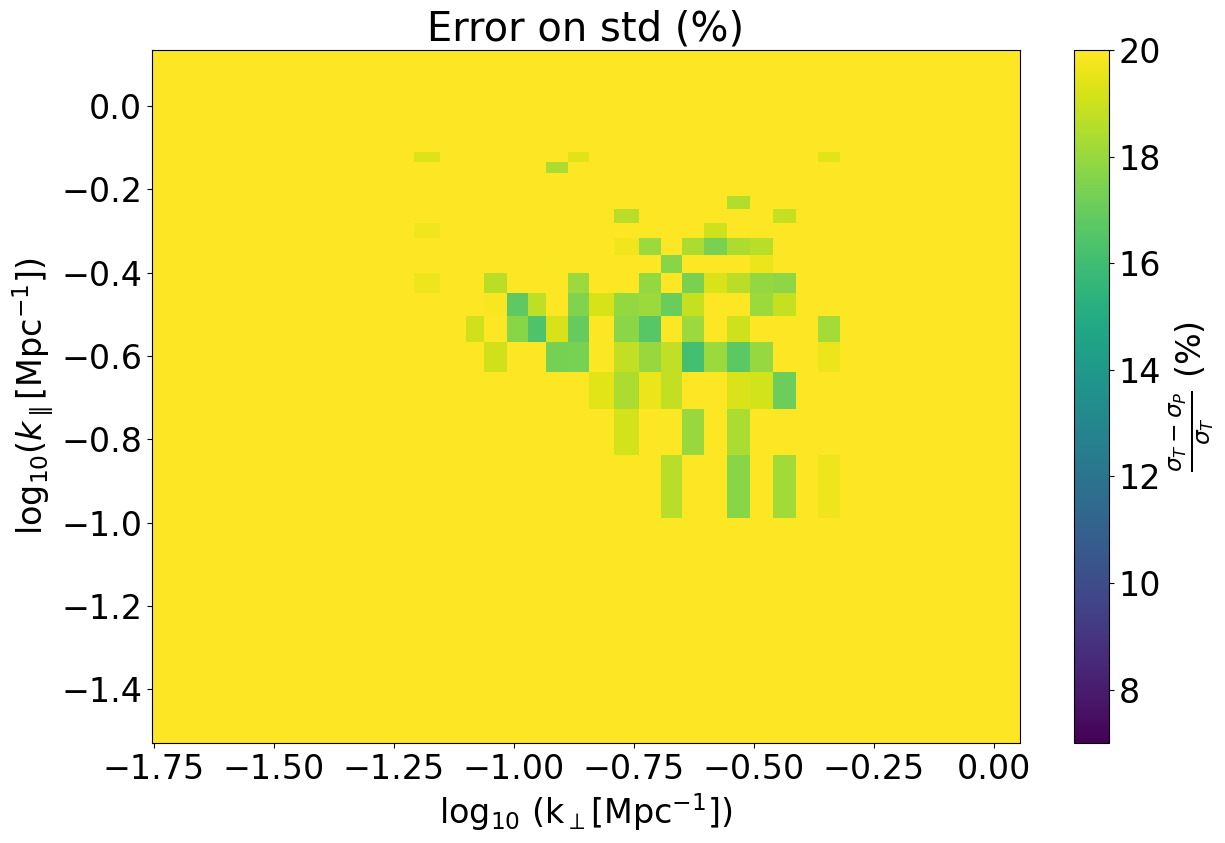

In [311]:
ffee = abs((std_pred - std_means) / std_means)
med_fe = np.nanmedian(ffee[m10], axis = 0)
imshow_error_2D(med_fe*100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on std (%)',
             vmin = 7., vmax = 20., label = r'$\frac{\sigma_T - \sigma_P}{\sigma_T}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

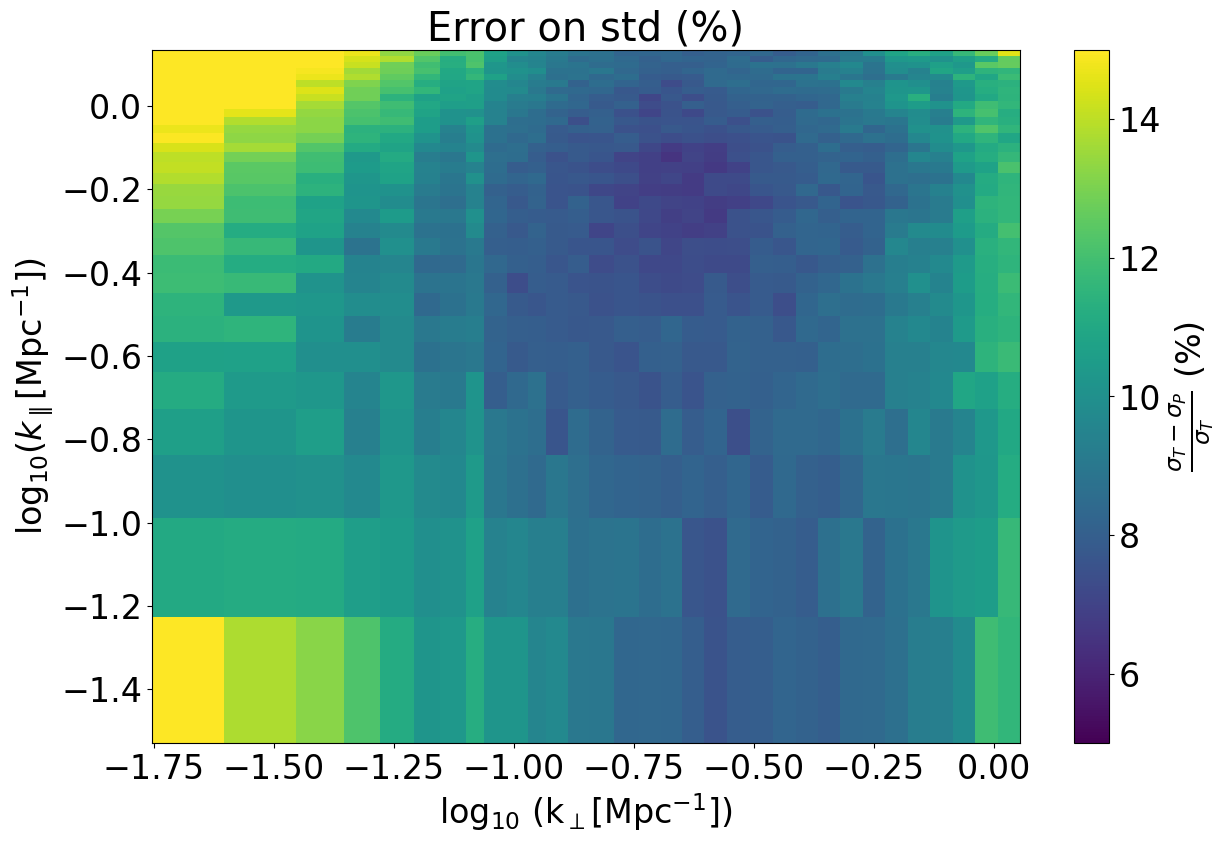

In [63]:
ffee = abs((std_pred - std_means[idx]) / std_means[idx])
med_fe = np.nanmedian(ffee[m7], axis = 0)
imshow_error_2D(med_fe*100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on std (%)',
             vmin = 5., vmax = 15., label = r'$\frac{\sigma_T - \sigma_P}{\sigma_T}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

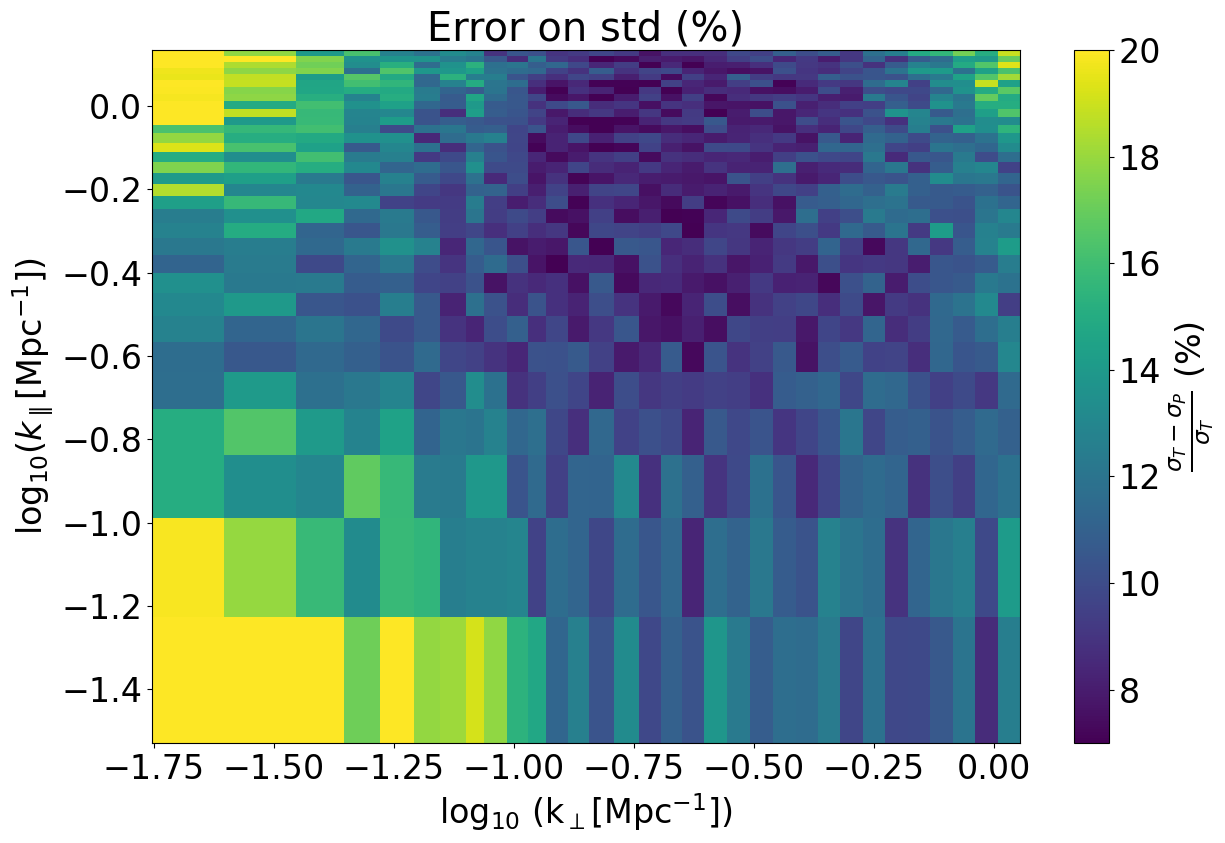

In [29]:
ffee = abs((std_pred - std_means) / std_means)
med_fe = np.nanmedian(ffee[m10], axis = 0)
imshow_error_2D(med_fe*100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on std (%)',
             vmin = 7., vmax = 20., label = r'$\frac{\sigma_T - \sigma_P}{\sigma_T}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

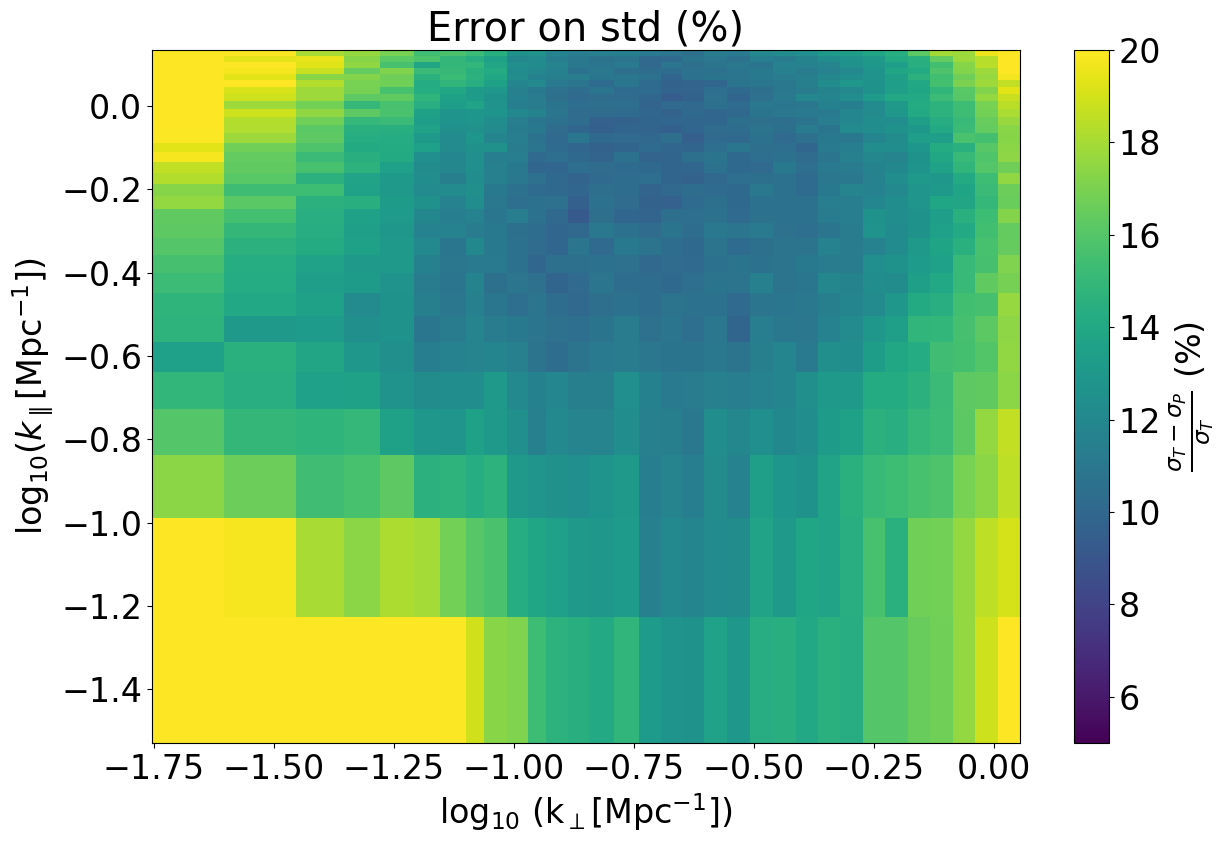

In [57]:
imshow_error_2D(med_fe*100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on std (%)',
             vmin = 5., vmax = 20., label = r'$\frac{\sigma_T - \sigma_P}{\sigma_T}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

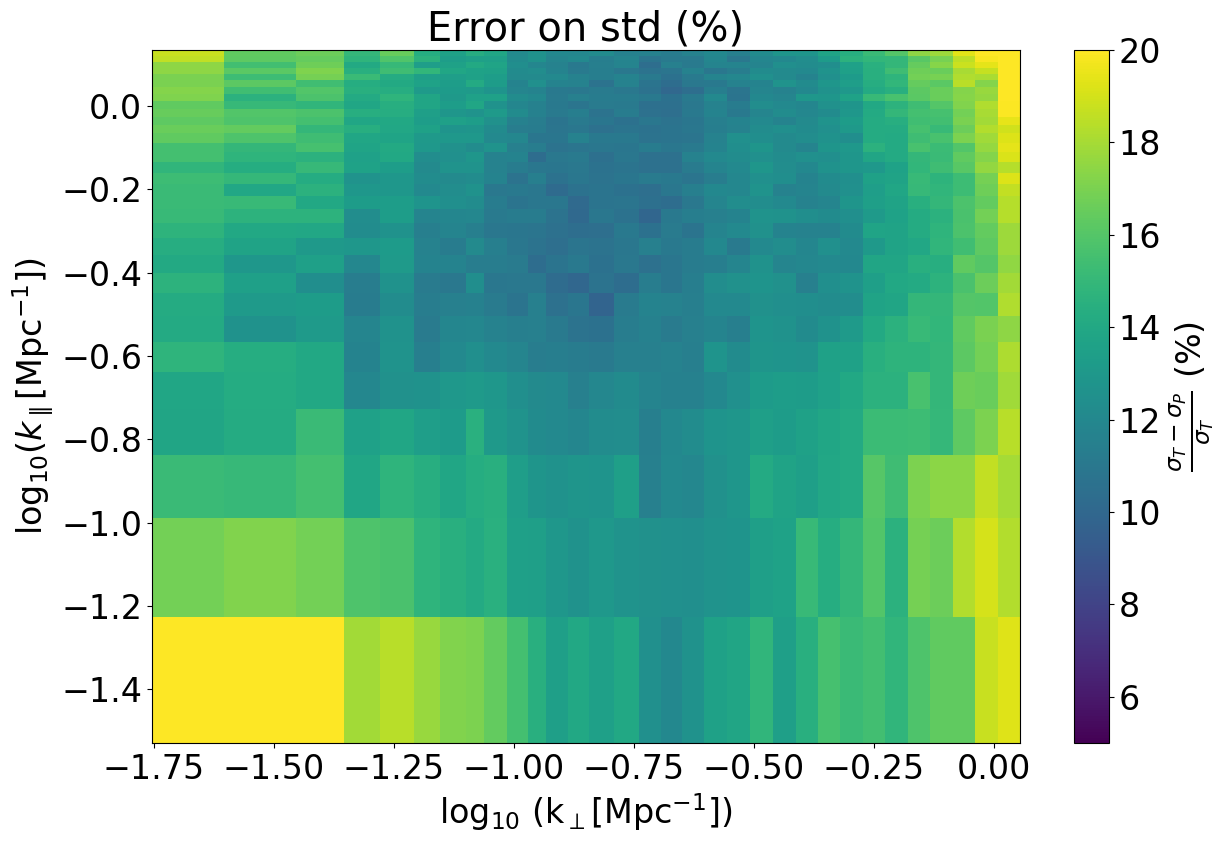

In [17]:
imshow_error_2D(med_fe*100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on std (%)',
             vmin = 5., vmax = 20., label = r'$\frac{\sigma_T - \sigma_P}{\sigma_T}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

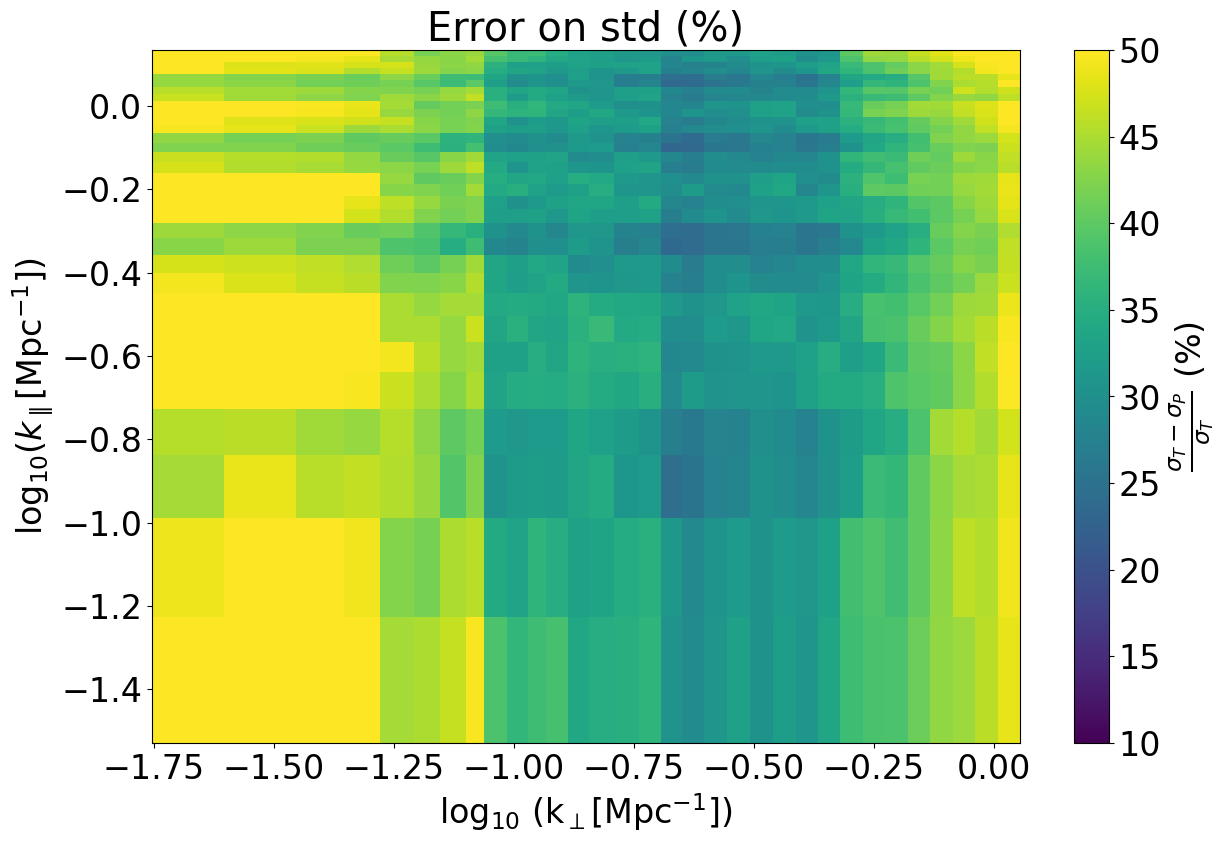

In [26]:
imshow_error_2D(med_fe*100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on std (%)',
             vmin = 10, vmax = 50., label = r'$\frac{\sigma_T - \sigma_P}{\sigma_T}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

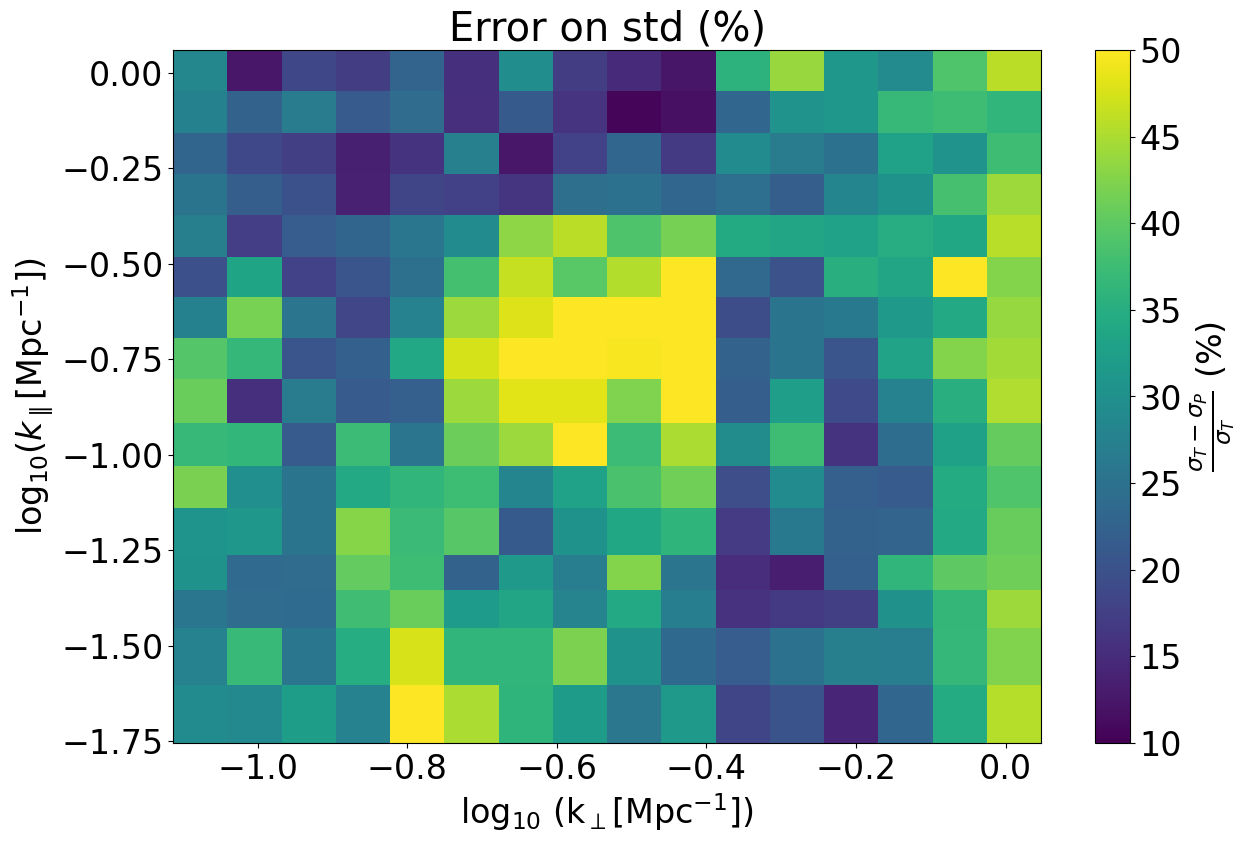

In [27]:
imshow_error_2D(med_fe*100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on std (%)',
             vmin = 10, vmax = 50., label = r'$\frac{\sigma_T - \sigma_P}{\sigma_T}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

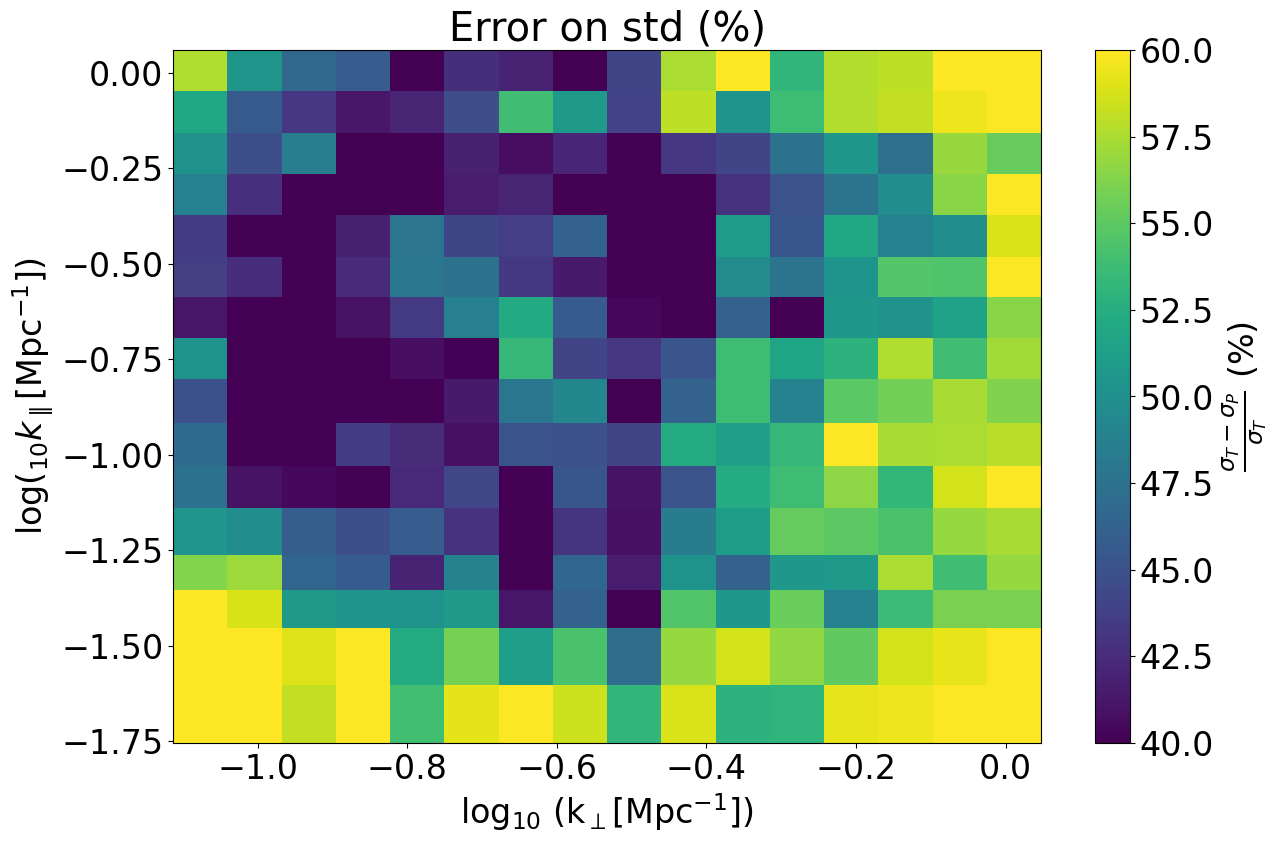

In [99]:
imshow_error_2D(med_fe*100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on std (%)',
             vmin = 40, vmax = 60., label = r'$\frac{\sigma_T - \sigma_P}{\sigma_T}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

In [153]:
ffee = abs((mean_pred - ps_data[...,1]) / ps_data[...,1])
med_fe = np.nanmedian(ffee, axis = 0)

In [28]:
np.nanmean(ffee)*100., np.nanmedian(ffee)*100.

(56.39308492328647, 21.34823806903559)

In [59]:
np.nanmean(ffee)*100., np.nanmedian(ffee)*100.

(19.639088938525312, 7.7443389036431585)

In [107]:
w = np.ones((len(kperp), len(kpar)))
w[0,:5] = 4.
w[1,:4] = 4.
w[2,:4] = 4.
w[3,:4] = 4.
w[4,:3] = 4.
w[5,:2] = 4.
w[:9,0] = 4.

w[-6:,0] = 2.
w[-5:,1] = 2.
w[-3:,2] = 2.
w[-2:,3] = 2.

w[0,-20:] = 3.
w[1,-15:] = 3.
w[2,-8:] = 3.
w[3,-5:] = 3.
w[4,-3:] = 3.

w[-1,-10:] = 3.
w[-2,-3:] = 3.

#w = torch.Tensor(w).to(DEVICE, dtype=torch.float64)

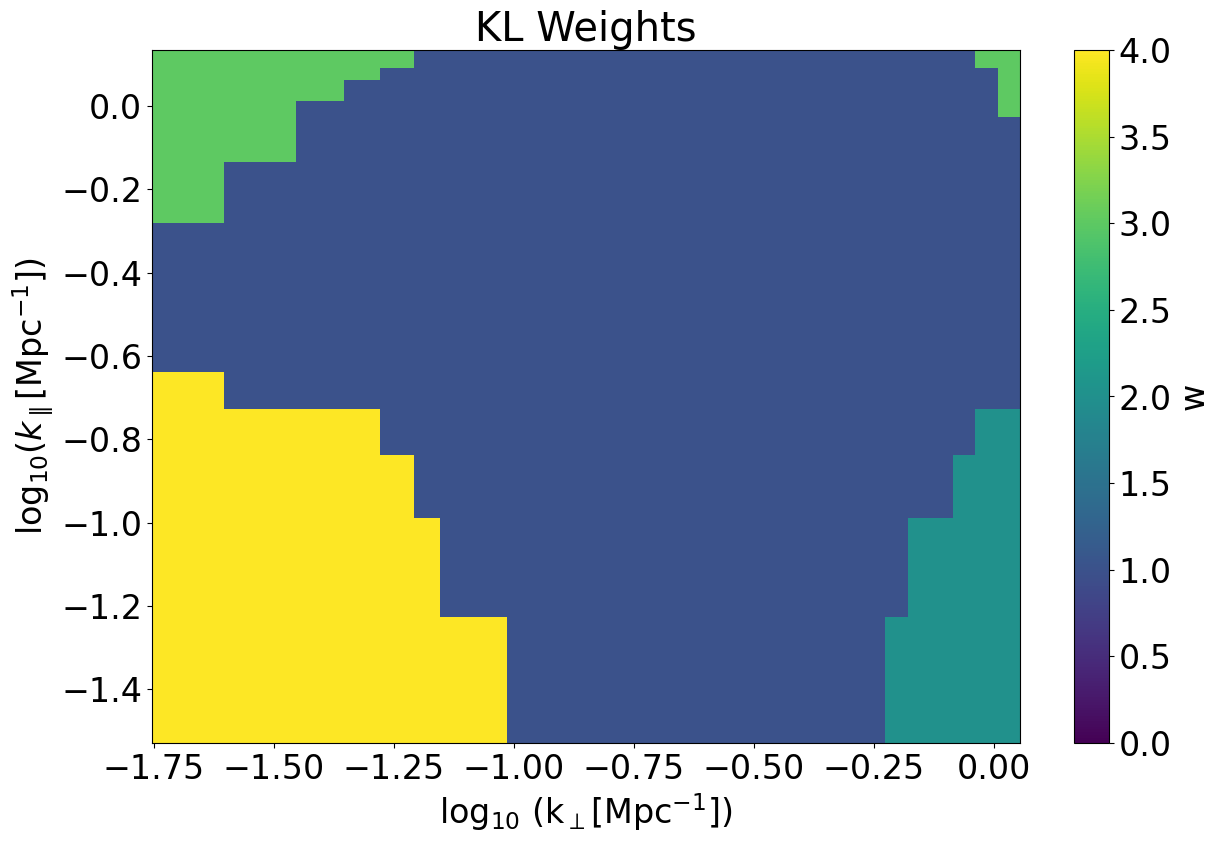

In [109]:
imshow_error_2D(w, xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'KL Weights',
             vmin = 0, vmax = 4., label = r'w', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

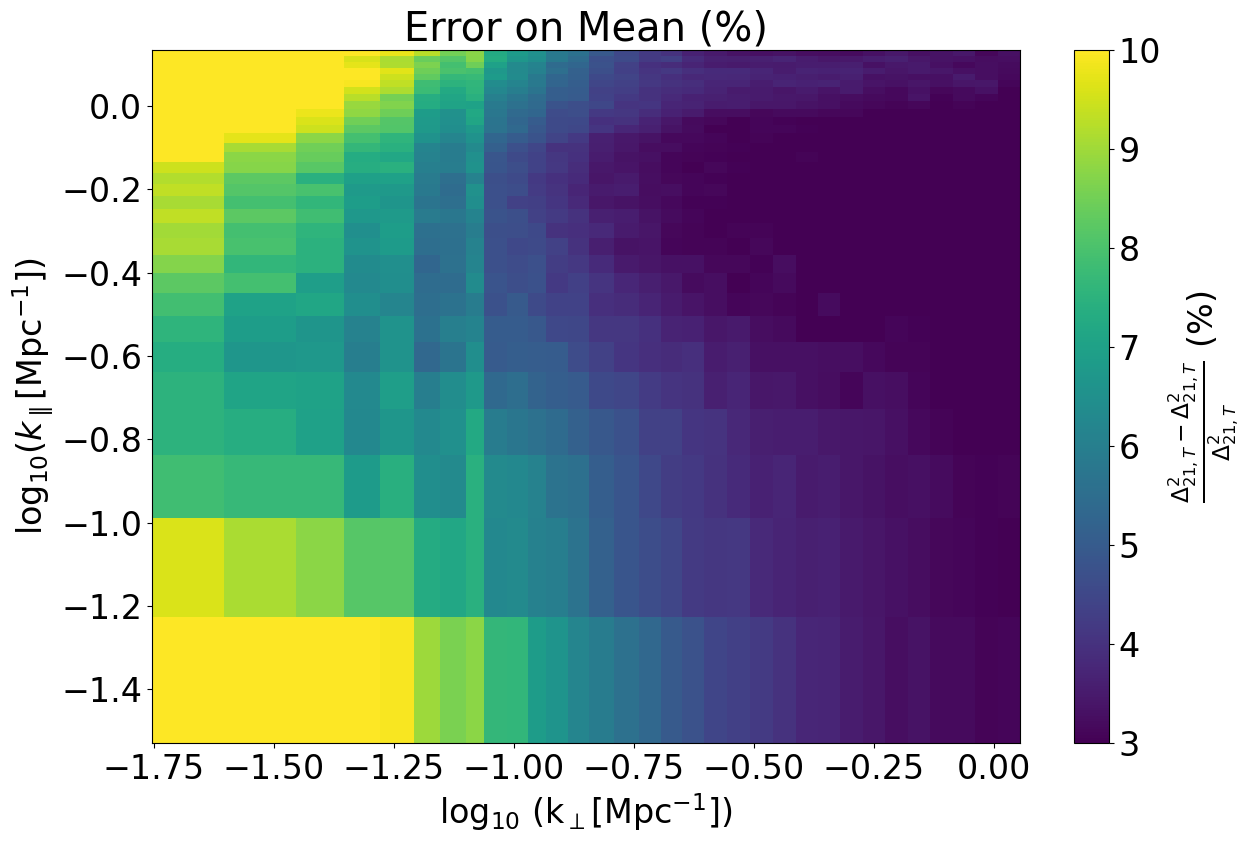

In [67]:
ffee = abs((mean_pred - means[idx]) / means[idx])
med_fe = np.nanmedian(ffee[m10], axis = 0)
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 3, vmax = 10., label = r'$\frac{\Delta_{21,T}^2 - \Delta_{21,T}^2}{\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

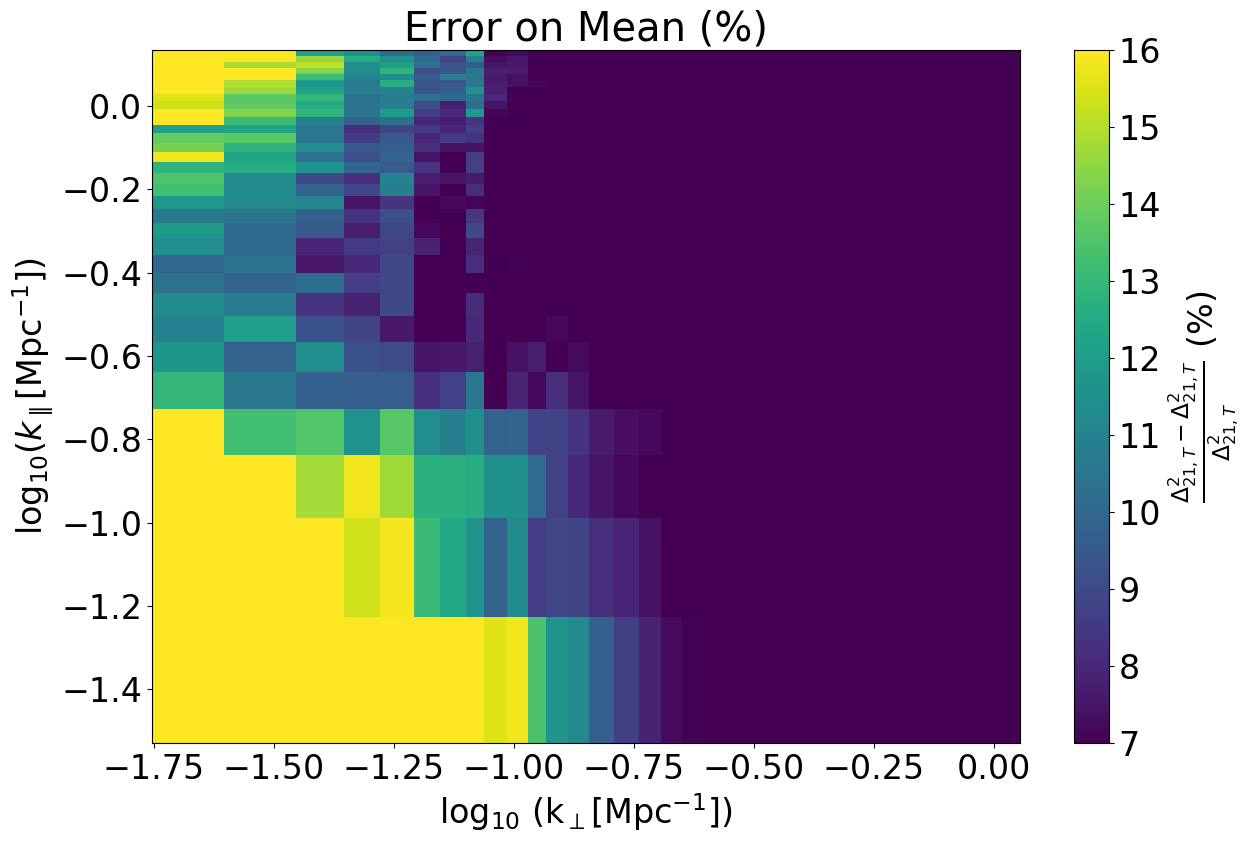

In [45]:
ffee = abs((mean_pred - ps_data[...,1]) / ps_data[...,1])
med_fe = np.nanmedian(ffee[m10], axis = 0)
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 7, vmax = 16., label = r'$\frac{\Delta_{21,T}^2 - \Delta_{21,T}^2}{\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

In [43]:
np.median(med_fe[8:,:])

0.04770494783071175

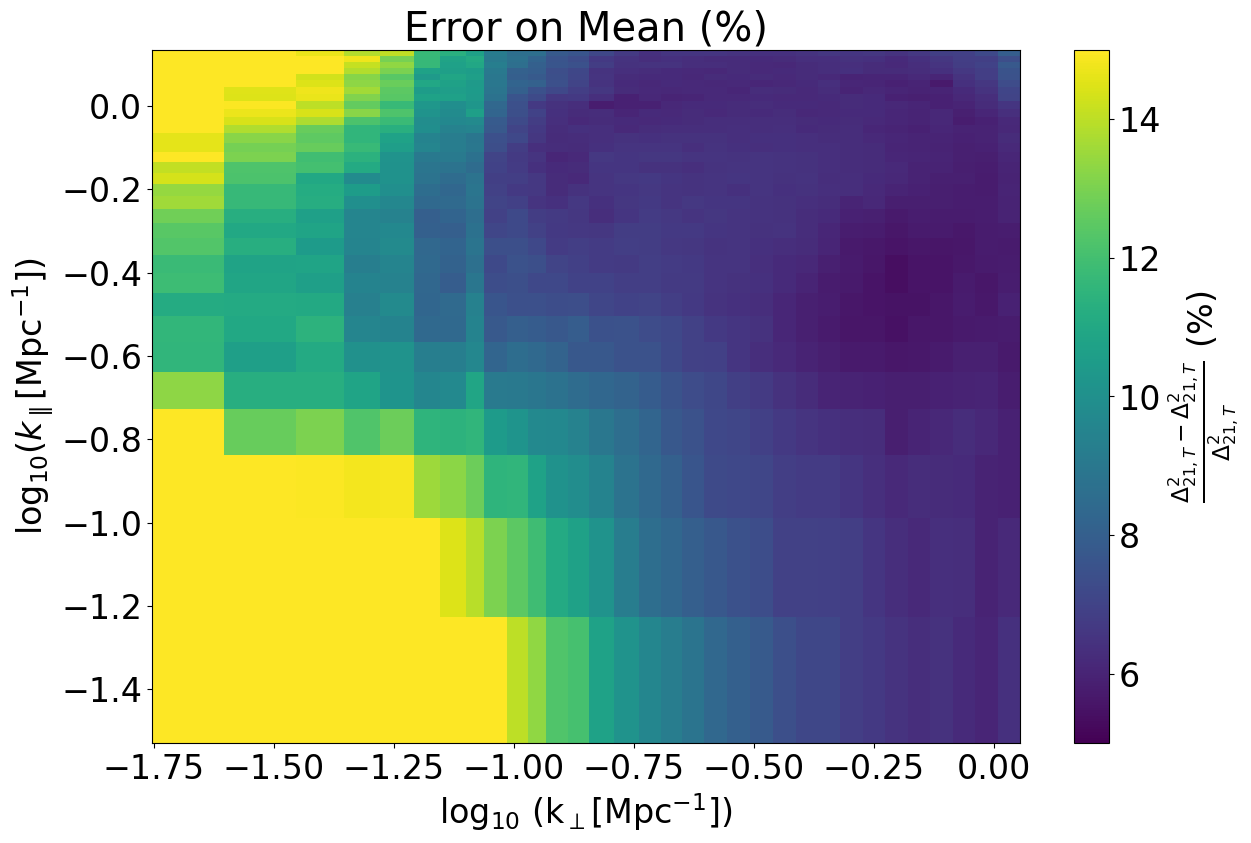

In [60]:
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 5, vmax = 15., label = r'$\frac{\Delta_{21,T}^2 - \Delta_{21,T}^2}{\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

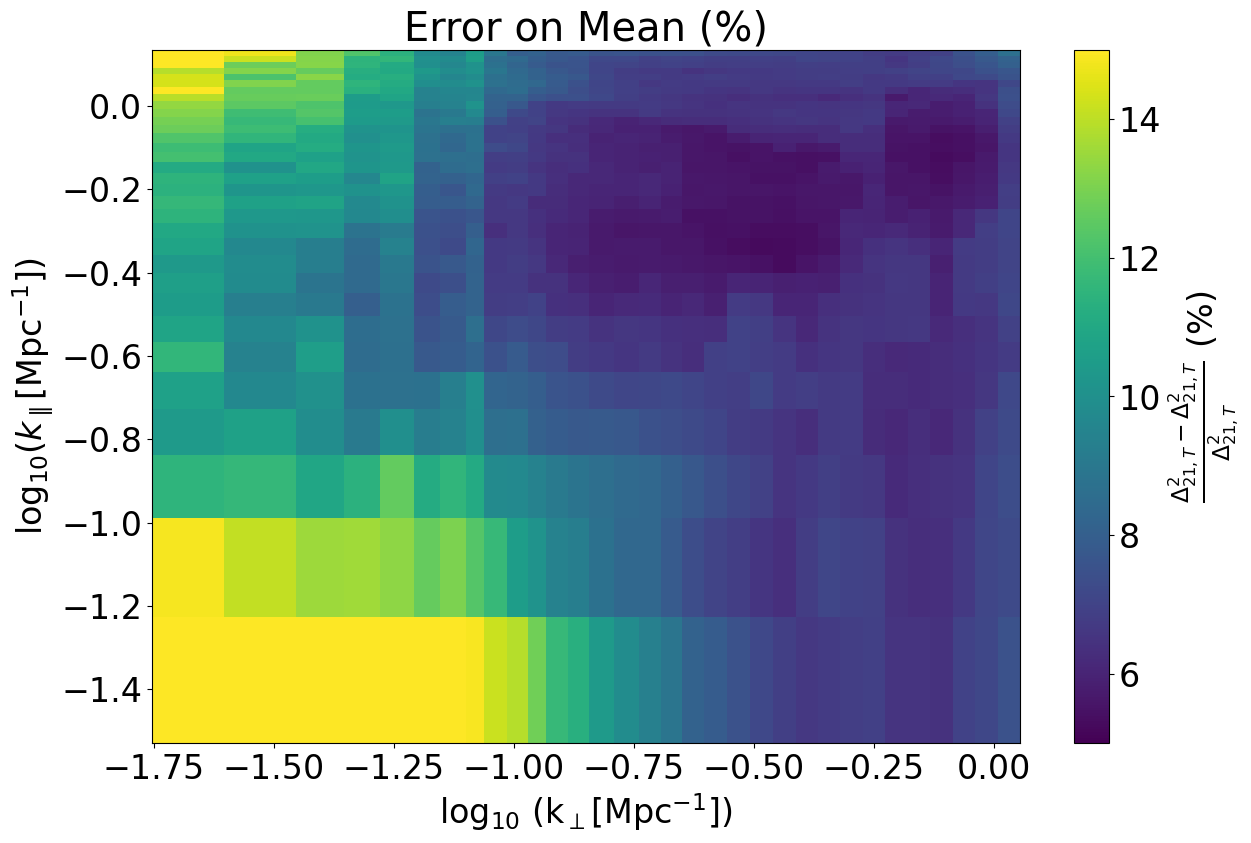

In [26]:
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 5, vmax = 15., label = r'$\frac{\Delta_{21,T}^2 - \Delta_{21,T}^2}{\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

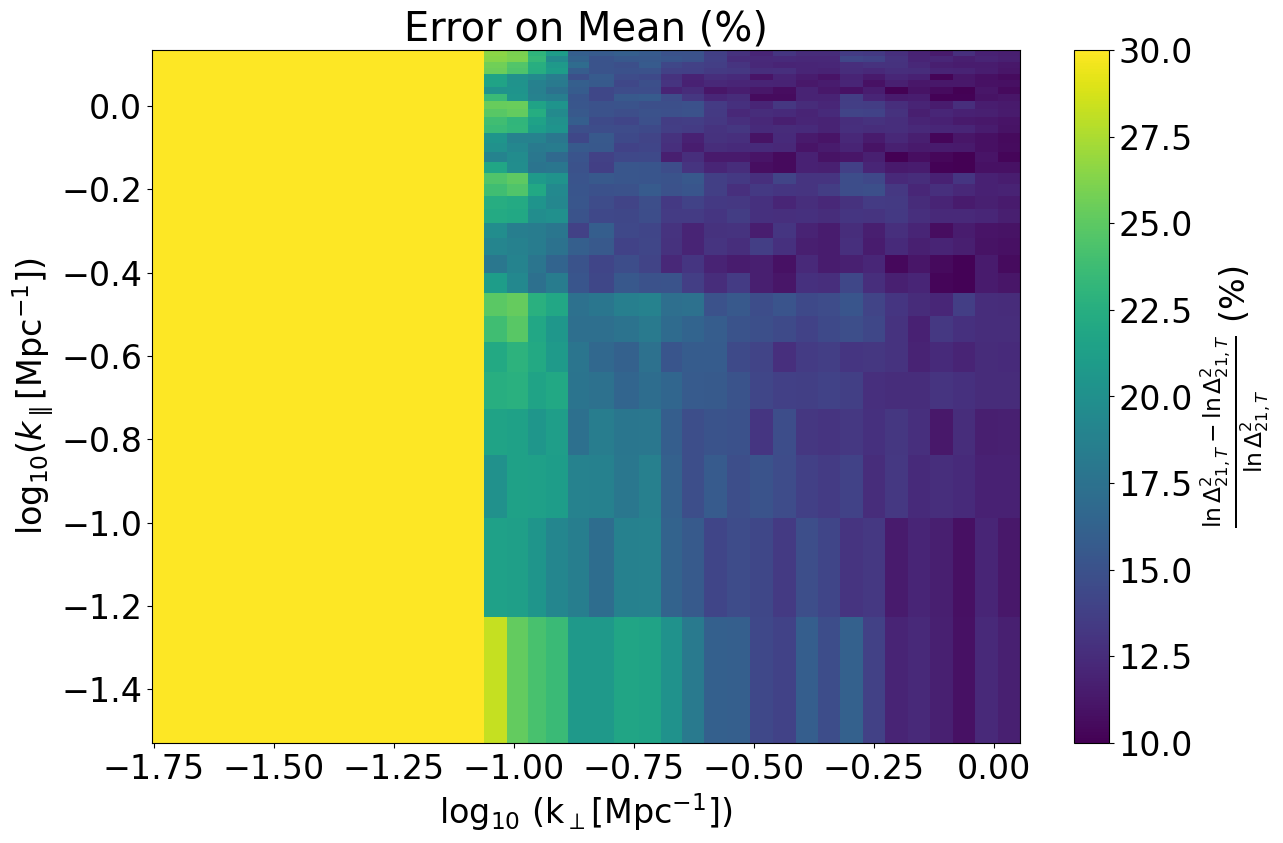

In [32]:
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 10, vmax = 30., label = r'$\frac{\ln\Delta_{21,T}^2 - \ln\Delta_{21,T}^2}{\ln\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

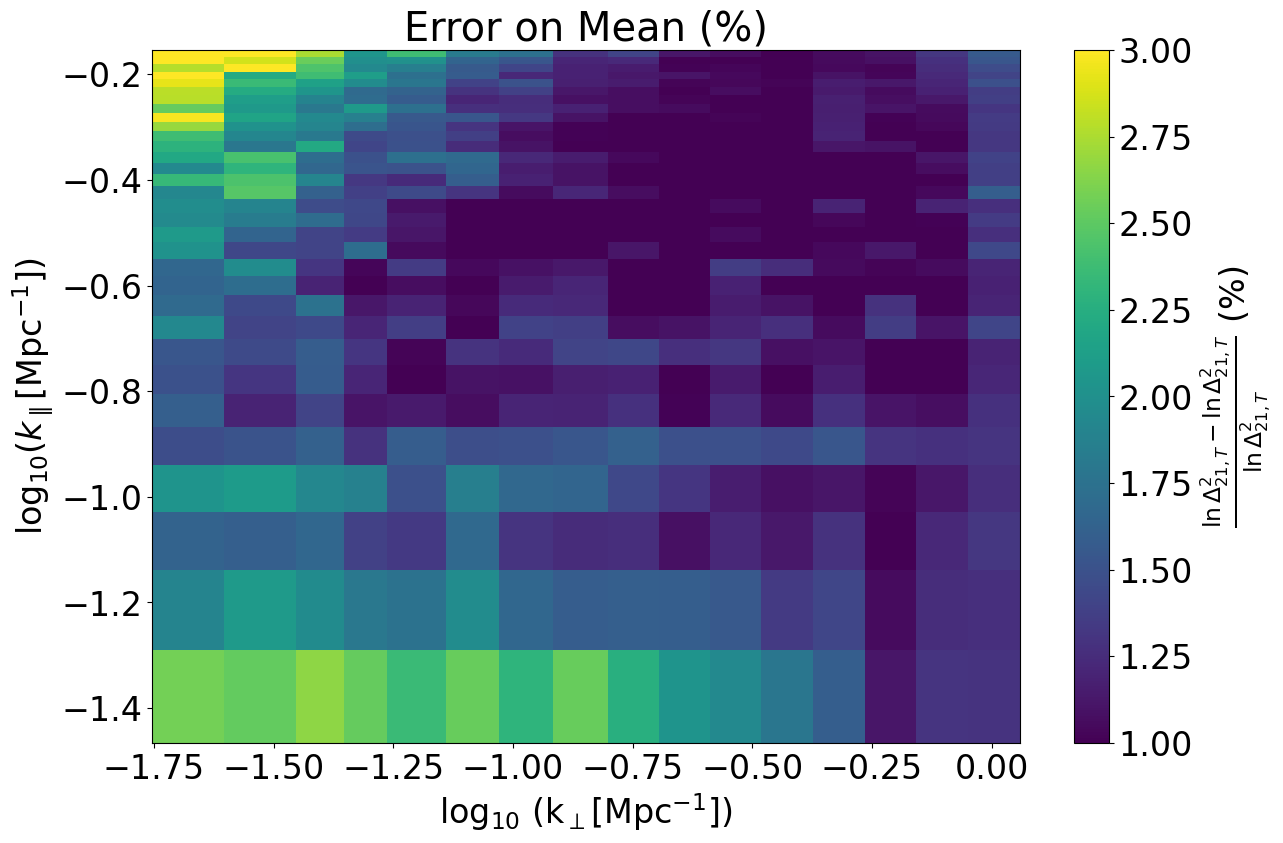

In [79]:
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 1, vmax = 3., label = r'$\frac{\ln\Delta_{21,T}^2 - \ln\Delta_{21,T}^2}{\ln\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

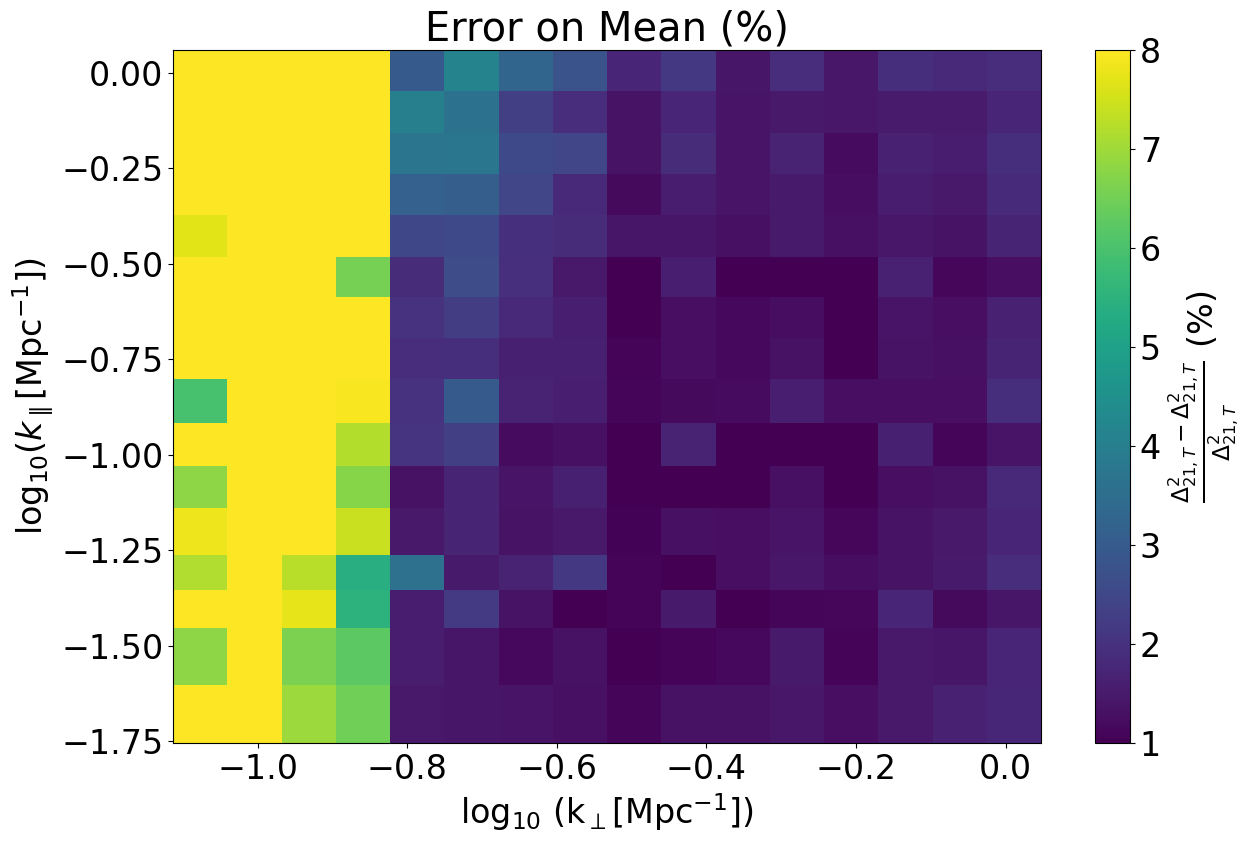

In [91]:
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 1, vmax = 8., label = r'$\frac{\Delta_{21,T}^2 - \Delta_{21,T}^2}{\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

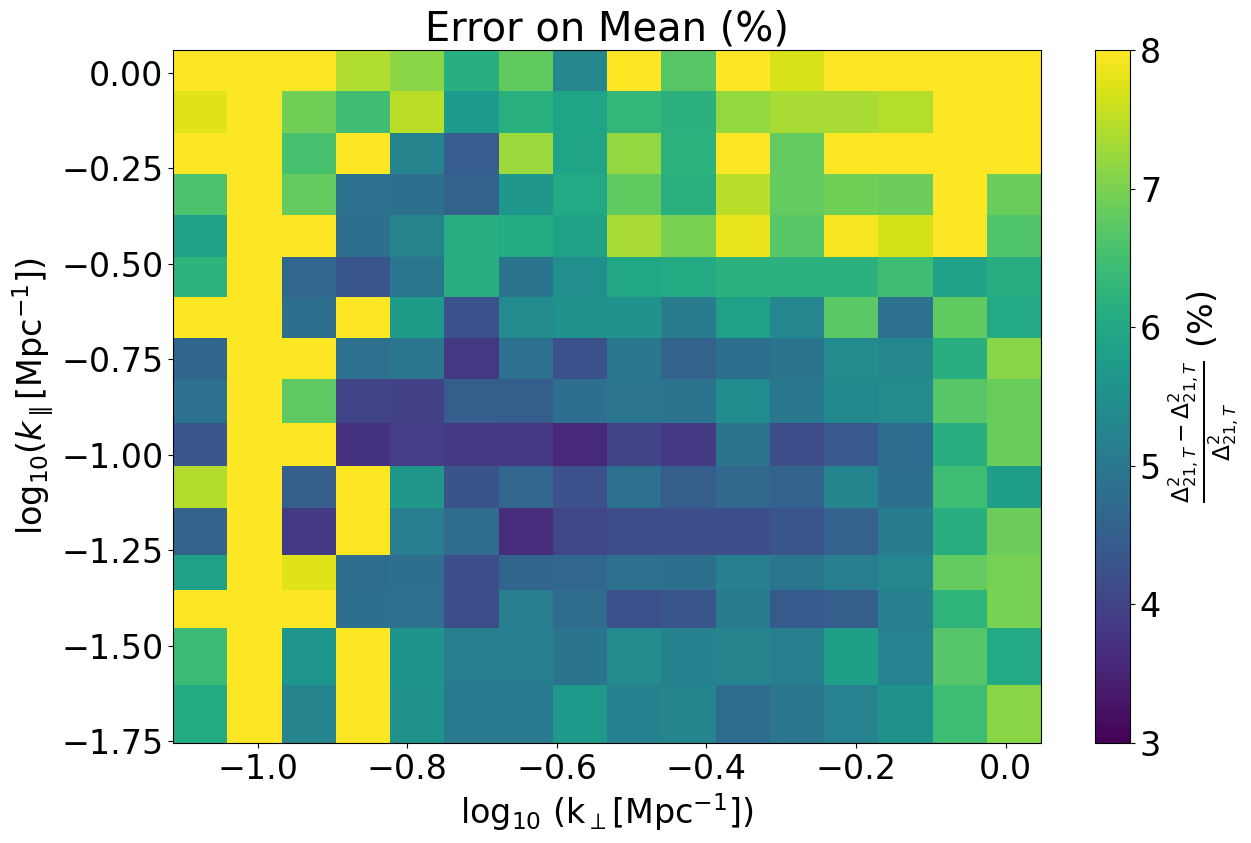

In [42]:
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 3, vmax = 8., label = r'$\frac{\Delta_{21,T}^2 - \Delta_{21,T}^2}{\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

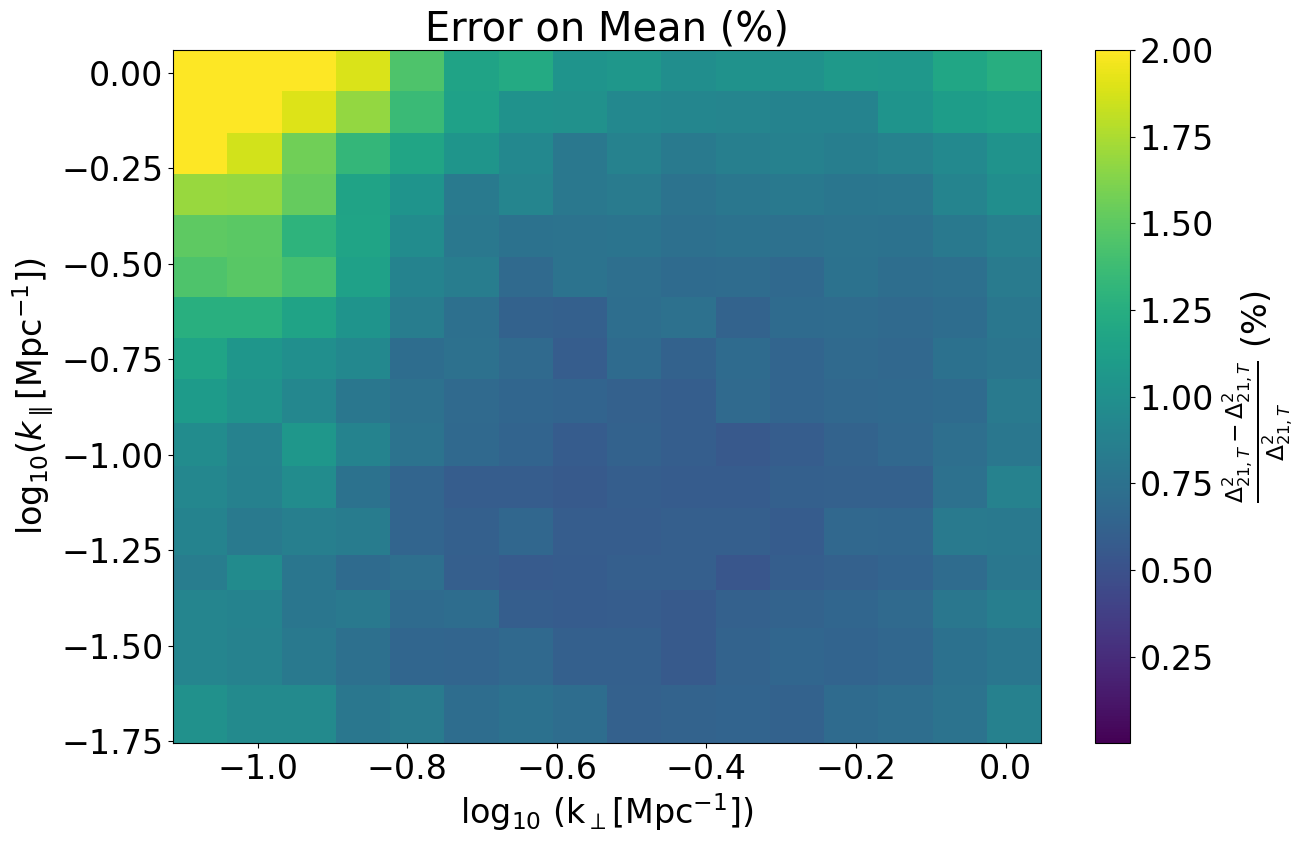

In [50]:
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 1e-3, vmax = 2., label = r'$\frac{\Delta_{21,T}^2 - \Delta_{21,T}^2}{\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

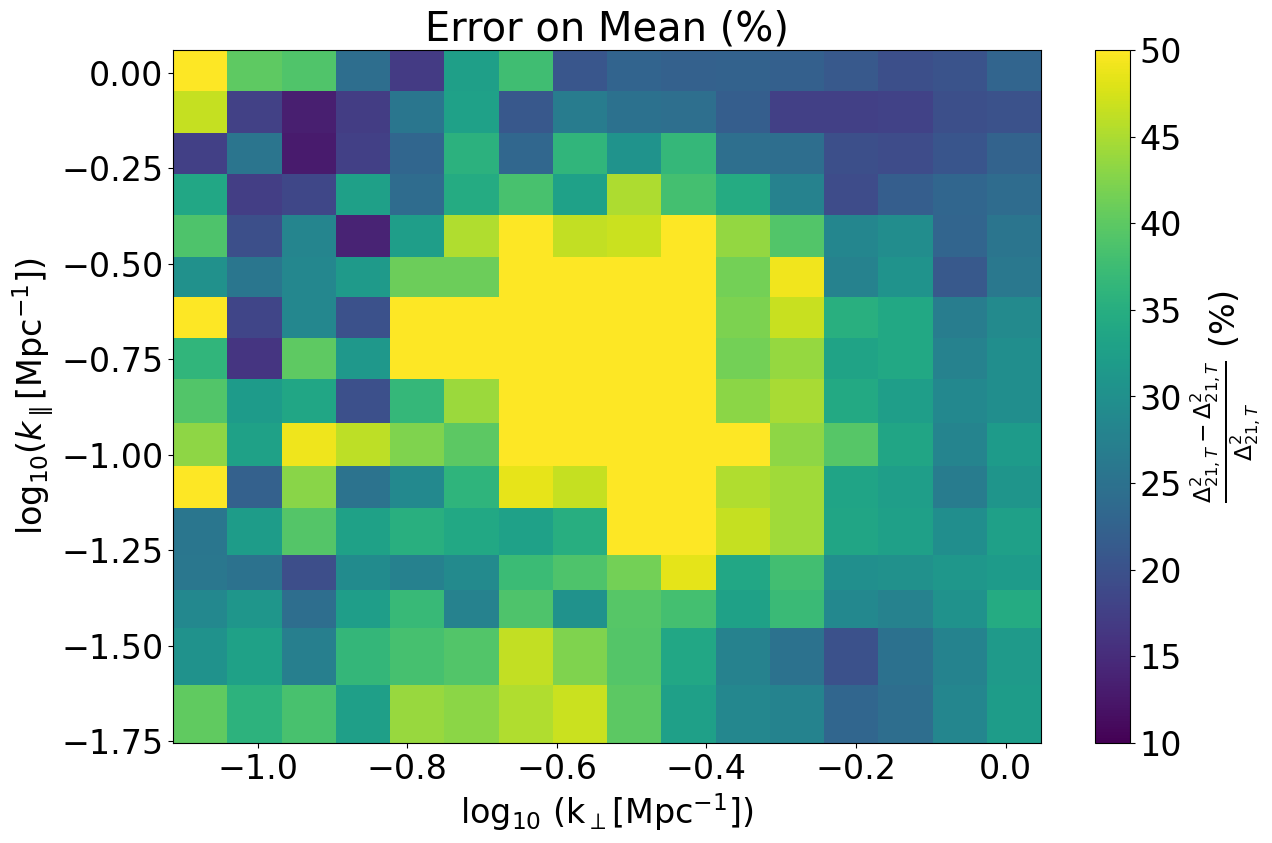

In [19]:
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 10., vmax = 50., label = r'$\frac{\Delta_{21,T}^2 - \Delta_{21,T}^2}{\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

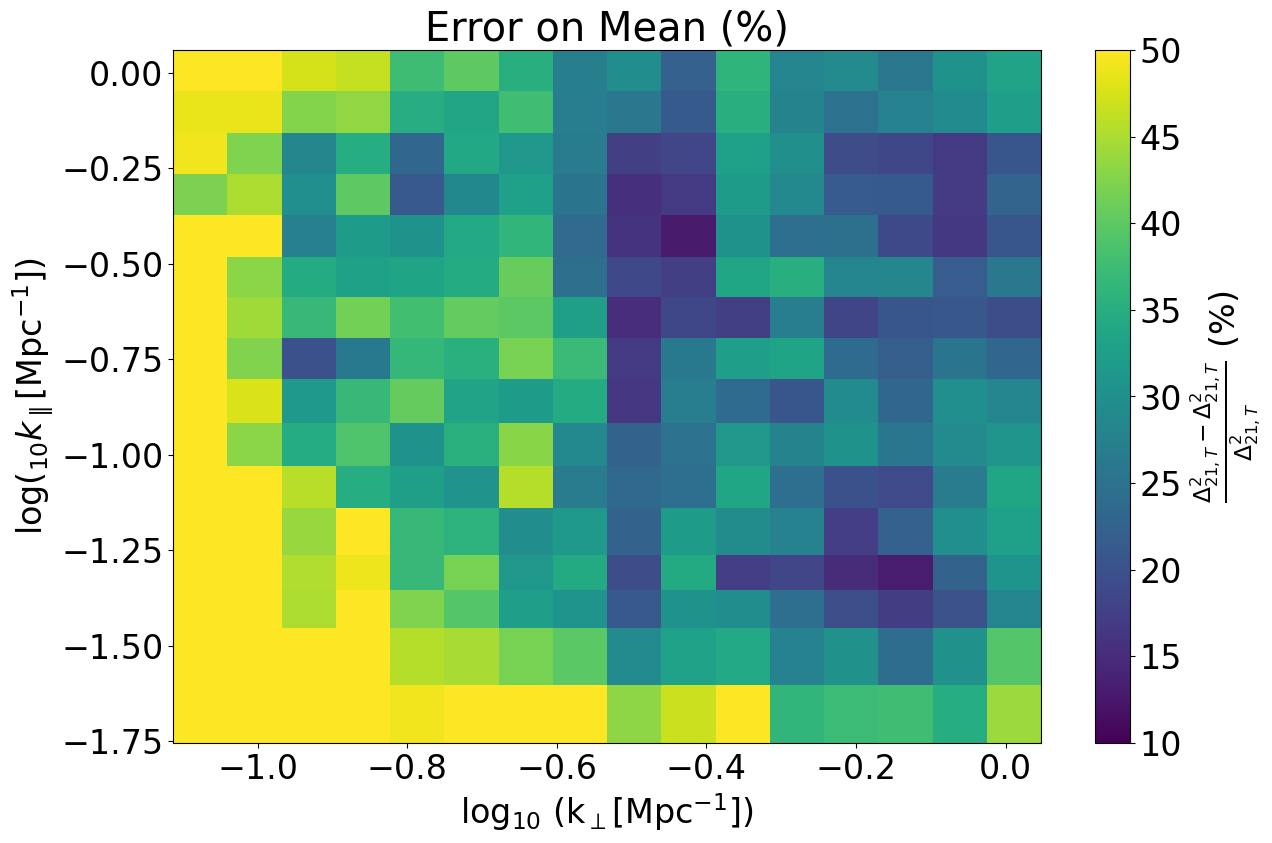

In [104]:
imshow_error_2D(med_fe * 100., xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title1 = 'Error on Mean (%)',
             vmin = 10., vmax = 50., label = r'$\frac{\Delta_{21,T}^2 - \Delta_{21,T}^2}{\Delta_{21,T}^2}$ (%)', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

In [68]:
N = 2378

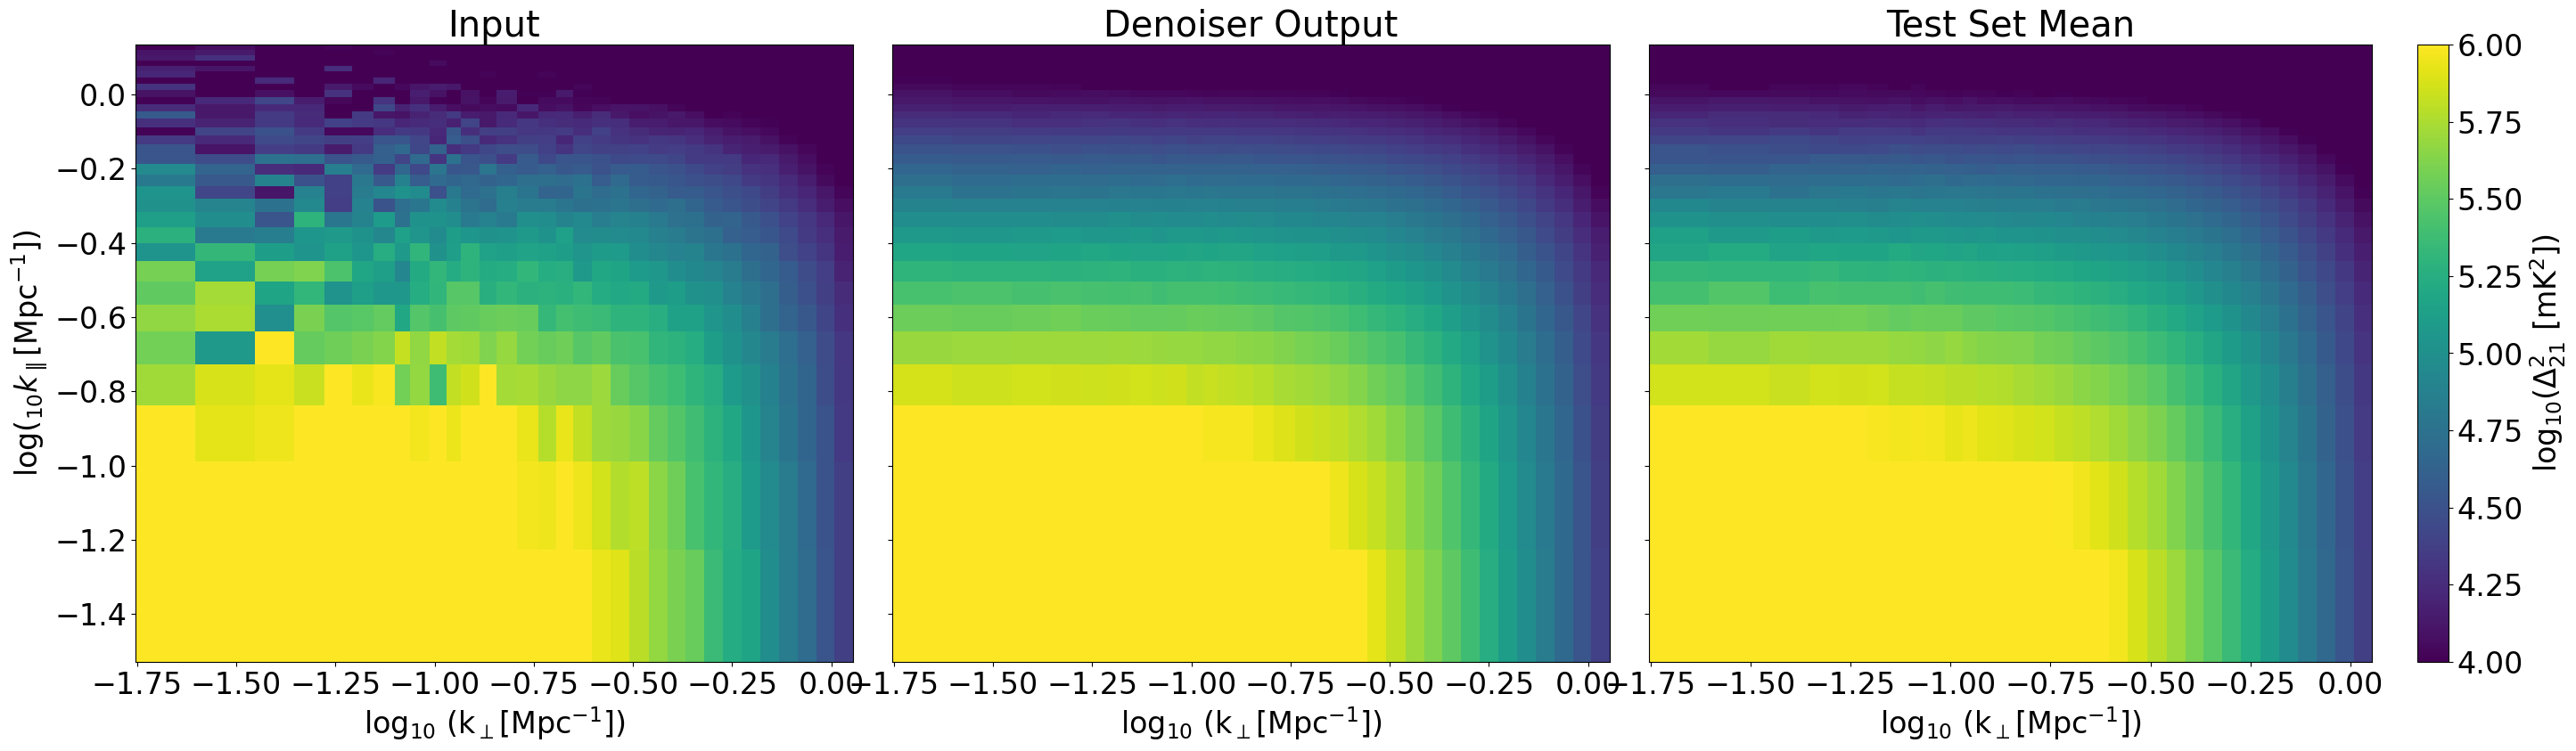

In [72]:
N = 2
imshow_error_2D(np.log10(mean_pred[N,...]), truthmean = np.log10(means[idx][N,...]), 
             truthCV = np.log10(seeds[idx][N,...]), xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = 4, vmax = 6, label = r'log$_{10}(\Delta^2_{21}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

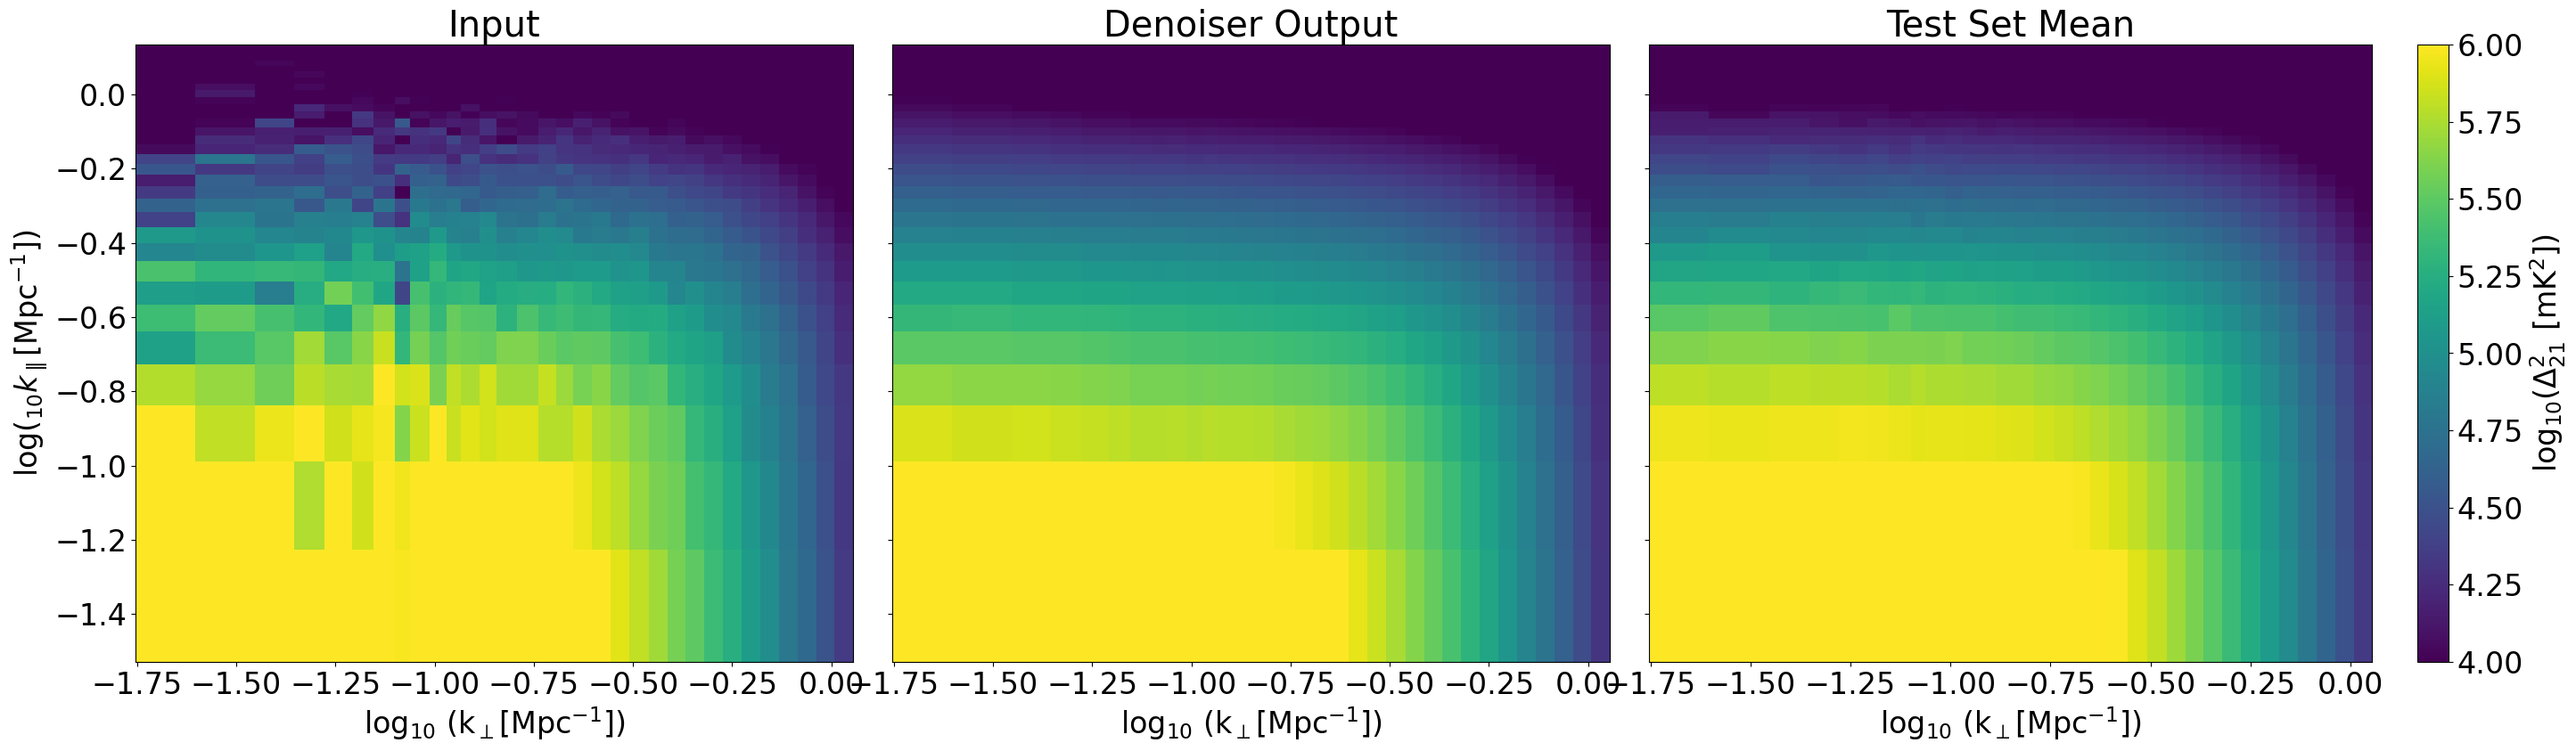

In [24]:
imshow_error_2D(np.log10(mean_pred[N,...]), truthmean = np.log10(ps_data[N,...,1]), 
             truthCV = np.log10(ps_data[N,...,0]), xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = 4, vmax = 6, label = r'log$_{10}(\Delta^2_{21}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

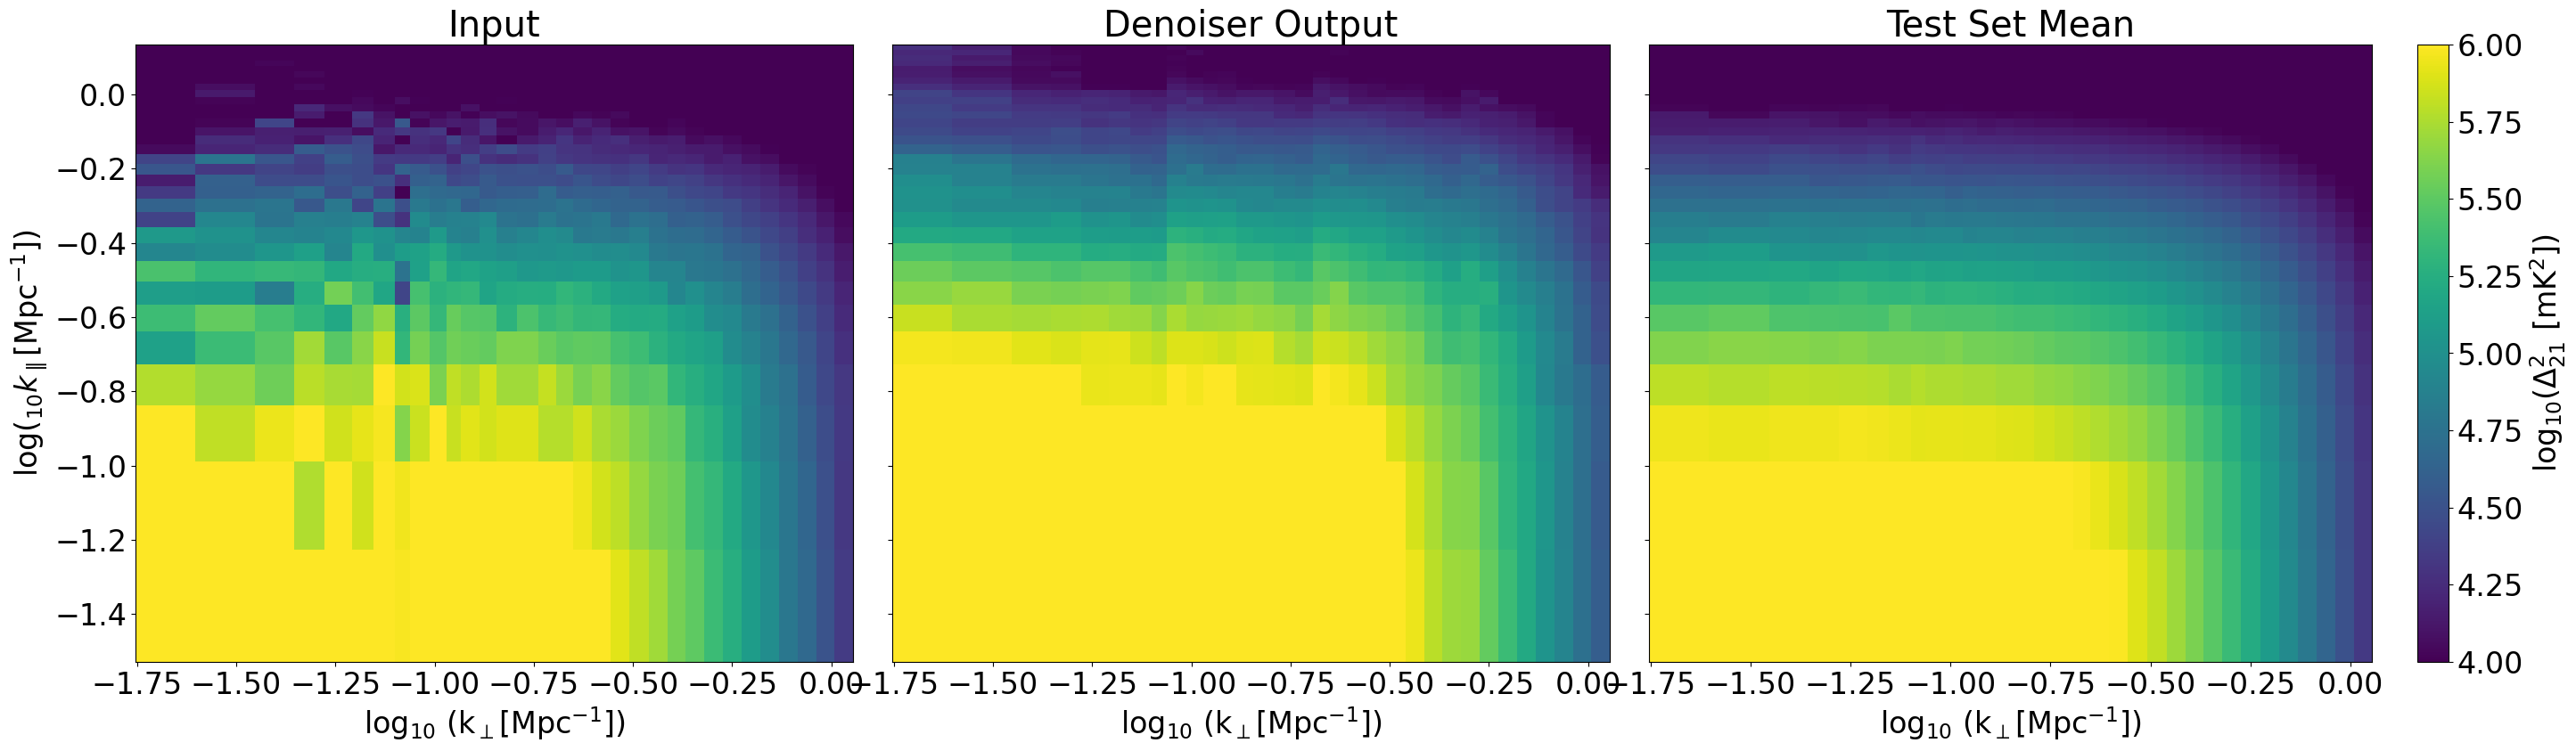

In [34]:
imshow_error_2D(np.log10(mean_pred[N,...]), truthmean = np.log10(ps_data[N,...,1]), 
             truthCV = np.log10(ps_data[N,...,0]), xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = 4, vmax = 6, label = r'log$_{10}(\Delta^2_{21}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

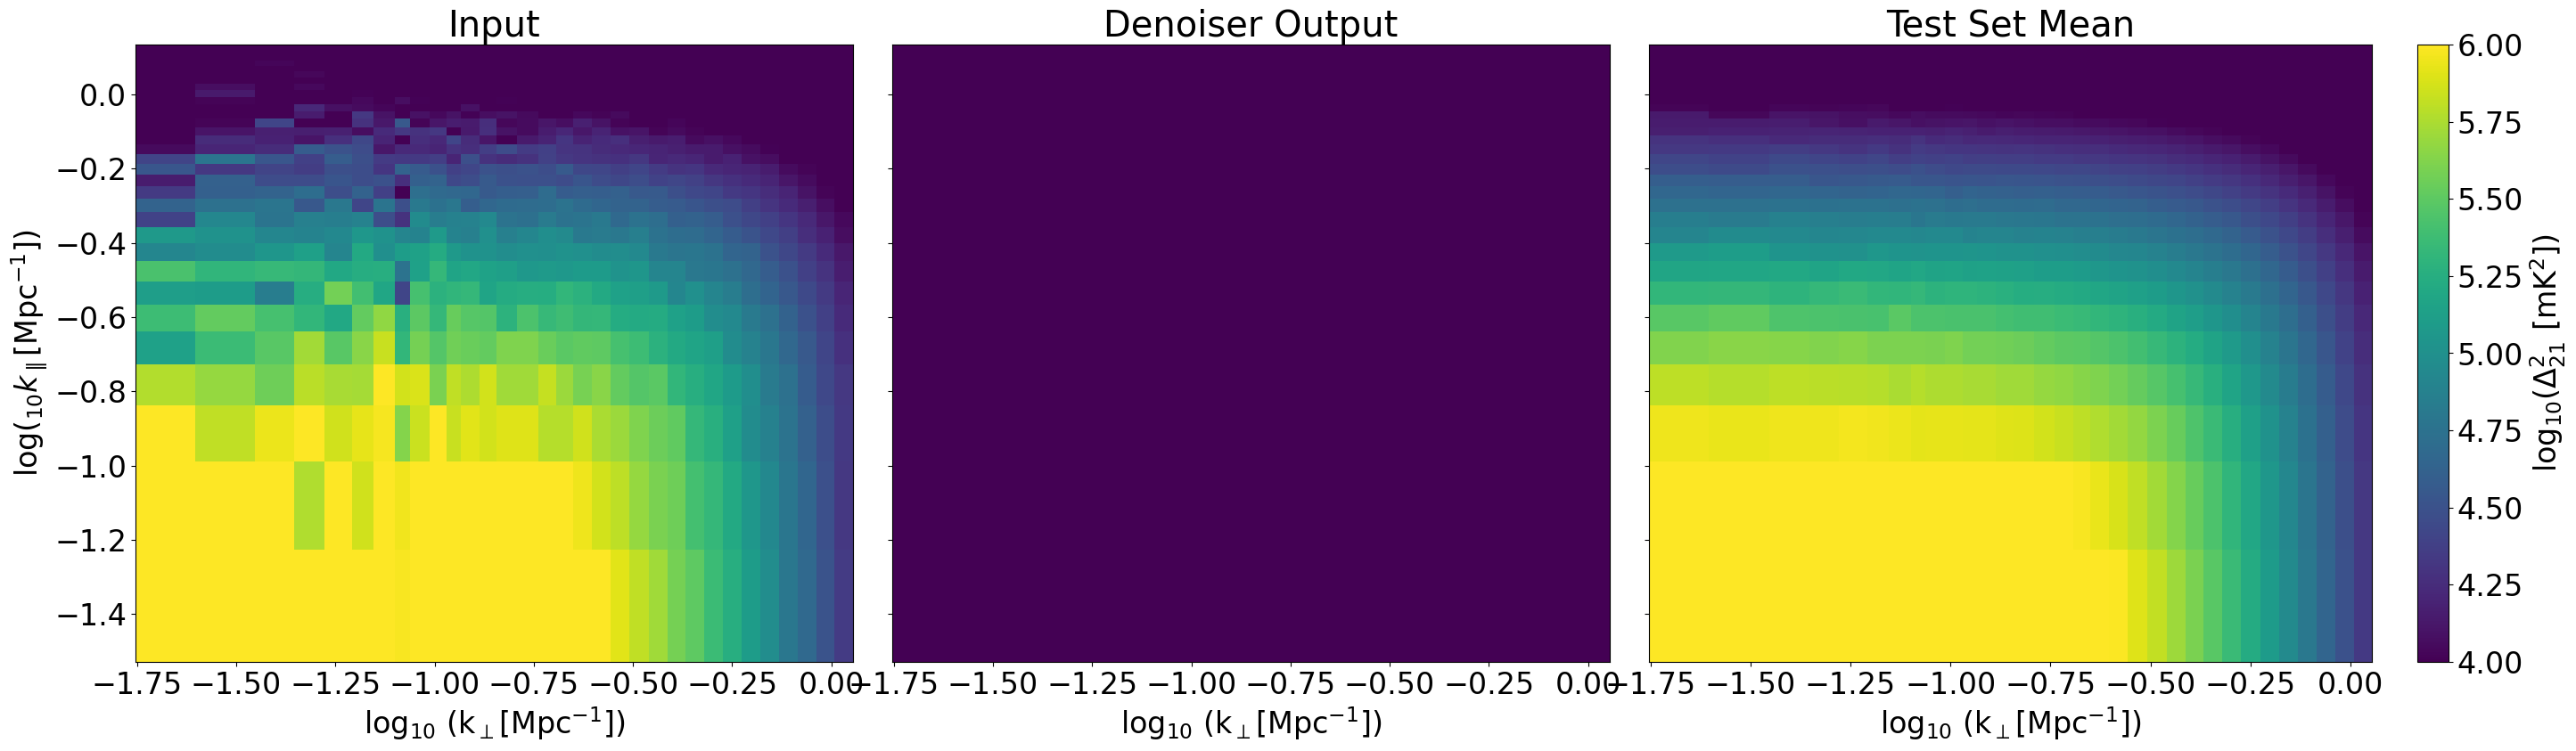

In [76]:
imshow_error_2D(np.log10(mean_pred[N,...]), truthmean = np.log10(ps_data[N,...,1]), 
             truthCV = np.log10(ps_data[N,...,0]), xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = 4, vmax = 6, label = r'log$_{10}(\Delta^2_{21}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

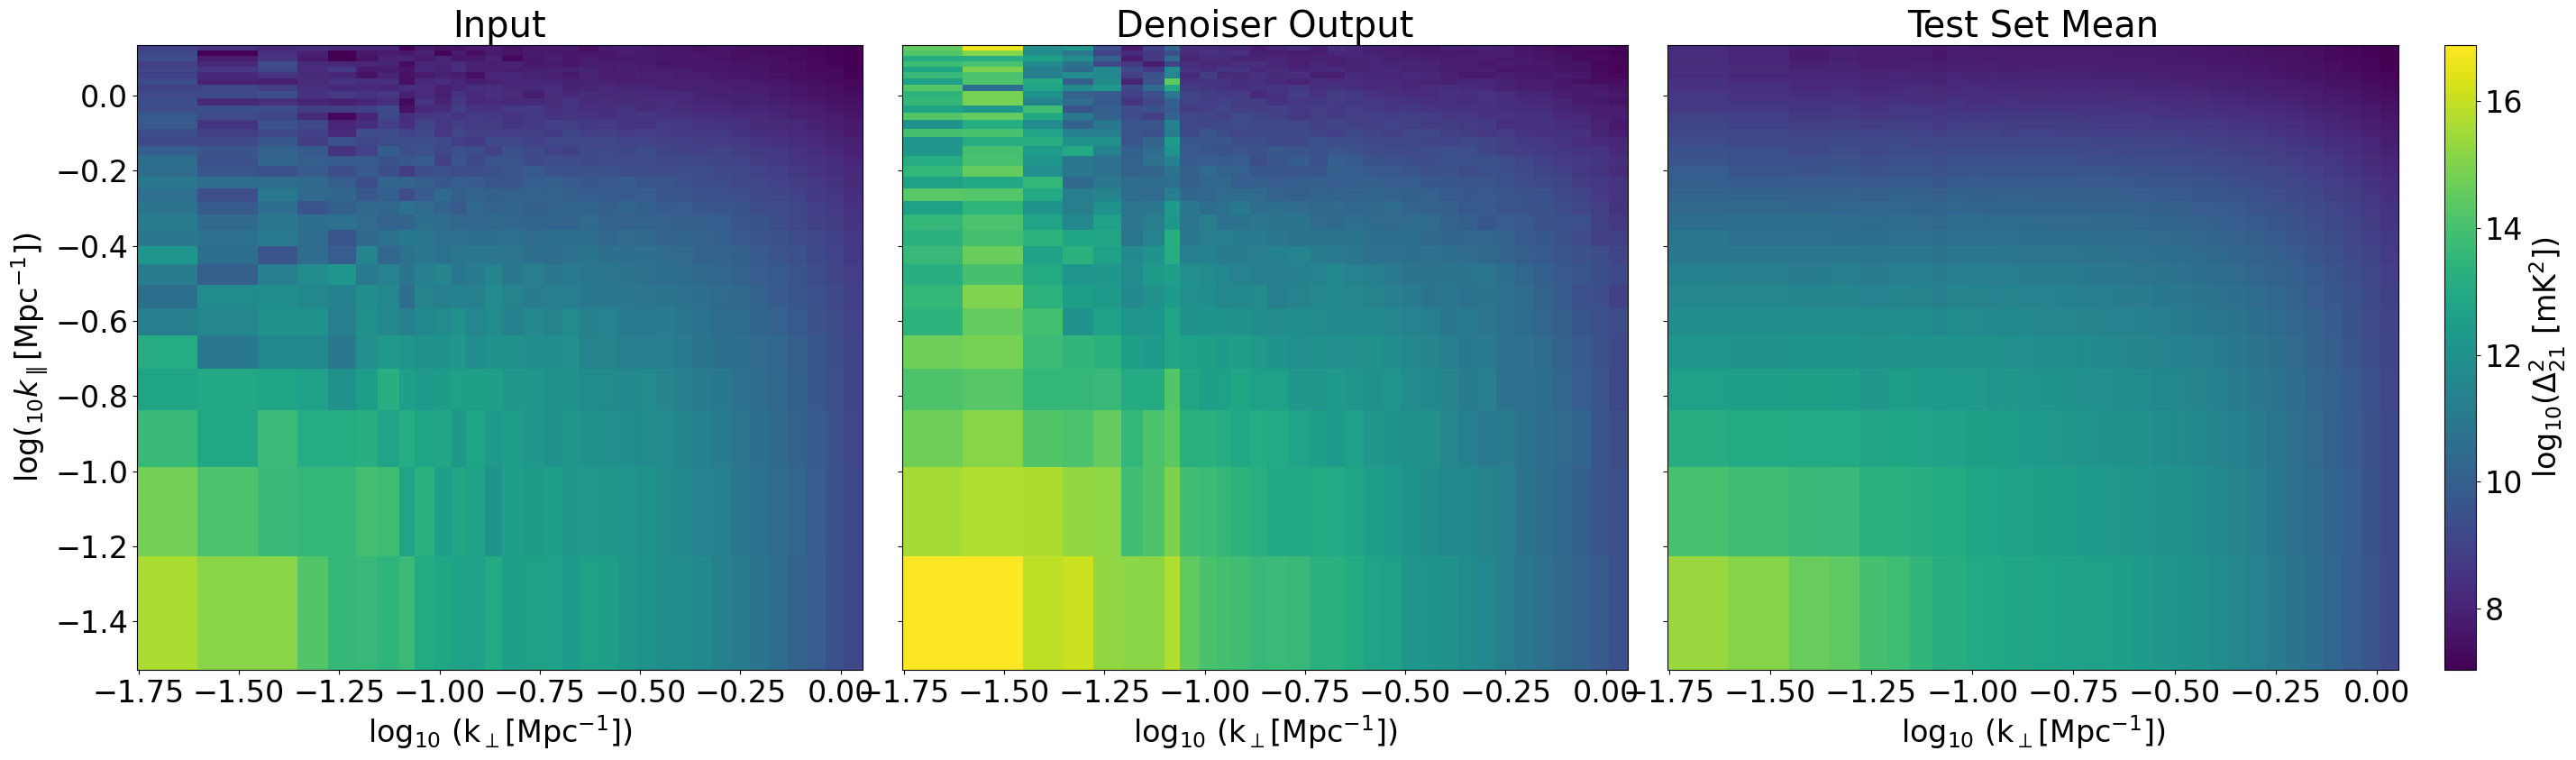

In [40]:
imshow_error_2D(mean_pred[N,...], truthmean = ps_data[N,...,1], 
             truthCV = ps_data[N,...,0], xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = mean_pred[N,...].min(), vmax = mean_pred[N,...].max(), label = r'log$_{10}(\Delta^2_{21}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

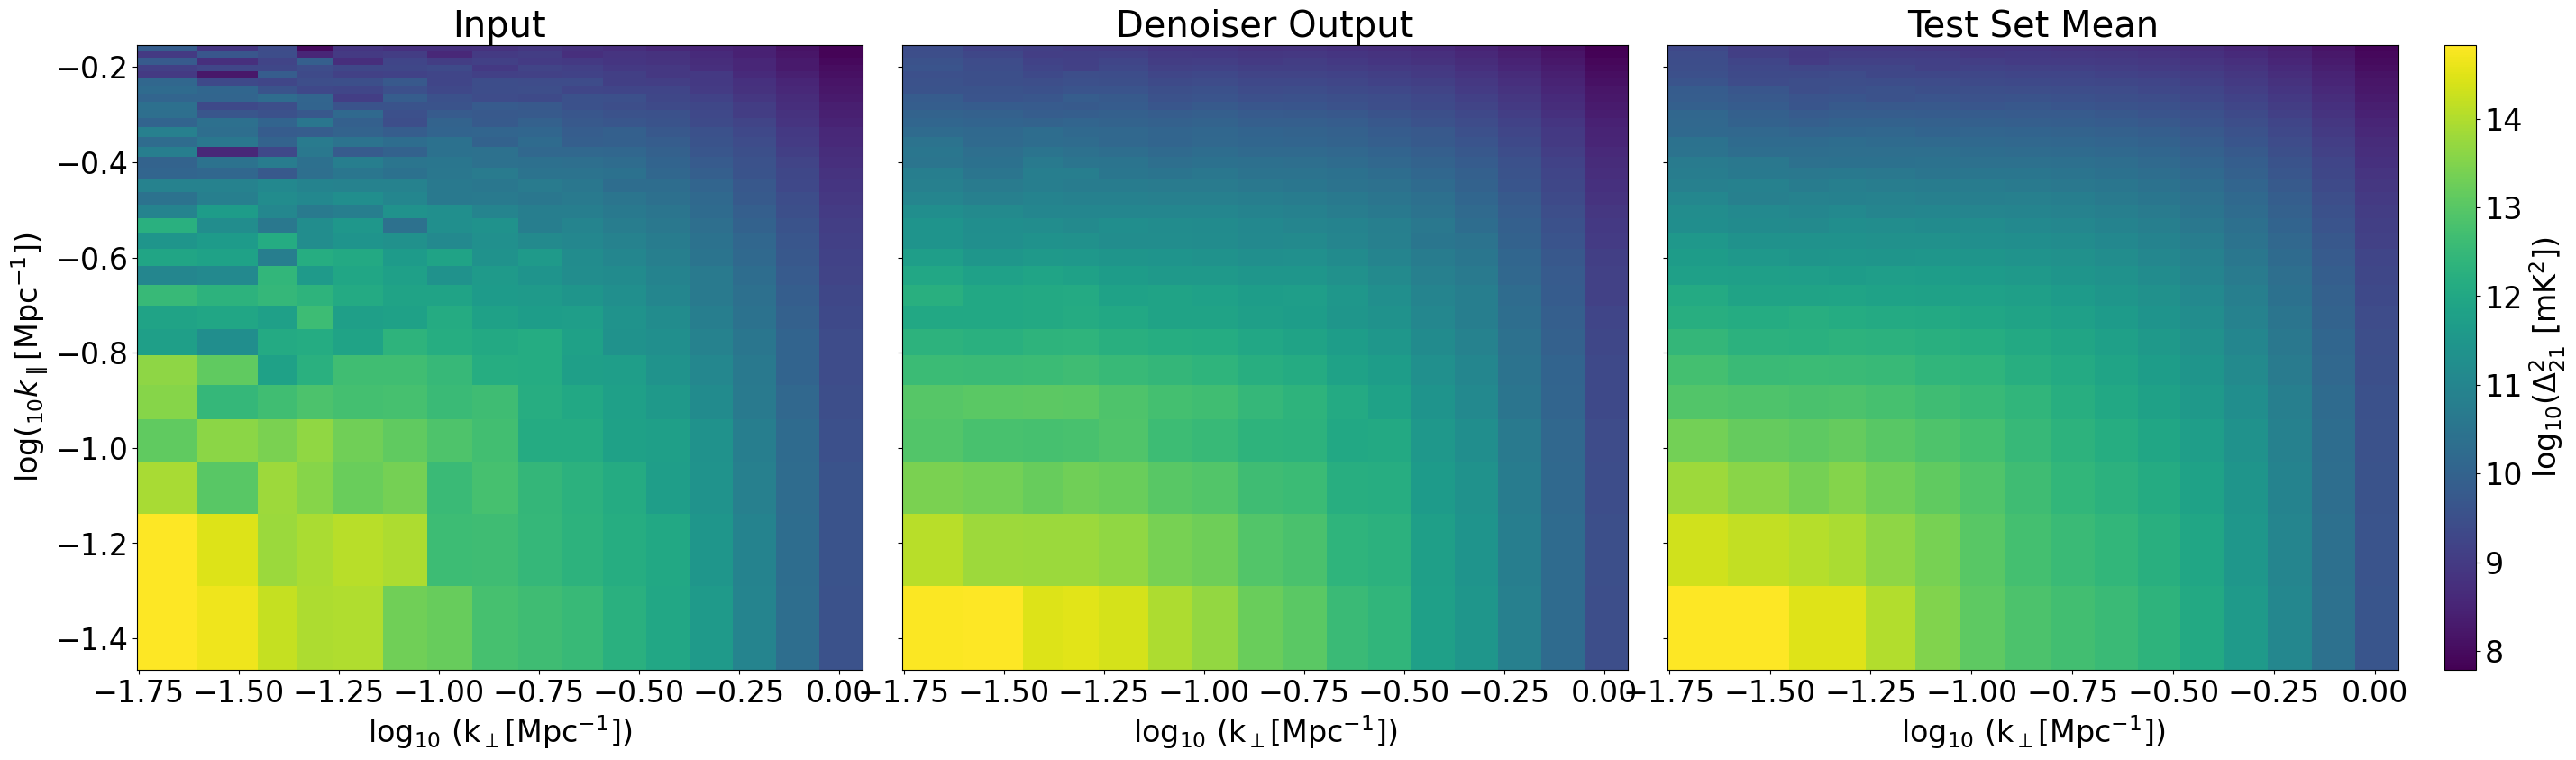

In [78]:
imshow_error_2D(mean_pred[N,...], truthmean = ps_data[N,...,1], 
             truthCV = ps_data[N,...,0], xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = mean_pred[N,...].min(), vmax = mean_pred[N,...].max(), label = r'log$_{10}(\Delta^2_{21}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

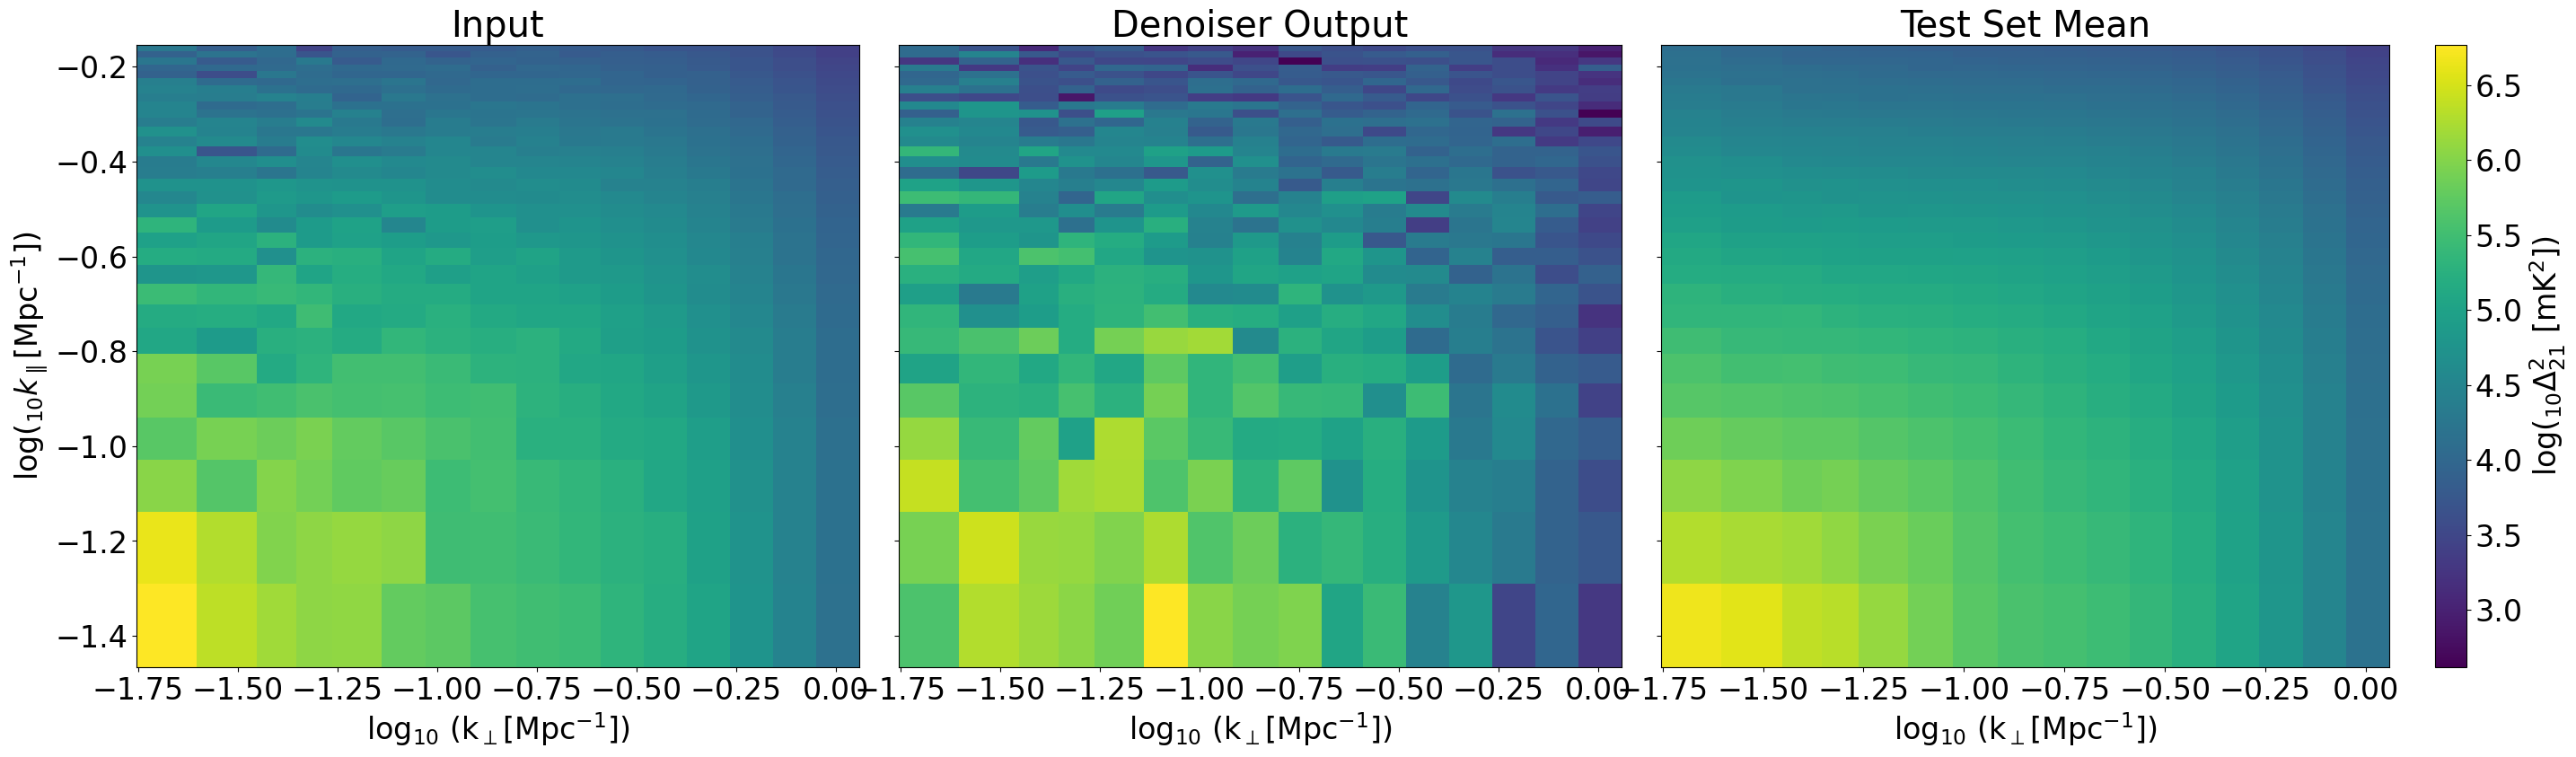

In [42]:
imshow_error_2D(np.log10(mean_pred[N,...]), truthmean = np.log10(ps_data[N,...,1]), 
             truthCV = np.log10(ps_data[N,...,0]), xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = np.log10(mean_pred[N,...]).min(), vmax = np.log10(mean_pred[N,...]).max(), label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

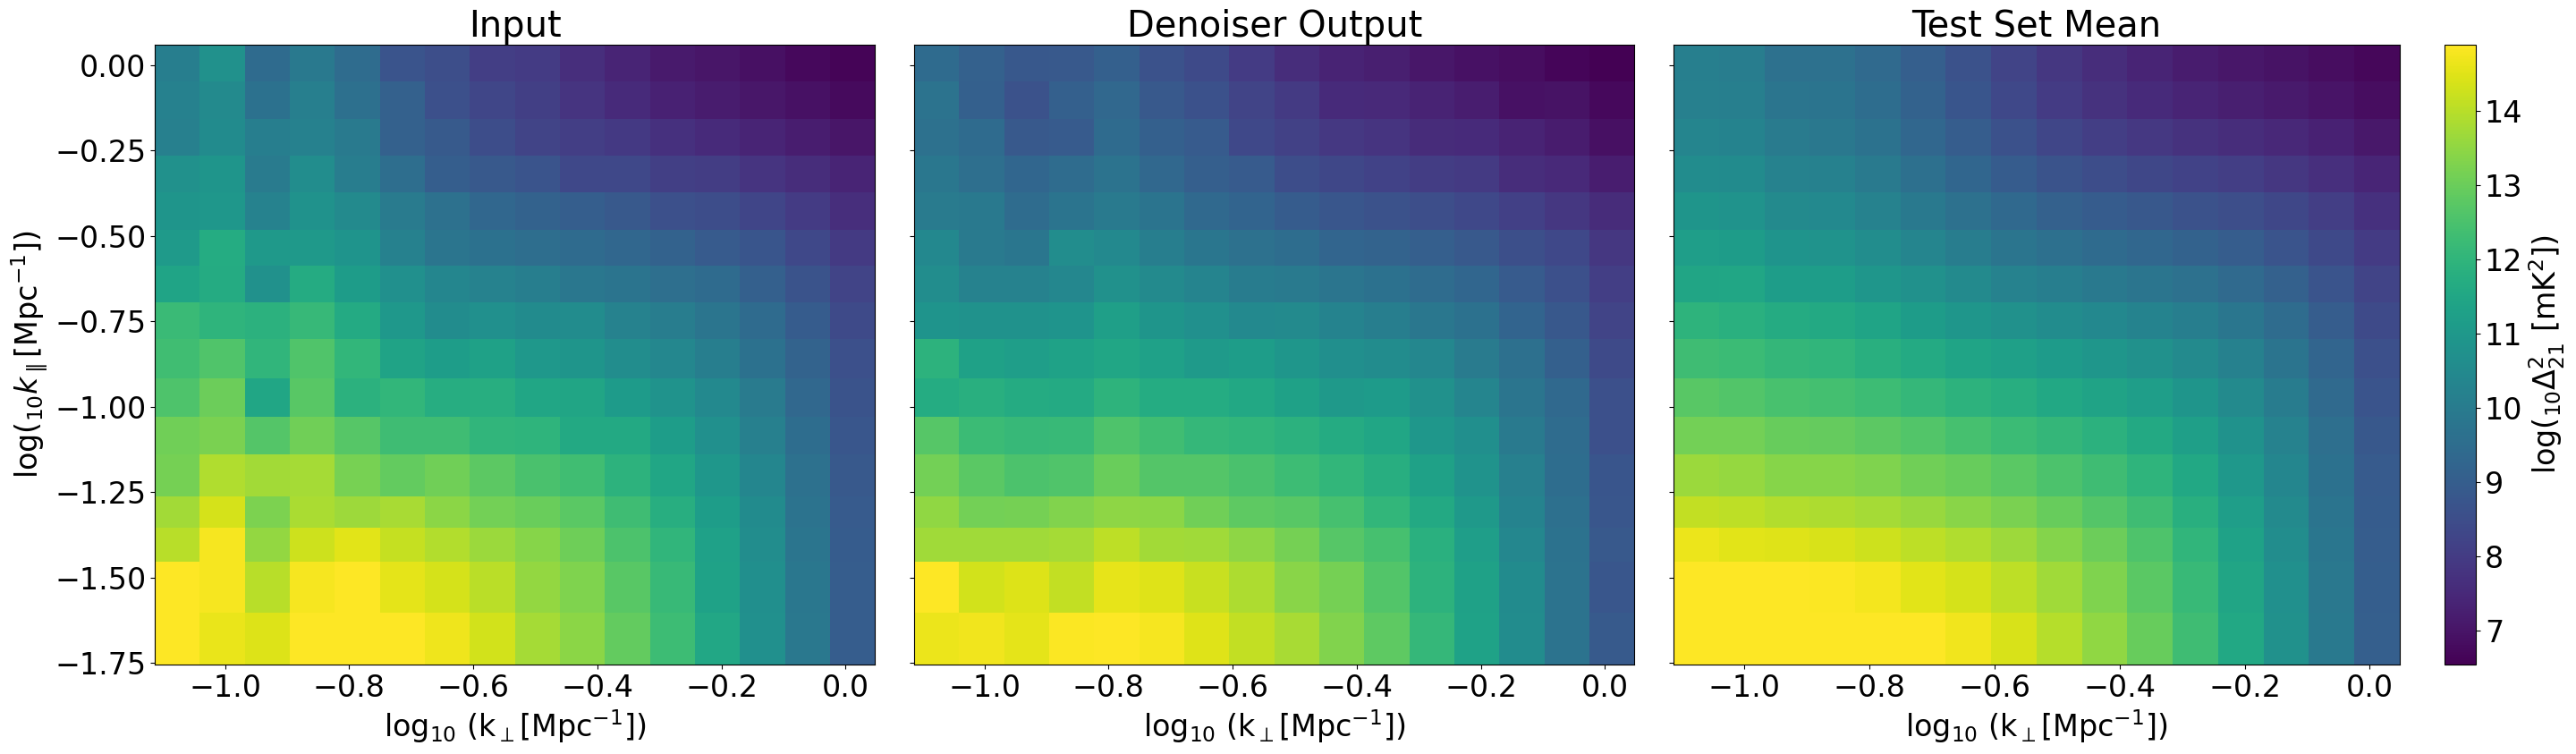

In [94]:
imshow_error_2D(mean_pred[N,...], truthmean = ps_data[N,...,1], 
             truthCV = ps_data[N,...,0], xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = mean_pred[N,...].min(), vmax = mean_pred[N,...].max(), label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

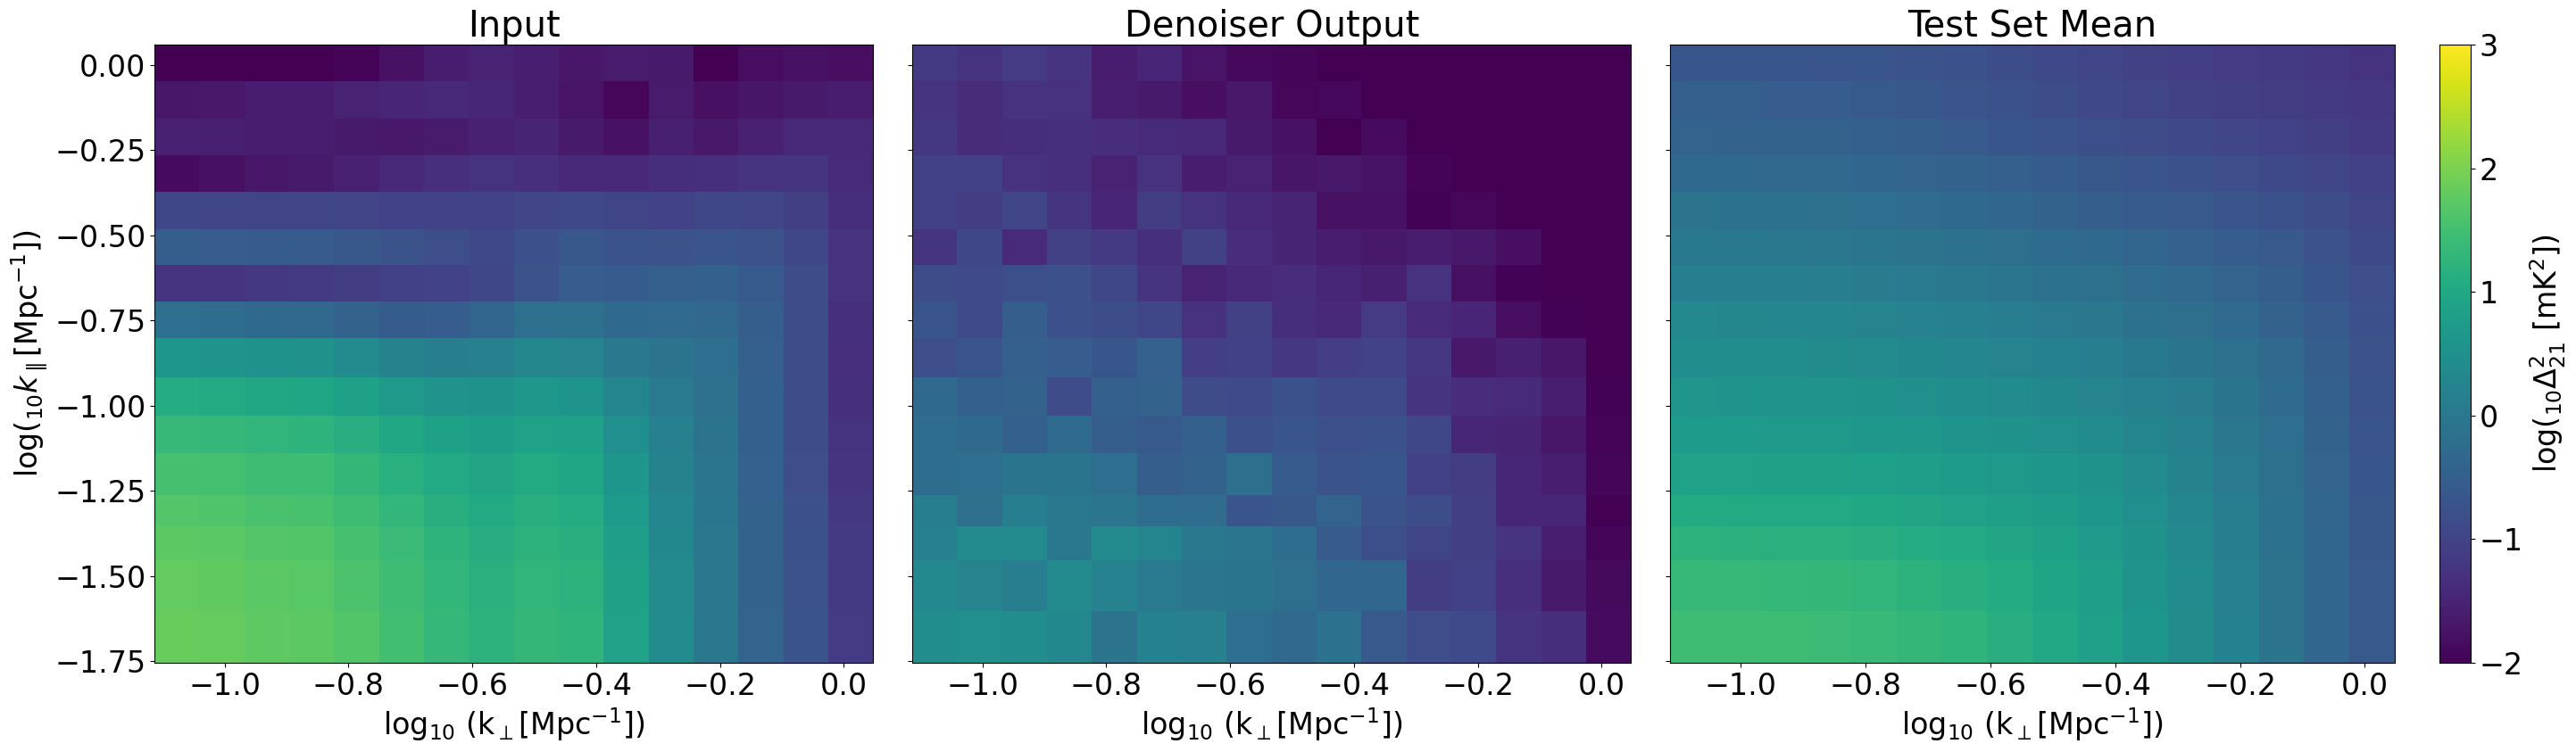

In [63]:
imshow_error_2D(mean_pred[N,...], truthmean = ps_data[N,...,1], 
             truthCV = ps_data[N,...,0], xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = -2, vmax = 3, label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

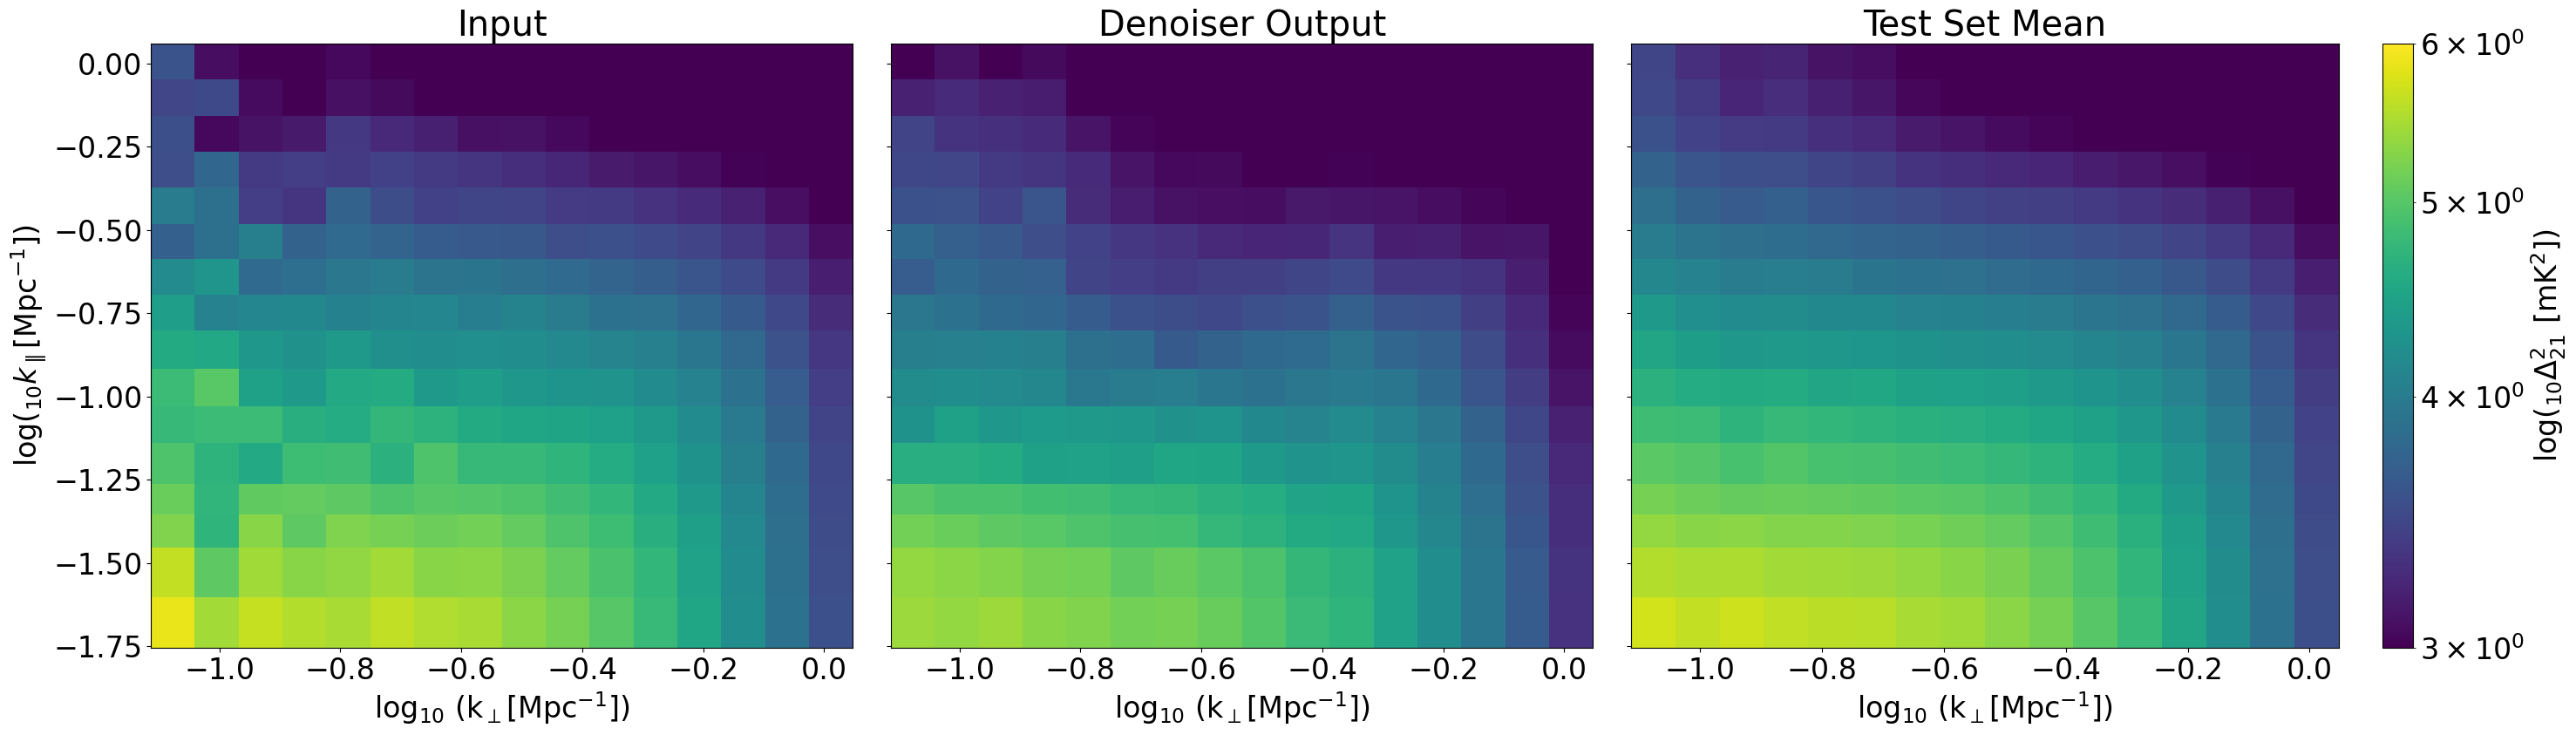

In [21]:
imshow_error_2D(np.log10(mean_pred[N,...]), truthmean = np.log10(ps_data[N,...,1]), 
             truthCV = np.log10(ps_data[N,...,0]), xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = 3, vmax = 6, label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')

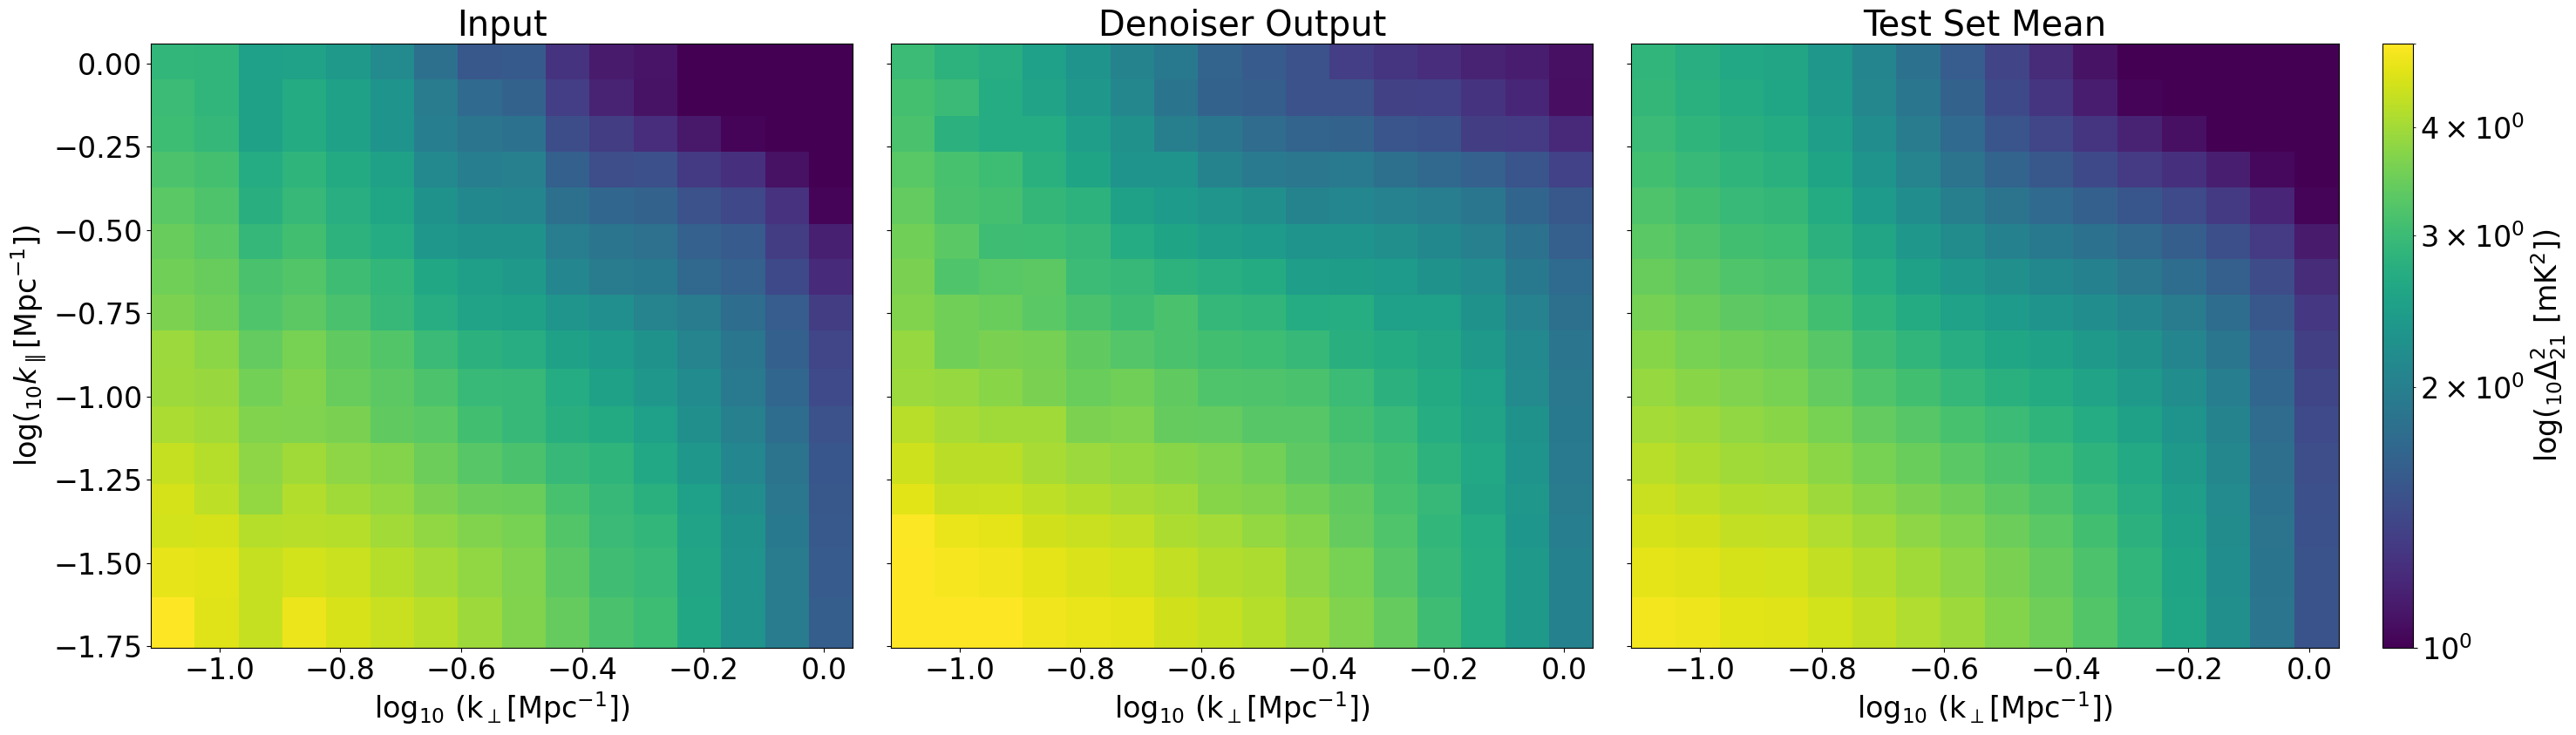

In [34]:
imshow_error_2D(np.log10(mean_pred[N,...]), truthmean = np.log10(ps_data[N,...,1]), 
             truthCV = np.log10(ps_data[N,...,0]), xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = 1, vmax = 5, label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')

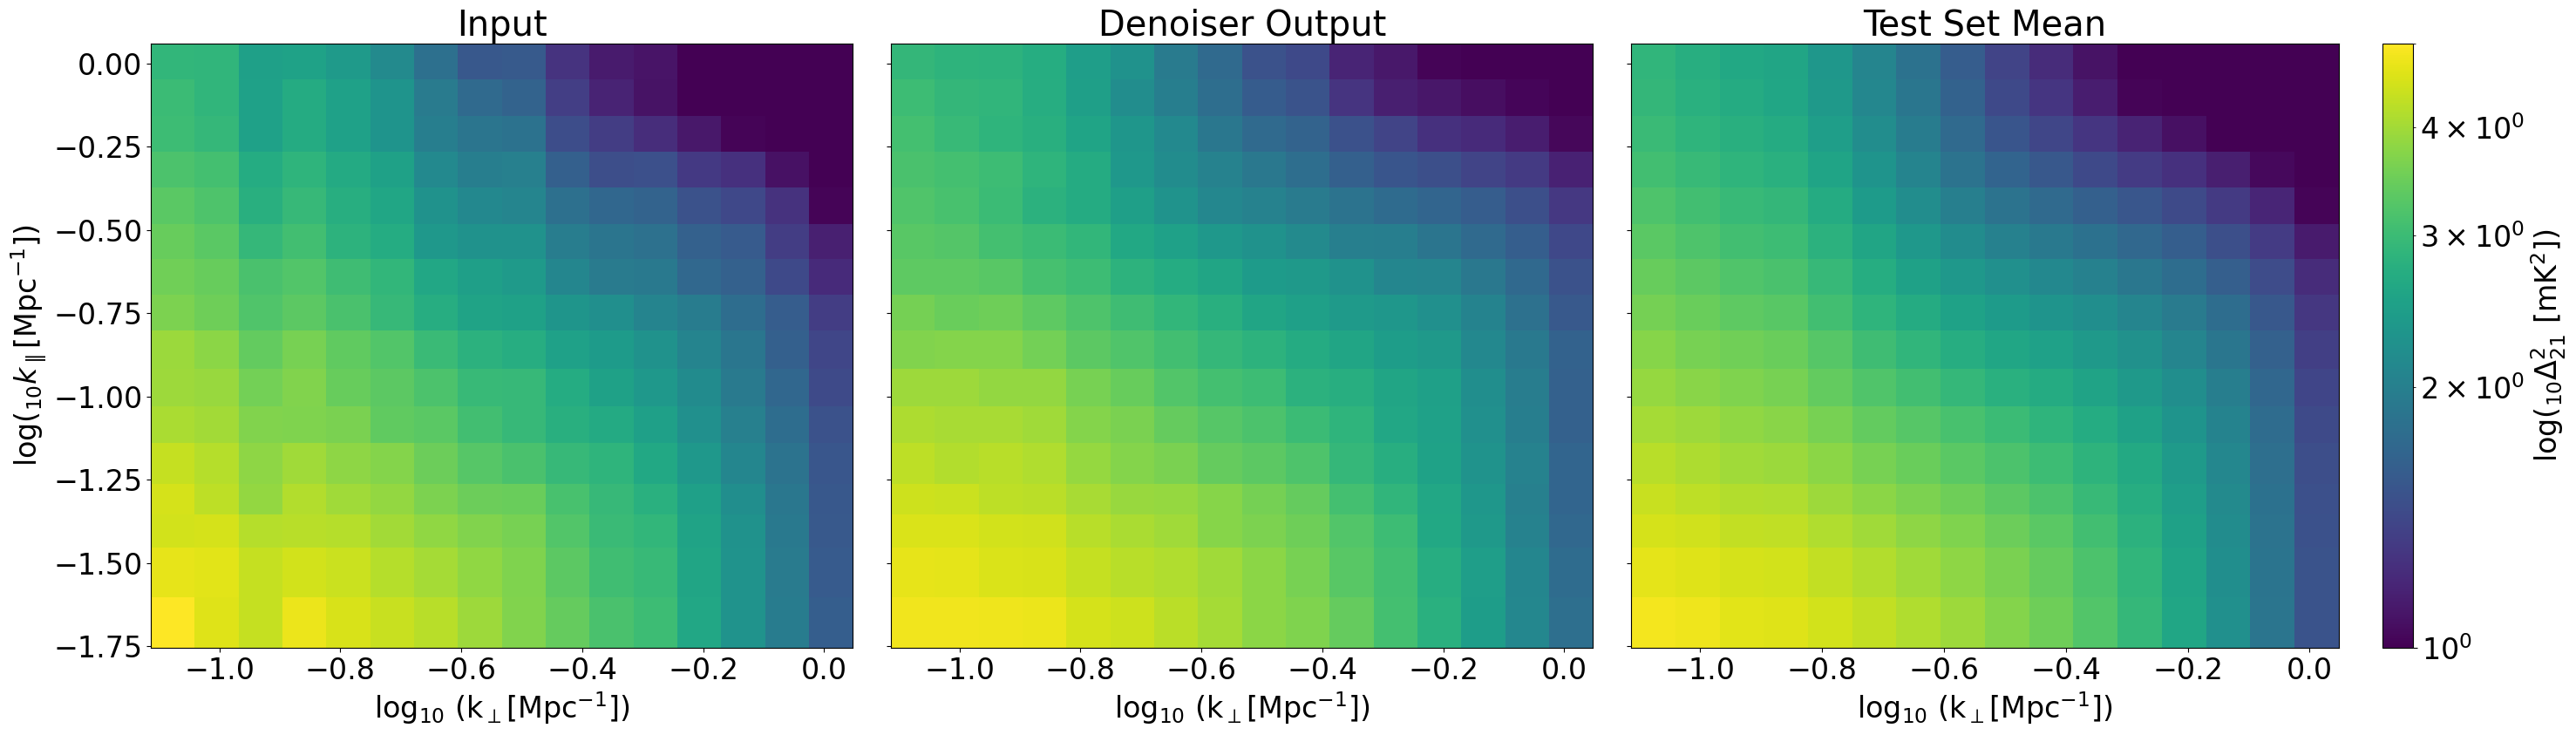

In [106]:
imshow_error_2D(np.log10(mean_pred[N,...]), truthmean = np.log10(ps_data[N,...,1]), 
             truthCV = np.log10(ps_data[N,...,0]), xs_plot = np.log10(kperp), ys_plot = np.log10(kpar),
             vmin = 1, vmax = 5, label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')

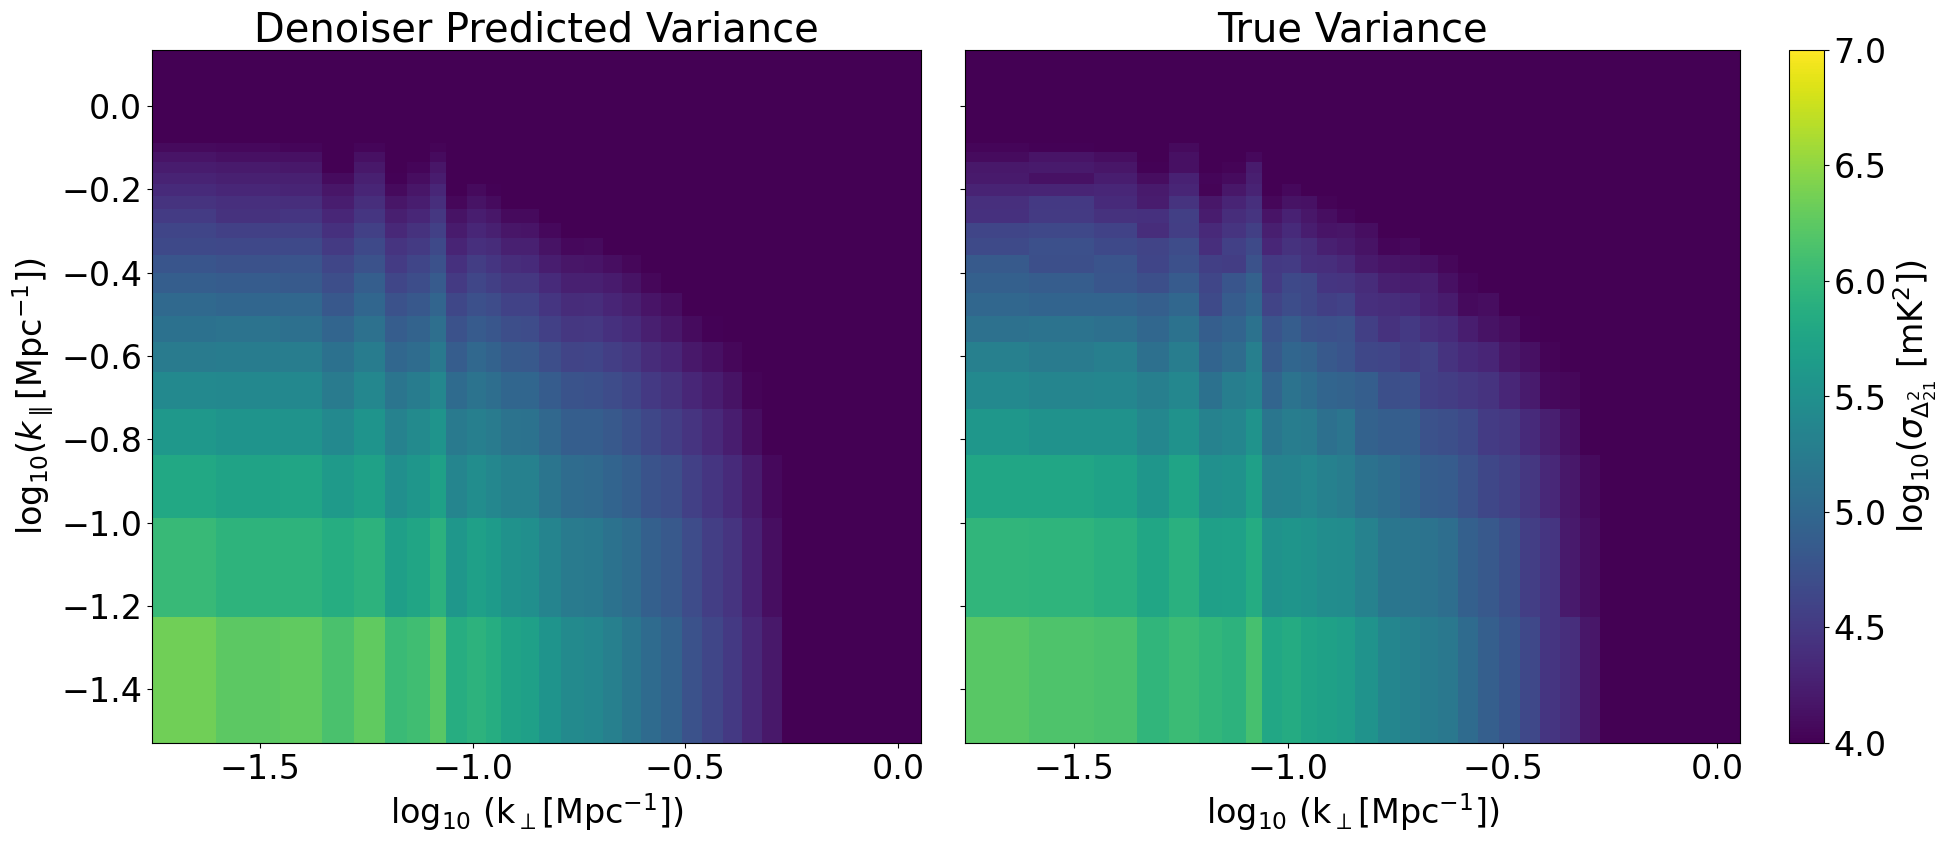

In [73]:
imshow_error_2D(np.log10(std_pred[N,...]), truthmean = np.log10(std_means[idx][N,...]), 
                #truthCV = np.log10(std_poisson[N,...]), title1 = r"mean/$\sqrt{n_\perp^2 + n_\parallel^2}$",
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'Denoiser Predicted Variance', title3 = 'True Variance',
             vmin = 4, vmax = 7., label = r'log$_{10}(\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

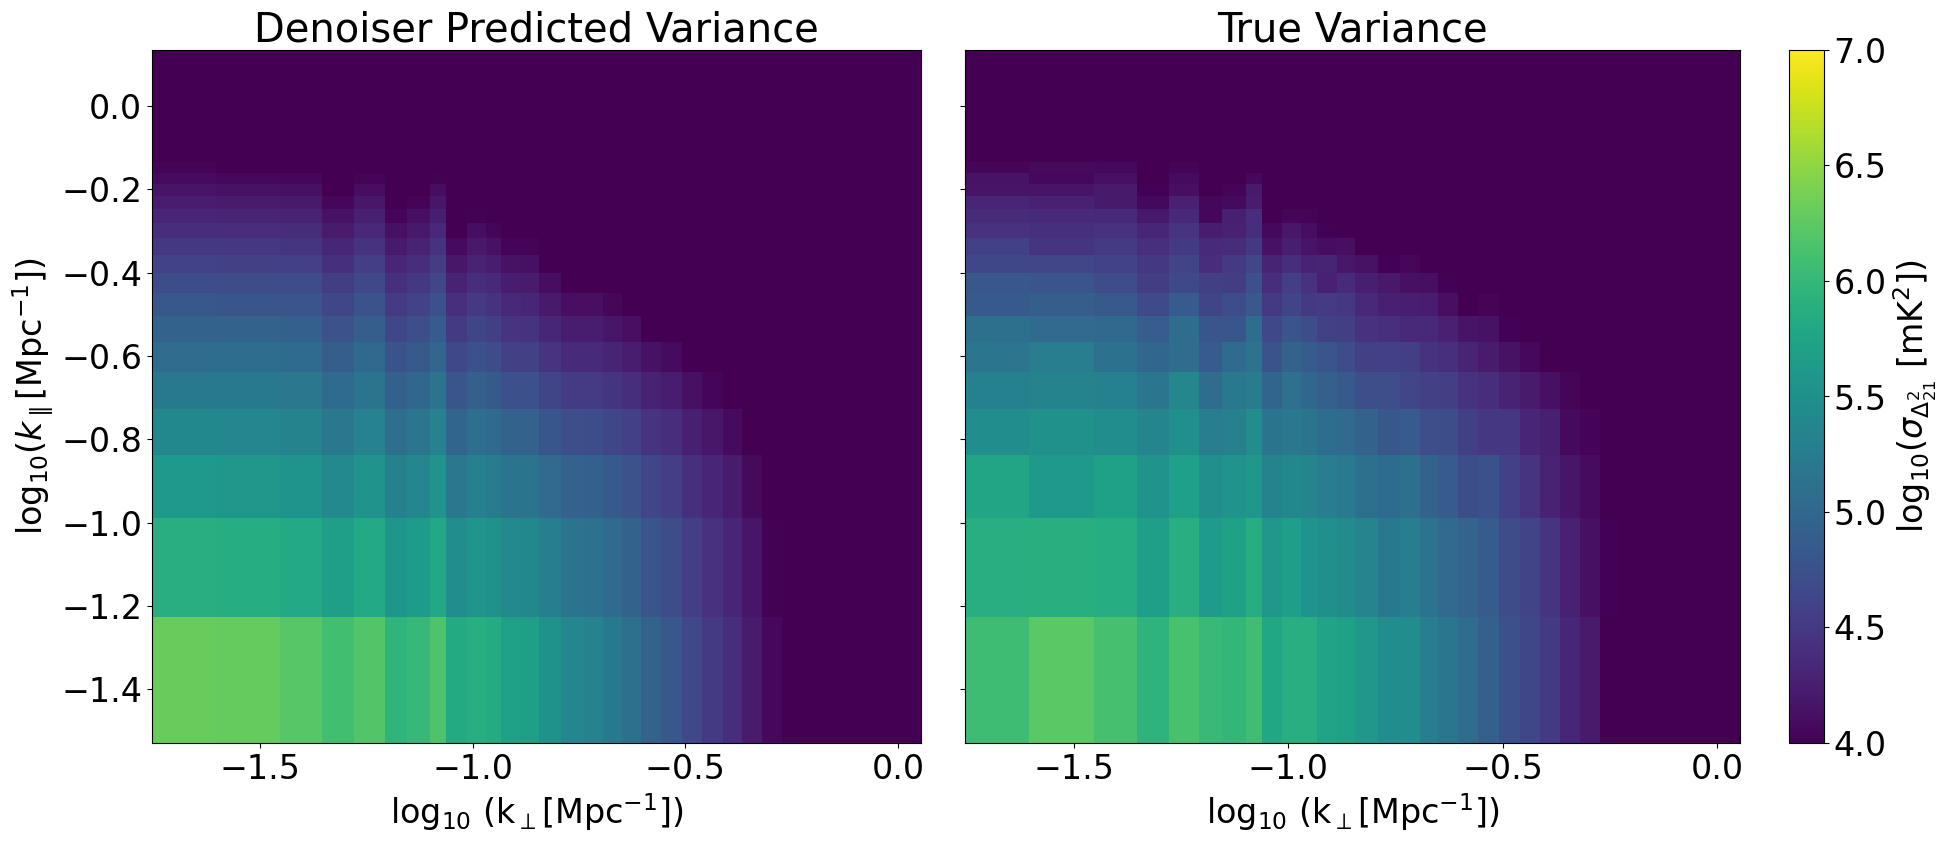

In [27]:
imshow_error_2D(np.log10(std_pred[N,...]), truthmean = np.log10(std_means[N,...]), 
                #truthCV = np.log10(std_poisson[N,...]), title1 = r"mean/$\sqrt{n_\perp^2 + n_\parallel^2}$",
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'Denoiser Predicted Variance', title3 = 'True Variance',
             vmin = 4, vmax = 7., label = r'log$_{10}(\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

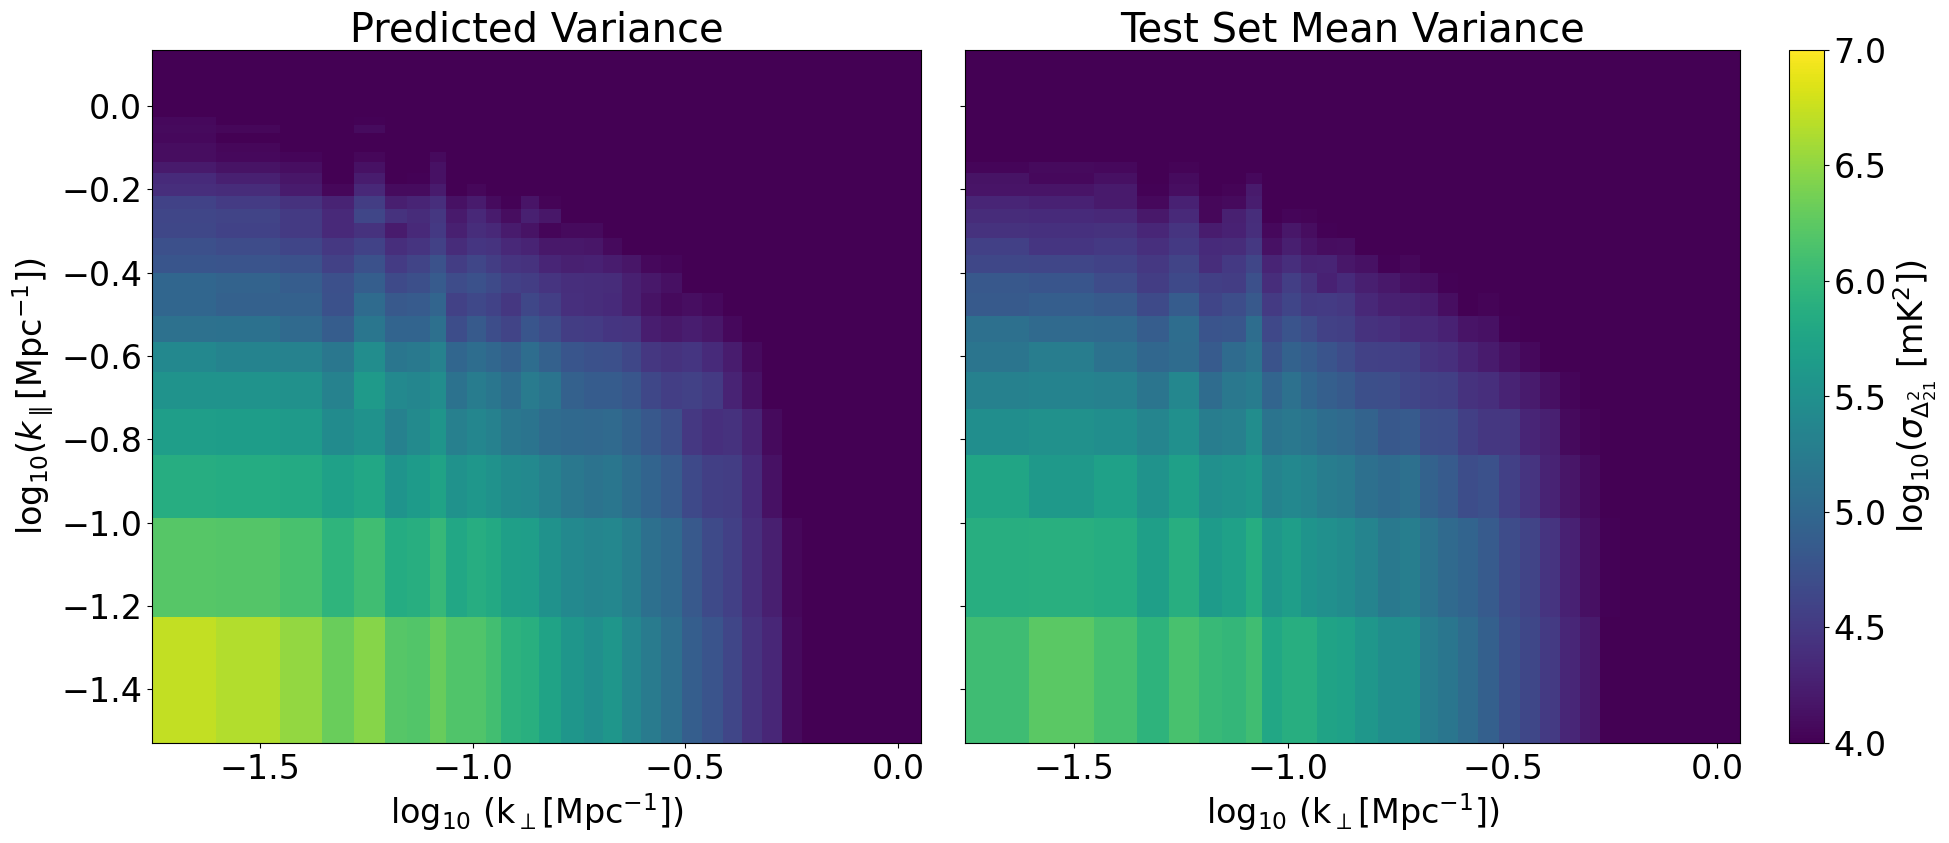

In [37]:
imshow_error_2D(np.log10(std_pred[N,...]), truthmean = np.log10(std_means[N,...]), 
                #truthCV = np.log10(std_poisson[N,...]), title1 = r"mean/$\sqrt{n_\perp^2 + n_\parallel^2}$",
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'Predicted Variance', title3 = 'Test Set Mean Variance',
             vmin = 4, vmax = 7., label = r'log$_{10}(\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

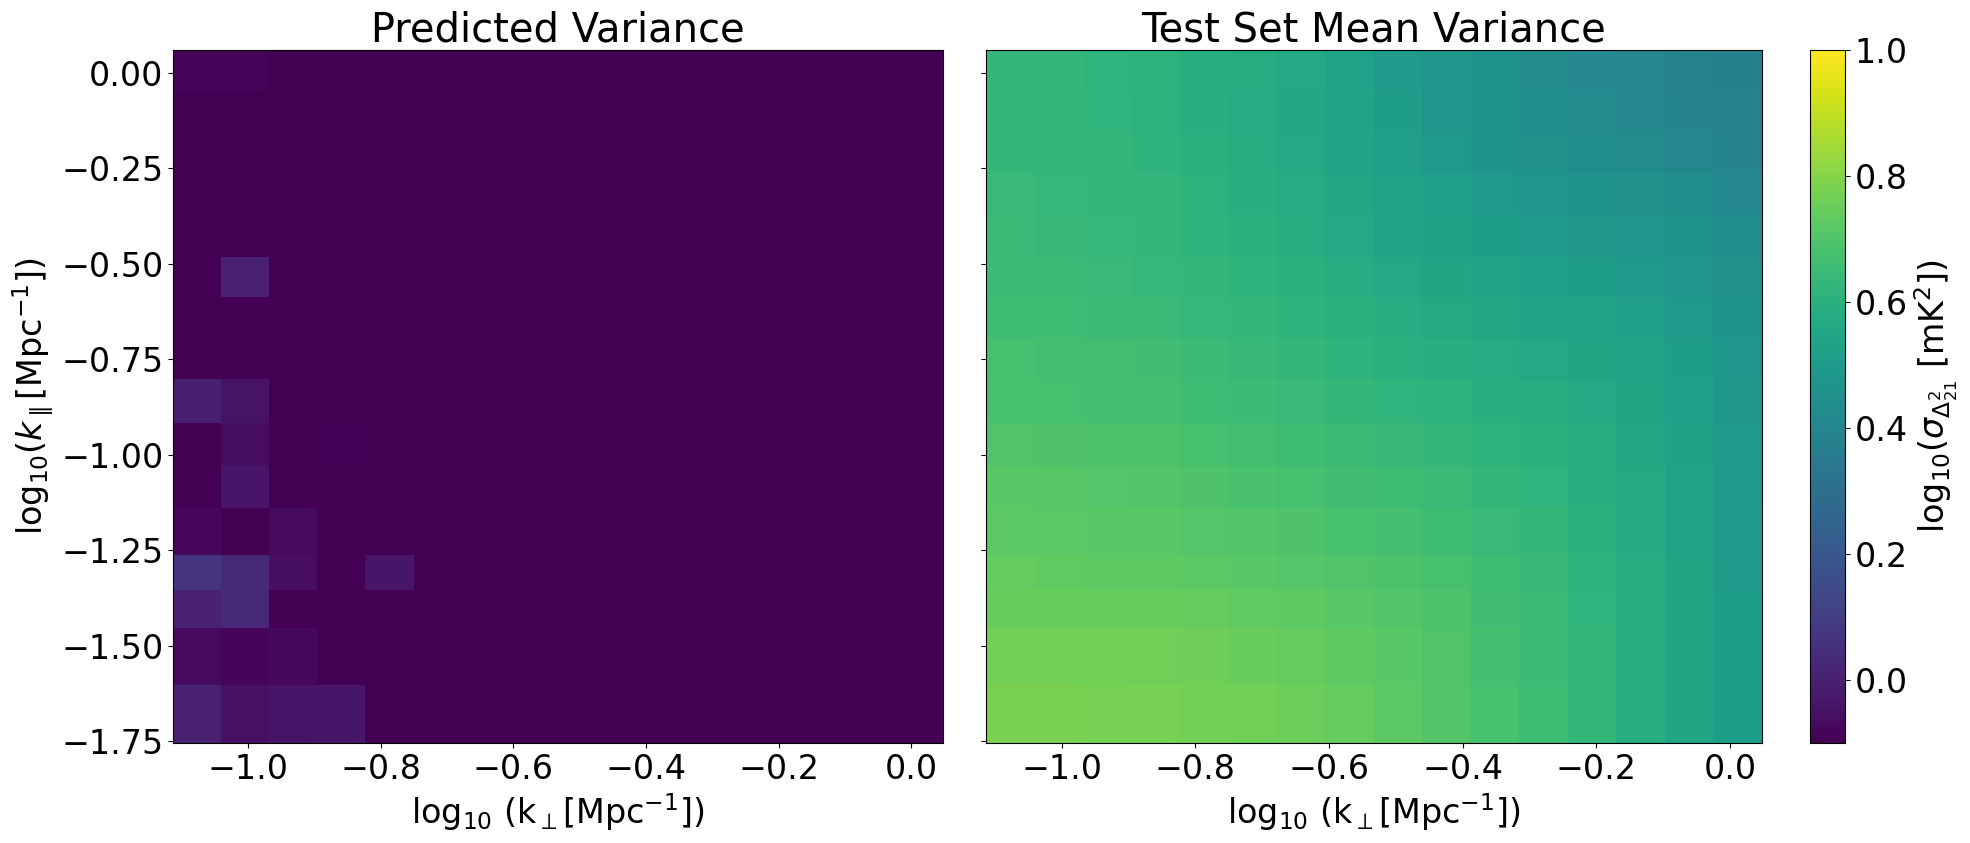

In [112]:
imshow_error_2D(np.log10(std_pred[N,...]), truthmean = np.log10(std_means[N,...]), 
                #truthCV = np.log10(std_poisson[N,...]), title1 = r"mean/$\sqrt{n_\perp^2 + n_\parallel^2}$",
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'Predicted Variance', title3 = 'Test Set Mean Variance',
             vmin = -0.1, vmax = 1., label = r'log$_{10}(\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

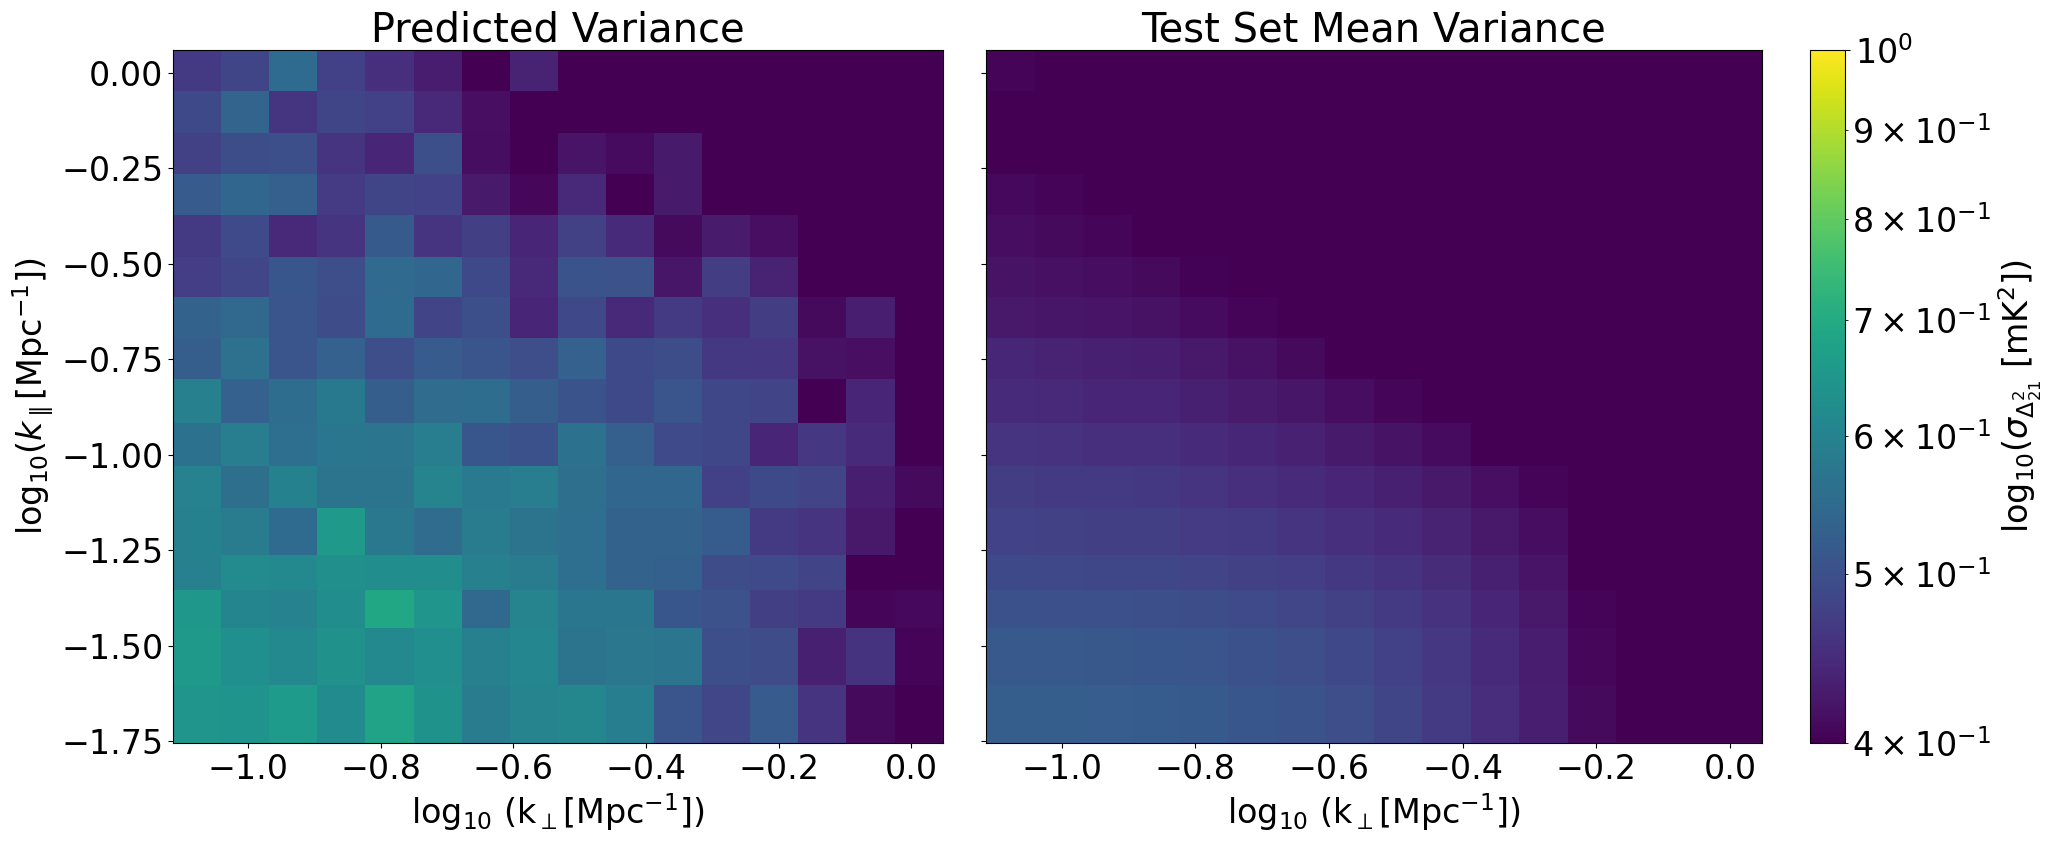

In [69]:
imshow_error_2D(np.log10(std_pred[N,...]), truthmean = np.log10(std_means[N,...]), 
                #truthCV = np.log10(std_poisson[N,...]), title1 = r"mean/$\sqrt{n_\perp^2 + n_\parallel^2}$",
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'Predicted Variance', title3 = 'Test Set Mean Variance',
             vmin = 0.4, vmax = 1, label = r'log$_{10}(\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')

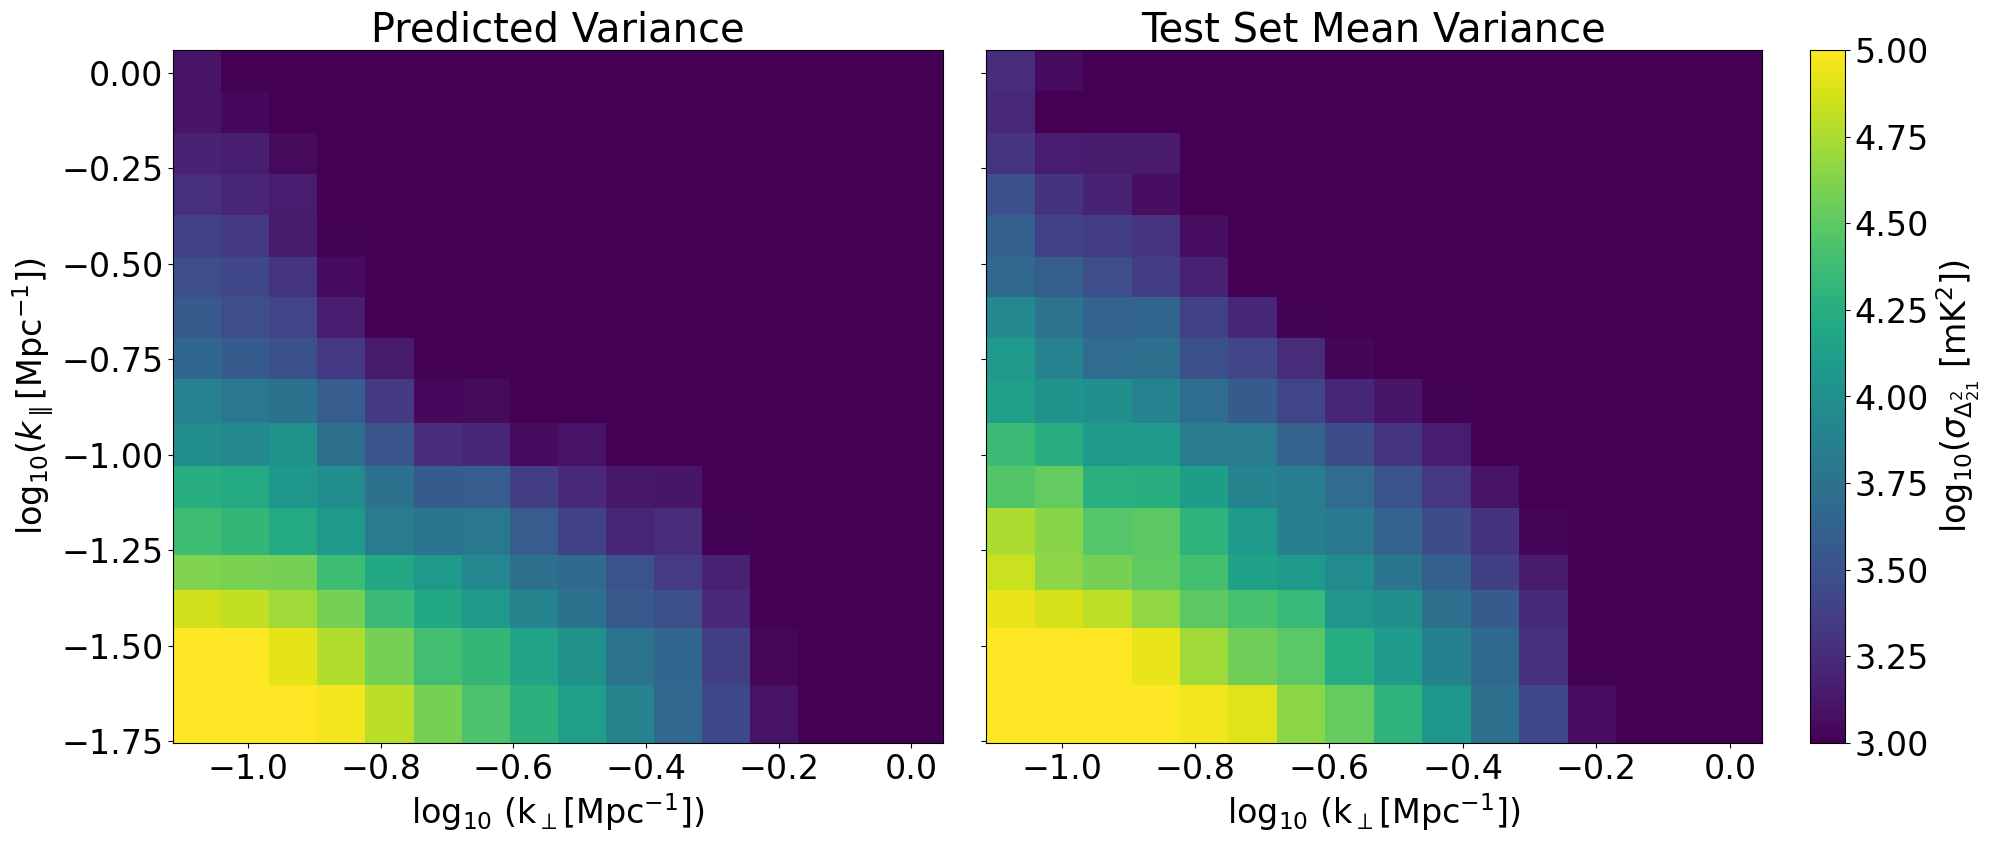

In [25]:
imshow_error_2D(np.log10(std_pred[N,...]), truthmean = np.log10(std_means[N,...]), 
                #truthCV = np.log10(std_poisson[N,...]), title1 = r"mean/$\sqrt{n_\perp^2 + n_\parallel^2}$",
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'Predicted Variance', title3 = 'Test Set Mean Variance',
             vmin = 3, vmax = 5, label = r'log$_{10}(\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

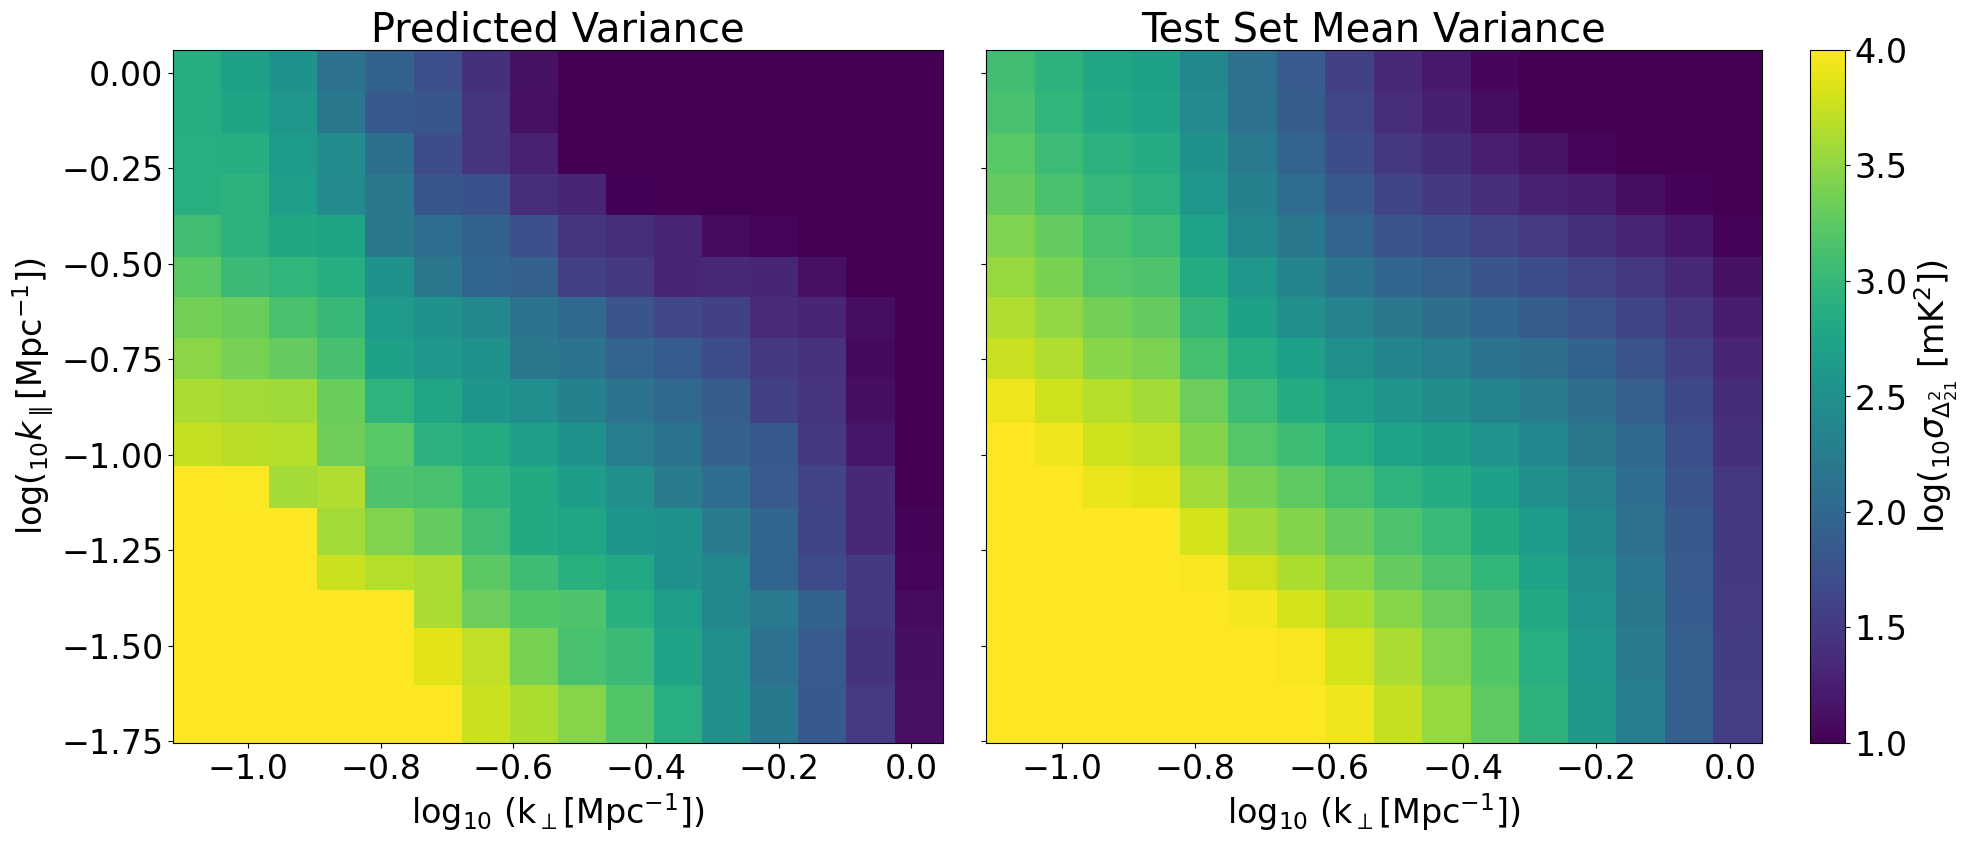

In [35]:
imshow_error_2D(np.log10(std_pred[N,...]), truthmean = np.log10(std_means[N,...]), 
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'Predicted Variance', title3 = 'Test Set Mean Variance',
             vmin = 1, vmax = 4, label = r'log($_{10}\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

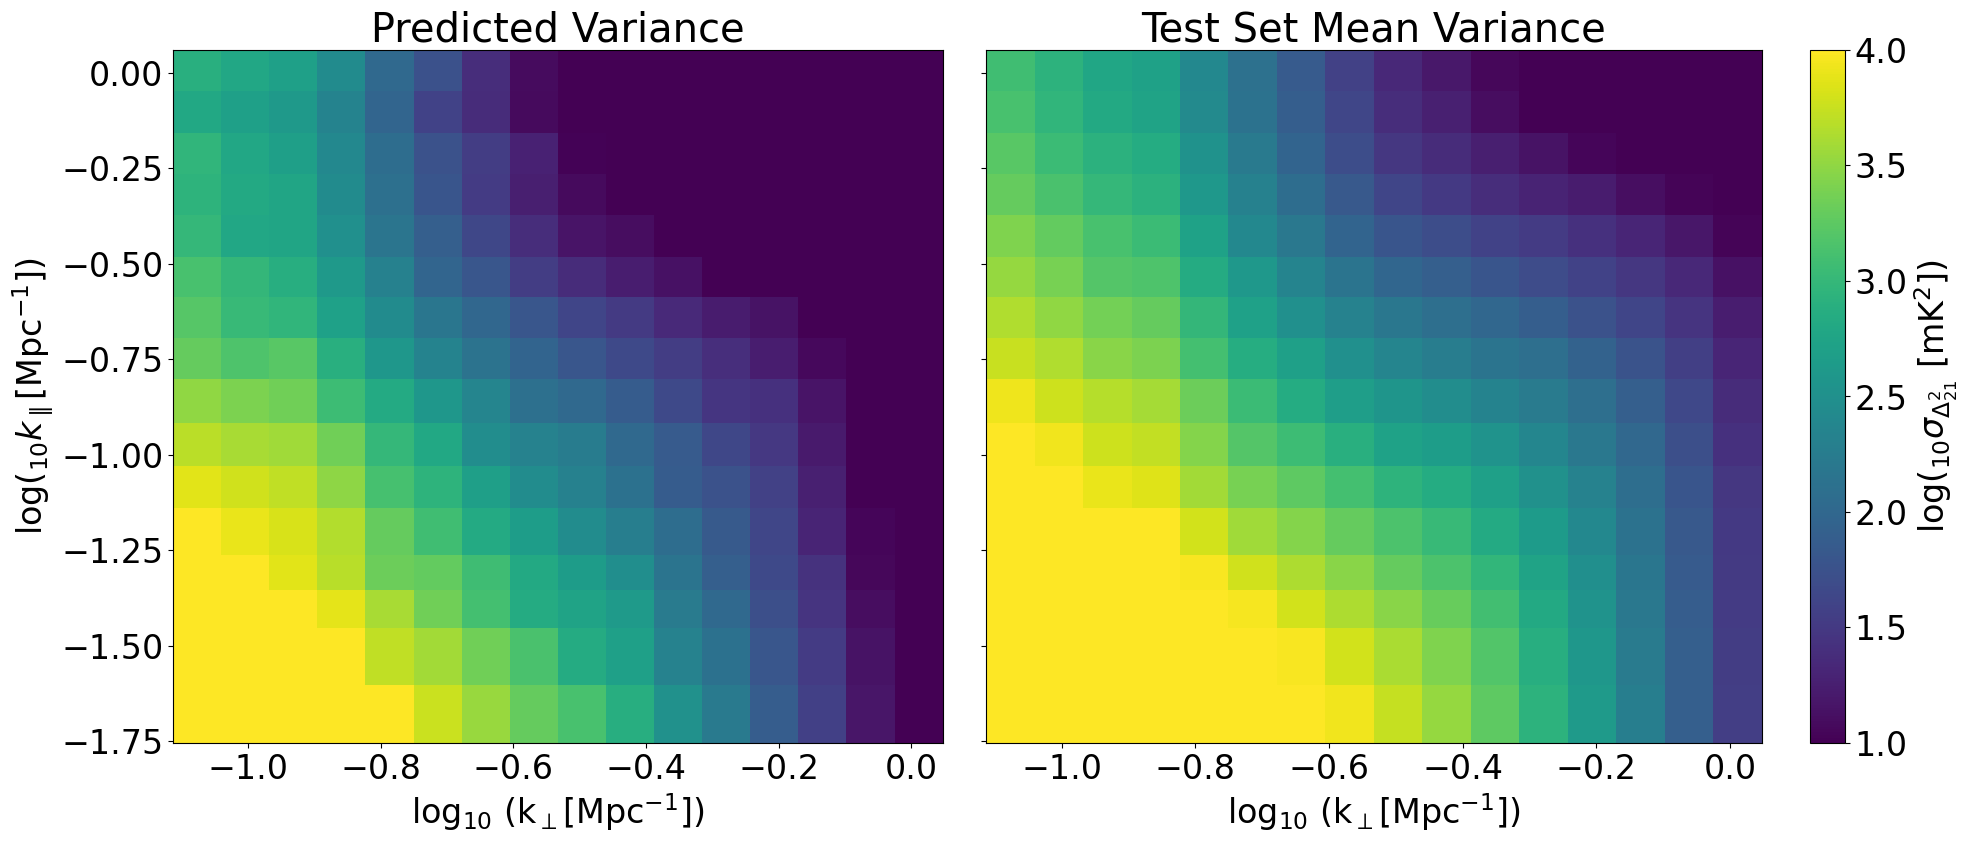

In [107]:
imshow_error_2D(np.log10(std_pred[N,...]), truthmean = np.log10(std_means[N,...]), 
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'Predicted Variance', title3 = 'Test Set Mean Variance',
             vmin = 1, vmax = 4, label = r'log($_{10}\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = False)#, save = 'PS_emu_vs_true', fmt = 'png')

In [28]:
fe = abs((ps_data[...,1] - mean_pred)/ps_data[...,1]) * 100.
print('Compare id: ', np.median(fe))

Compare id:  7.423237884099447


In [78]:
#Dec25
fe = abs((std_means[idx] - std_pred)/std_means[idx]) * 100.

print('Compare true std w pred std: %.3f' % np.nanmean(fe))

fe2 = abs((seeds[idx] - means[idx]) / means[idx]) * 100.
print('Compare true mean w noisy PS: %.3f' % np.nanmean(fe2))


fe3 = abs((means[idx] - mean_pred) / means[idx]) * 100.
print('Compare true mean w pred mean: %.3f' % np.nanmean(fe3))

if np.nanmean(fe3) < np.nanmean(fe2):
    print("Then it's better to apply the network to estimate the mean.")
else:
    print("Then the network sucks and it's better to just use the noisy sample to estimate the mean.")

Compare true std w pred std: 14.987
Compare true mean w noisy PS: 19.814
Compare true mean w pred mean: 9.600
Then it's better to apply the network to estimate the mean.


In [32]:
fe = abs((std_means - std_pred)/std_means) * 100.

print('Compare true std w pred std: %.3f' % np.nanmean(fe))

fe2 = abs((ps_data[...,0] - ps_data[...,1]) / ps_data[...,1]) * 100.
print('Compare true mean w noisy PS: %.3f' % np.nanmean(fe2))


fe3 = abs((ps_data[...,1] - mean_pred) / ps_data[...,1]) * 100.
print('Compare true mean w pred mean: %.3f' % np.nanmean(fe3))

if np.nanmean(fe3) < np.nanmean(fe2):
    print("Then it's better to apply the network to estimate the mean.")
else:
    print("Then the network sucks and it's better to just use the noisy sample to estimate the mean.")

Compare true std w pred std: 40.292
Compare true mean w noisy PS: 20.347
Compare true mean w pred mean: 19.245
Then it's better to apply the network to estimate the mean.


In [23]:
fe = abs((std_means - std_pred)/std_means) * 100.

print('Compare true std w pred std: %.3f' % np.nanmean(fe))

fe2 = abs((ps_data[...,0] - ps_data[...,1]) / ps_data[...,1]) * 100.
print('Compare true mean w noisy PS: %.3f' % np.nanmean(fe2))


fe3 = abs((ps_data[...,1] - mean_pred) / ps_data[...,1]) * 100.
print('Compare true mean w pred mean: %.3f' % np.nanmean(fe3))

if np.nanmean(fe3) < np.nanmean(fe2):
    print("Then it's better to apply the network to estimate the mean.")
else:
    print("Then the network sucks and it's better to just use the noisy sample to estimate the mean.")

Compare true std w pred std: 2109432.261
Compare true mean w noisy PS: 23.160
Compare true mean w pred mean: 22.667
Then it's better to apply the network to estimate the mean.


In [124]:
fe = abs((std_means - std_pred)/std_means) * 100.

print('Compare true std w pred std: %.3f' % np.nanmedian(fe))

fe2 = abs((ps_data[...,0] - ps_data[...,1]) / ps_data[...,1]) * 100.
print('Compare true mean w noisy PS: %.3f' % np.nanmedian(fe2))


fe3 = abs((ps_data[...,1] - mean_pred) / ps_data[...,1]) * 100.
print('Compare true mean w pred mean: %.3f' % np.nanmedian(fe3))

if np.median(fe3) < np.median(fe2):
    print("Then it's better to apply the network to estimate the mean.")
else:
    print("Then the network sucks and it's better to just use the noisy sample to estimate the mean.")

Compare true std w pred std: 90.533
Compare true mean w noisy PS: 0.968
Compare true mean w pred mean: 4.174
Then the network sucks and it's better to just use the noisy sample to estimate the mean.


In [125]:
fe = abs((std_means - std_pred)/std_means) * 100.

print('Compare true std w pred std: %.3f' % np.nanmedian(fe))

fe2 = abs((ps_data[...,0] - ps_data[...,1]) / ps_data[...,1]) * 100.
print('Compare true mean w noisy PS: %.3f' % np.nanmedian(fe2))


fe3 = abs((ps_data[...,1] - mean_pred) / ps_data[...,1]) * 100.
print('Compare true mean w pred mean: %.3f' % np.nanmedian(fe3))

if np.median(fe3) < np.median(fe2):
    print("Then it's better to apply the network to estimate the mean.")
else:
    print("Then the network sucks and it's better to just use the noisy sample to estimate the mean.")

Compare true std w pred std: 49.309
Compare true mean w noisy PS: 11.741
Compare true mean w pred mean: 33.258
Then the network sucks and it's better to just use the noisy sample to estimate the mean.


/var/tmp/pbs.189392.pbs01/ipykernel_187584/3551183925.py:1: RuntimeWarning: divide by zero encountered in true_divide
  fe = abs((std_means - std_pred)/std_means) * 100.
/var/tmp/pbs.189392.pbs01/ipykernel_187584/3551183925.py:5: RuntimeWarning: invalid value encountered in true_divide
  fe2 = abs((ps_data[...,0] - ps_data[...,1]) / ps_data[...,1]) * 100.
/var/tmp/pbs.189392.pbs01/ipykernel_187584/3551183925.py:9: RuntimeWarning: divide by zero encountered in true_divide
  fe3 = abs((ps_data[...,1] - mean_pred) / ps_data[...,1]) * 100.


In [25]:
N = 0
z_idx = 3

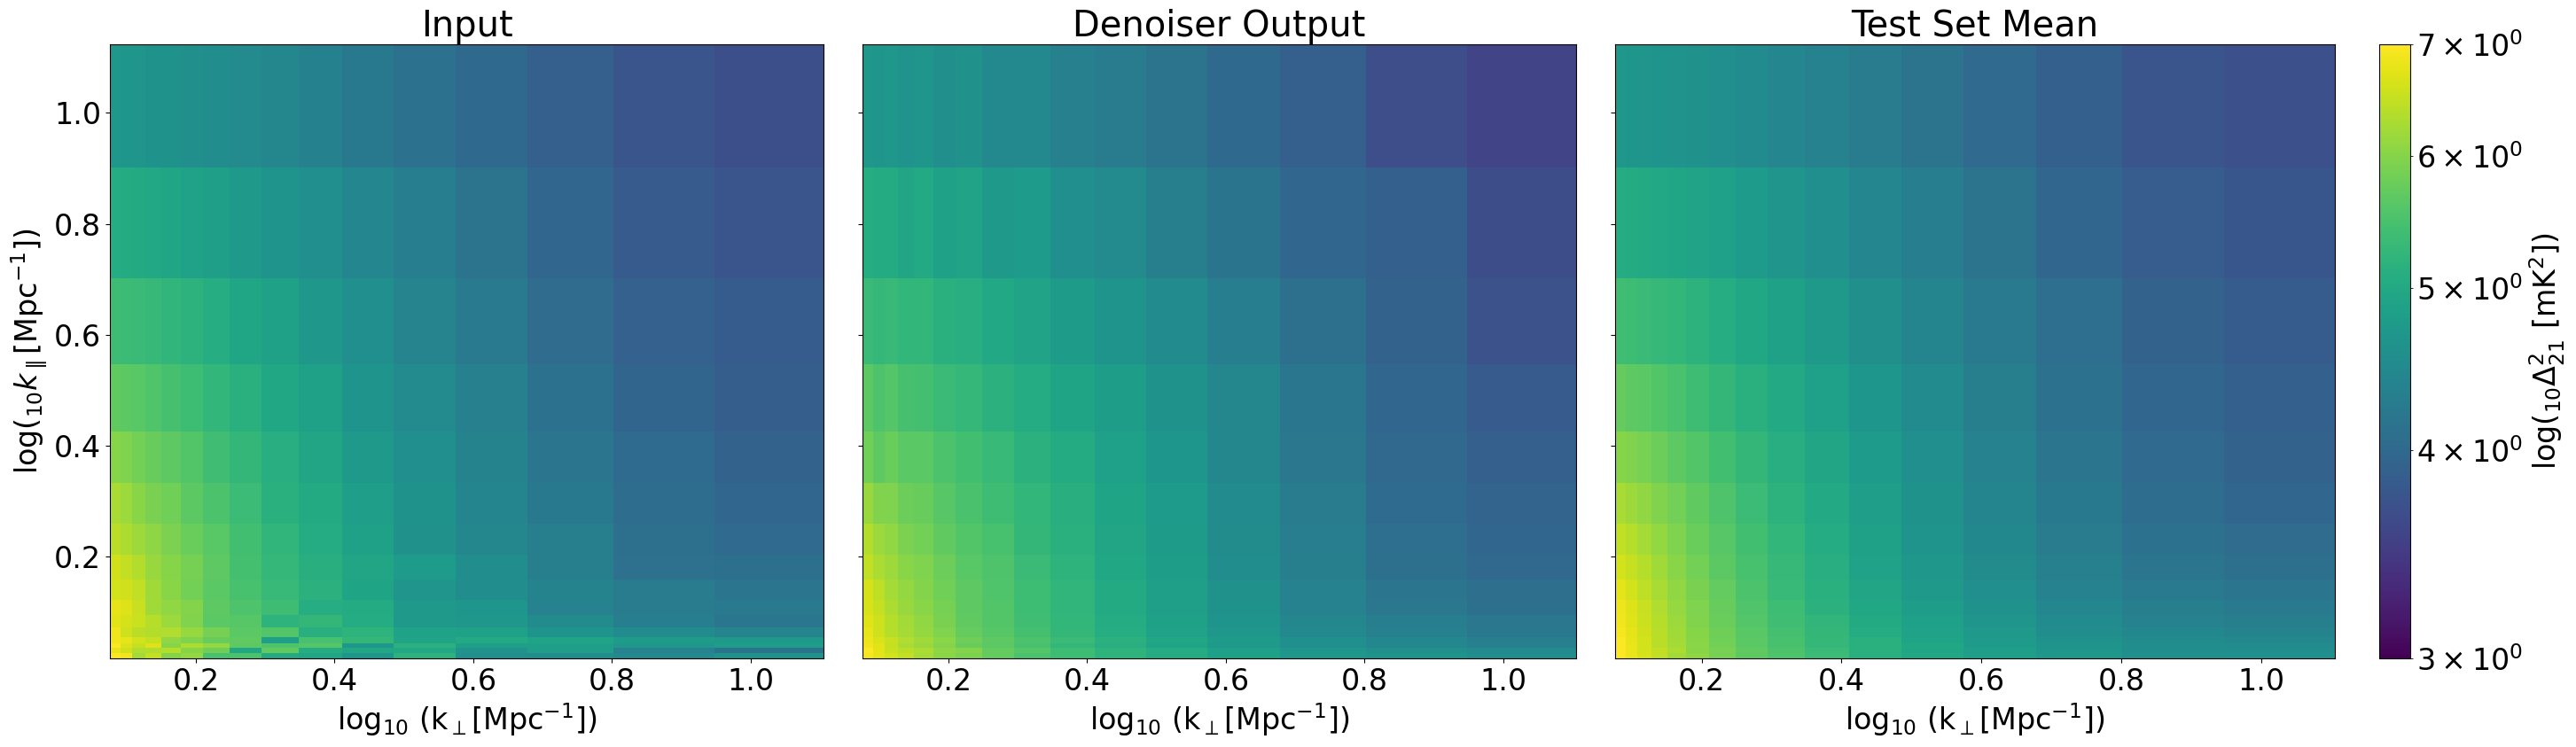

In [26]:
imshow_error_2D(np.log10(Y_pred[N,z_idx,...]), truthmean = np.log10(original_data[N,z_idx,...,1]), 
             truthCV = np.log10(original_data[N,z_idx,...,0]), xs_plot = kperp, ys_plot = kpar,
             vmin = 3, vmax = 7, label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')

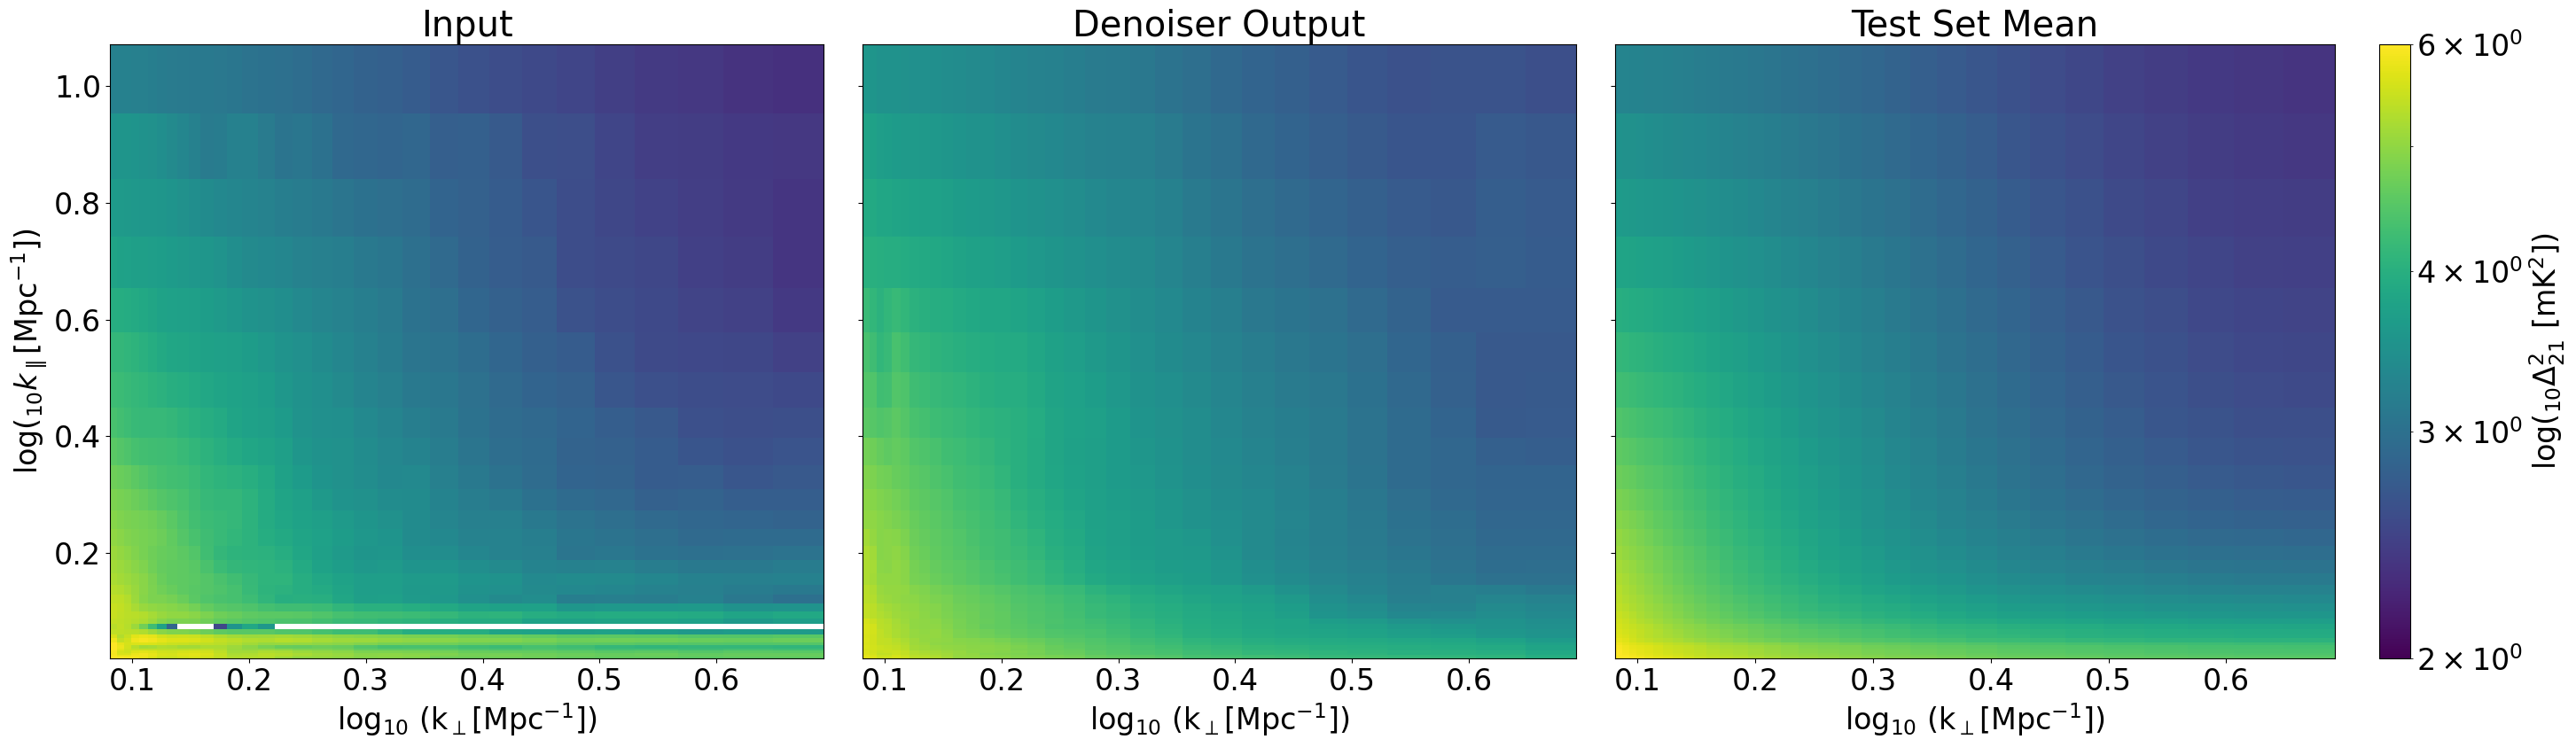

In [32]:
imshow_error_2D(Y_pred[N,z_idx,...], truthmean = original_data[N,z_idx,...,1], 
             truthCV = original_data[N,z_idx,...,0], xs_plot = kperp, ys_plot = kpar,
             vmin = 2, vmax = 6, label = r'log($_{10}\Delta^2_{21}$ [mK$^2$])', log = True)#, save = 'PS_emu_vs_true', fmt = 'png')

In [53]:
fe_avg = np.nanmean(np.nanmean(fe, axis = 0), axis = 0)

In [54]:
fe_avg.max()

12.096278297459142

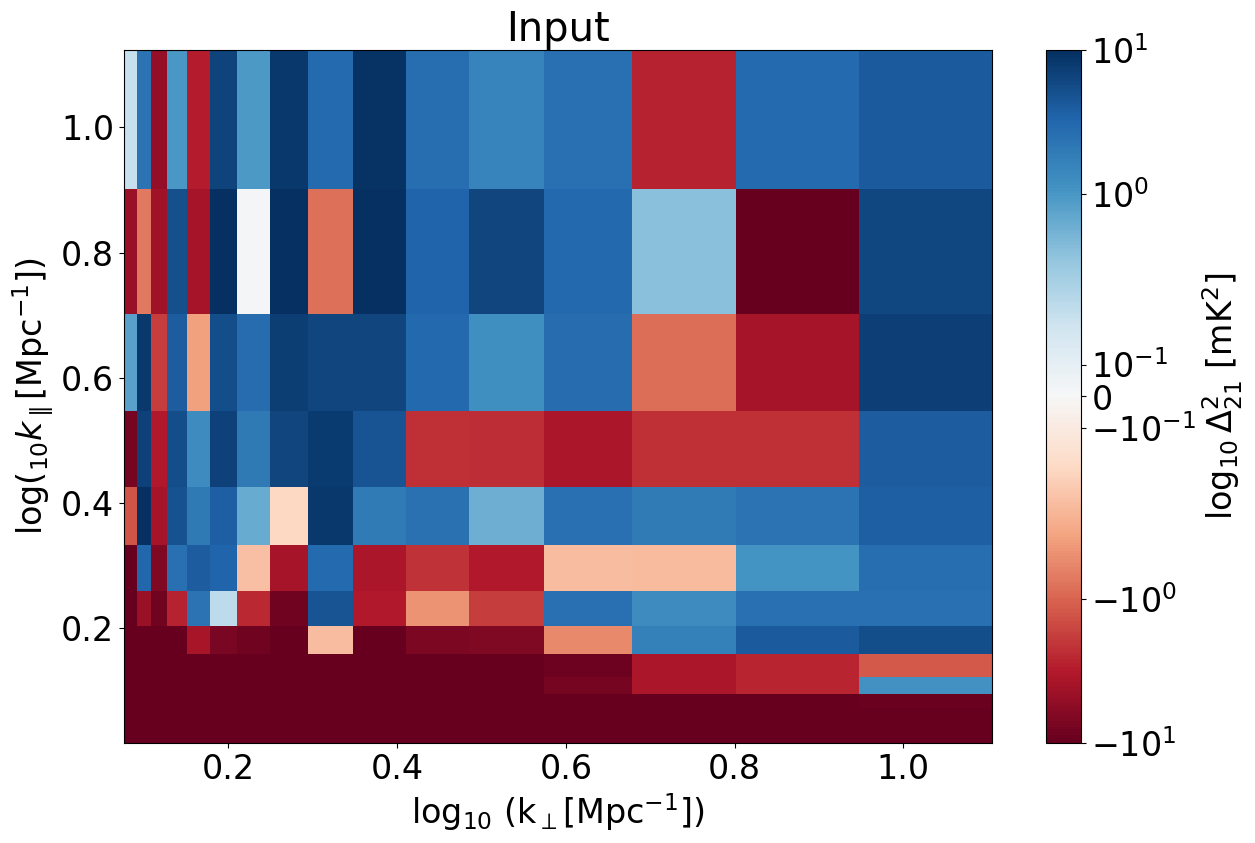

In [56]:
imshow_error_2D(fe_avg,xs_plot = kperp, ys_plot = kpar, vmin = -10, vmax = 10, cmap = 'RdBu')

In [6]:
params = np.load('/projects/cosmo_database/dbreitman/CV_PS/Full_May2023_DB/test_inputs.npy')

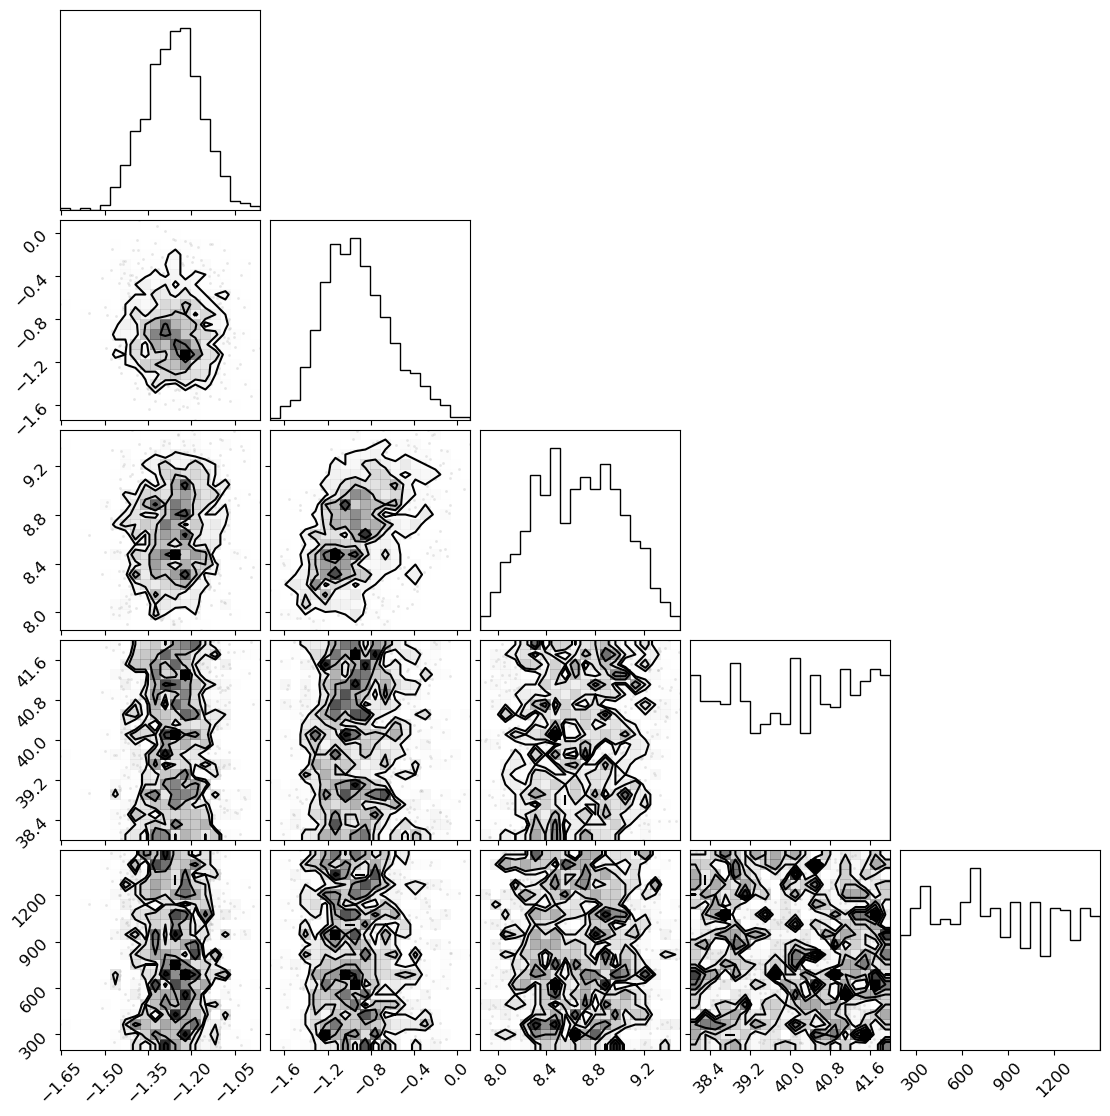

In [9]:
corner.corner(params)
plt.show()

In [10]:
np.max(params, axis = 0)

array([-9.61803367e-01,  1.22542977e-01,  9.50199752e+00,  4.19995699e+01,
        1.49793618e+03])

In [37]:
def cnn_list(nconvs:int, 
                 in_ch: int, out_ch: int, 
                 hid_ch:int=None, kernel_size:int = 2, 
                 stride:int=1, padding:int='same', final_act:bool=False,
                 batch_norm: bool = False, act_fn: object = nn.LeakyReLU, 
                 residual:bool = False) -> nn.ModuleList:

    act = act_fn()
    if hid_ch is None:
        hid_ch = out_ch
    if batch_norm:
        conv_in = nn.ModuleList(nn.Sequential(nn.Conv2d(in_ch, hid_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn(), nn.BatchNorm2d(hid_ch)))
        conv_hid = nn.Sequential(nn.Conv2d(hid_ch, hid_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn(), nn.BatchNorm2d(hid_ch),)
    else:
        conv_in = nn.ModuleList(nn.Sequential(nn.Conv2d(in_ch, hid_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn()))
        conv_hid = nn.Sequential(nn.Conv2d(hid_ch, hid_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn())
    cnn = nn.ModuleList([conv_hid for i in range(nconvs-2)])
    if final_act:
        conv_out = nn.Sequential(nn.Conv2d(hid_ch, out_ch, kernel_size = kernel_size, stride = stride, padding = padding), act_fn())
    else:
        conv_out = nn.Conv2d(hid_ch, out_ch, kernel_size = kernel_size, stride = stride, padding = padding)
    if residual:
        return ResNet(conv_in.extend(cnn.append(conv_out)))
    else:
        return conv_in.extend(cnn.append(conv_out))

In [39]:
foo = cnn_list(2,1,2,residual = True)
print(foo)

ResNet(
  (module): ModuleList(
    (0): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(2, 2, kernel_size=(2, 2), stride=(1, 1), padding=same)
  )
)


In [149]:
ffee = abs((mean_pred - ps_data[...,1]) / ps_data[...,1])

In [150]:
ffee[zs_test == zs[3]].mean()

0.8311111593273758

In [142]:
# FnP   
f = np.load(path + 'FnP_db.npz')
seeds = f['PS_2D_seeds']
print(seeds.min(), seeds.max())
zs = f['redshifts']
kperp = f['kperp']
kpar = f['kpar']
param_idx_fnp = f['param_idx']

#std_poisson = std_poisson.reshape(shape1[:-1])
print(seeds.shape)
s = (seeds.shape[0]*seeds.shape[1], seeds.shape[2], seeds.shape[3], seeds.shape[4])
s1 = seeds.shape
#fnp_seeds = (np.log10(seeds.reshape(s)) - noisy_mean) / noisy_std
fnp_seeds = seeds.reshape(s1)
print(fnp_seeds.min(), fnp_seeds.max())

0.01 308371909.529907
(413, 2, 16, 32, 32)
0.01 308371909.529907


In [ ]:
mean_pred = 10**(((torch.Tensor(Y_pred[:,0,...]) * mean_std) + mean_mean)).cpu().numpy()

In [25]:
floor = 1e-2

In [195]:
ps_data[...,1].shape

(77392, 32, 32)

In [143]:
z_idx = 10
m8 = zs_test == zs[z_idx]

In [27]:
zs[z_idx]

12.021969

In [144]:
# Compare w FnP
theta = 200
mtest = param_idx_test == theta
mfnp = param_idx_fnp == theta

test_fe = ffee_mean[mtest]

fnp_fe = []
fnp_fe2 = []
fnp_fe3 = []
fnp_fe4 = []
fnp_all = []

fnp_seeds_theta = fnp_seeds[mfnp]
mc_mean = means[mtest][zs_test[mtest] == zs[z_idx]][0]#Y_test[...,0][mtest][0]
mc_mean[mc_mean < floor] = floor

for i in range(1):
    m1 = np.mean(fnp_seeds_theta[i,...], axis = 0)[z_idx]
    print(m1)
    print('mc',mc_mean)
    this_fe = abs((m1 - mc_mean) / mc_mean)
    fnp_fe.append(this_fe)
    pick_seeds = np.arange(fnp_seeds_theta.shape[0])
    np.random.shuffle(pick_seeds)
    two_seeds = pick_seeds[:2]
    s3 = (fnp_seeds_theta[two_seeds,...].shape[0]*2, len(zs), 32, 32)
    m1 = 10**(((torch.Tensor(np.mean(fnp_seeds_theta[two_seeds,...].reshape(s3), axis = 0) ) * mean_std) + mean_mean)).cpu().numpy()
    fnp_fe2.append(abs((m1 - mc_mean) / mc_mean))
    
    three_seeds = pick_seeds[:3]
    s3 = (fnp_seeds_theta[three_seeds,...].shape[0]*2, len(zs), 32, 32)
    m1 = 10**(((torch.Tensor(np.mean(fnp_seeds_theta[three_seeds,...].reshape(s3), axis = 0) ) * mean_std) + mean_mean)).cpu().numpy()

    fnp_fe3.append(abs((m1 - mc_mean) / mc_mean))
    
    four_seeds = pick_seeds[:4]
    s3 = (fnp_seeds_theta[four_seeds,...].shape[0]*2, len(zs), 32, 32)
    m1 = 10**(((torch.Tensor(np.mean(fnp_seeds_theta[four_seeds,...].reshape(s3), axis = 0) ) * mean_std) + mean_mean)).cpu().numpy()

    fnp_fe4.append(abs((m1 - mc_mean) / mc_mean))

s3 = (fnp_seeds_theta.shape[0]*2, len(zs), 32, 32)
m1 = 10**(((torch.Tensor(np.mean(fnp_seeds_theta.reshape(s3), axis = 0)) * mean_std) + mean_mean)).cpu().numpy()

fnp_feall = abs((m1 - mc_mean) / mc_mean)
fnp_fe = np.array(fnp_fe)
print(fnp_fe)
fnp_fe2 = np.array(fnp_fe2)
fnp_fe3 = np.array(fnp_fe3)
fnp_fe4 = np.array(fnp_fe4)
fnp_feall = np.array(fnp_feall)

[[1.43771824e+07 2.04650376e+06 1.49052152e+06 ... 6.75564750e+03
  5.62659792e+03 7.20008005e+03]
 [6.08088918e+06 3.19574627e+06 5.96996635e+05 ... 2.90093057e+03
  3.07230642e+03 2.09563320e+03]
 [4.01202868e+06 1.66741173e+06 3.39192800e+05 ... 6.82431515e+03
  4.13775568e+03 4.71232869e+03]
 ...
 [5.94090772e+03 5.53006772e+03 5.75281772e+03 ... 6.56084705e+02
  6.55322891e+02 6.20217889e+02]
 [4.43979538e+03 4.25912081e+03 4.05538849e+03 ... 6.02449143e+02
  5.86518179e+02 5.76567064e+02]
 [3.22613352e+03 3.09118468e+03 3.11182237e+03 ... 5.34062083e+02
  5.22640193e+02 5.14702048e+02]]
mc [[1.00649336e+07 2.09569974e+06 8.11584104e+05 ... 4.32528596e+03
  4.31721781e+03 3.91360271e+03]
 [7.25979501e+06 1.78704119e+06 7.64560366e+05 ... 3.69746569e+03
  3.38750975e+03 3.30097491e+03]
 [5.33295281e+06 1.61847060e+06 6.24891233e+05 ... 2.24622016e+03
  2.35306462e+03 2.15815934e+03]
 ...
 [5.76993070e+03 5.68716211e+03 5.53658096e+03 ... 6.51013354e+02
  6.28333427e+02 6.07226704e+

/var/tmp/pbs.206354.pbs01/ipykernel_259774/310370264.py:28: RuntimeWarning: overflow encountered in power
  m1 = 10**(((torch.Tensor(np.mean(fnp_seeds_theta[two_seeds,...].reshape(s3), axis = 0) ) * mean_std) + mean_mean)).cpu().numpy()
/var/tmp/pbs.206354.pbs01/ipykernel_259774/310370264.py:33: RuntimeWarning: overflow encountered in power
  m1 = 10**(((torch.Tensor(np.mean(fnp_seeds_theta[three_seeds,...].reshape(s3), axis = 0) ) * mean_std) + mean_mean)).cpu().numpy()
/var/tmp/pbs.206354.pbs01/ipykernel_259774/310370264.py:39: RuntimeWarning: overflow encountered in power
  m1 = 10**(((torch.Tensor(np.mean(fnp_seeds_theta[four_seeds,...].reshape(s3), axis = 0) ) * mean_std) + mean_mean)).cpu().numpy()
/var/tmp/pbs.206354.pbs01/ipykernel_259774/310370264.py:44: RuntimeWarning: overflow encountered in power
  m1 = 10**(((torch.Tensor(np.mean(fnp_seeds_theta.reshape(s3), axis = 0)) * mean_std) + mean_mean)).cpu().numpy()


In [75]:
m1.shape

(16, 32, 32)

In [57]:
mtest

array([ True,  True,  True, ..., False, False, False])

In [58]:
zs_test[mtest] == zs[z_idx]

array([False, False, False, ...,  True, False, False])

In [248]:
((mmm1 - mc_mean) / mc_mean == (mm1 - mc_mean) / mc_mean).all()

True

In [223]:
np.mean(fnp_seeds.reshape(s3), axis = 0).shape

(16, 32, 32)

In [203]:
mc_mean.shape

(82, 32, 32)

In [87]:
fnp_fe.shape, ffee.shape

((9, 16, 32, 32), (77392, 32, 32))

In [250]:
fnp_all.shape

(1, 16, 32, 32)

In [91]:
np.mean(fnp_fe[:,z_idx,...].ravel()*100.)

20.989629966627813

In [131]:
fnp_fe.shape

(1, 32, 32)

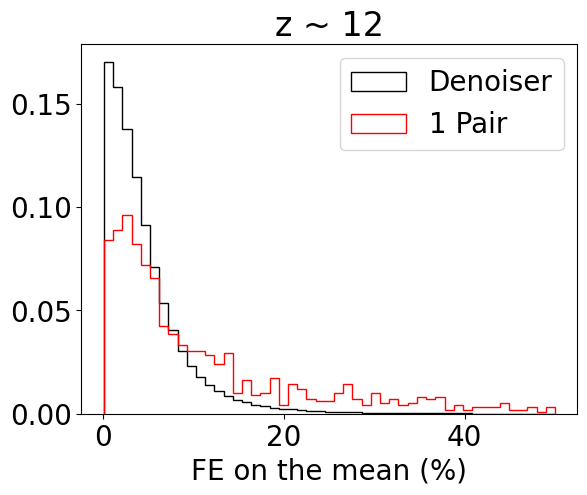

In [130]:
x = np.linspace(0,50,50)
plt.hist(ffee_mean[m8].ravel()*100., bins = x, color = 'k', label = 'Denoiser', density=True, histtype='step')
plt.hist(fnp_fe.ravel()*100., bins = x, color = 'r', label = '1 Pair', density = True, histtype='step')
#plt.hist(fnp_fe2[:,z_idx,...].ravel()*100., bins = x, color = 'b', label = '2 Pairs', density = True, histtype='step')
#plt.hist(fnp_fe3[:,z_idx,...].ravel()*100., bins = x, color = 'g', label = '3 Pairs', density = True, histtype='step')
#plt.hist(fnp_fe3[:,z_idx,...].ravel()*100., bins = x, color = 'orange', label = '4 Pairs', density = True, histtype='step')
#plt.hist(fnp_feall[z_idx,...].ravel()*100., bins = x, color = 'lime', label = 'All 9 Pairs', density = True, histtype='step')
plt.legend()
plt.title('z ~ ' + str(round(zs[z_idx])))
plt.xlabel('FE on the mean (%)')
plt.show()

308371909.529907 0.01
Redshift:  6.5380096
CHECKKK:  28.171755294541605


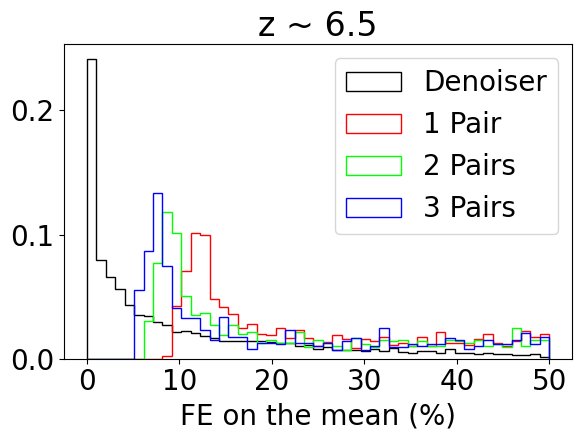

Redshift:  7.0316668
CHECKKK:  22.703953076936557


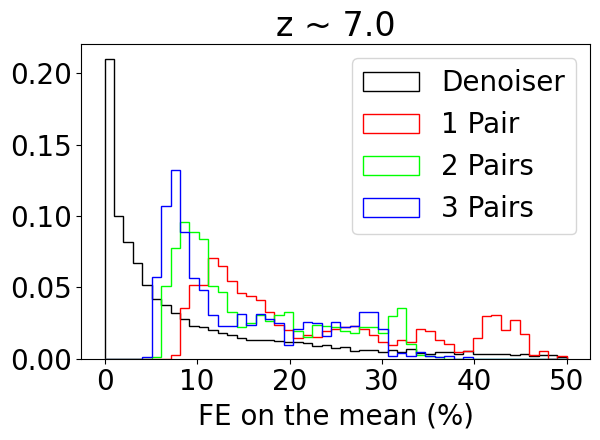

Redshift:  7.480909
CHECKKK:  20.088230451584007


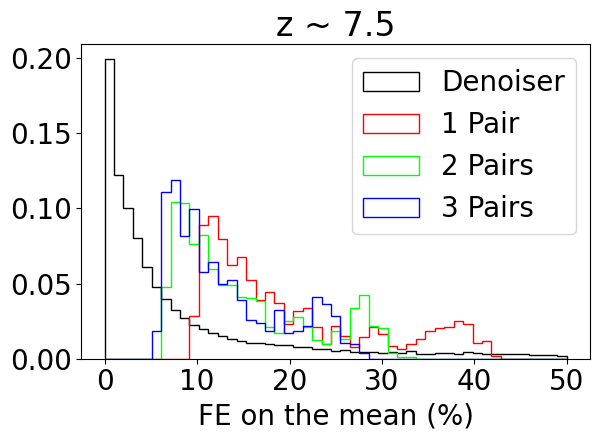

Redshift:  7.9688025
CHECKKK:  22.249671578813263


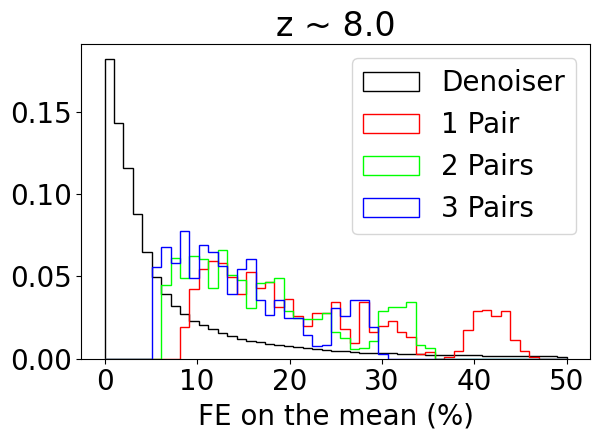

Redshift:  9.984456
CHECKKK:  12.732308281144295


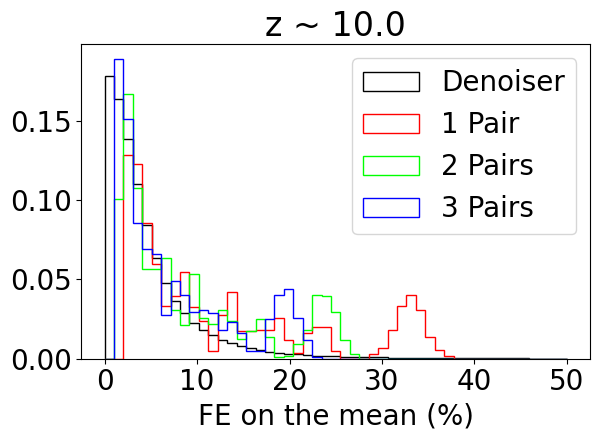

Redshift:  12.021969
CHECKKK:  13.026353433690204


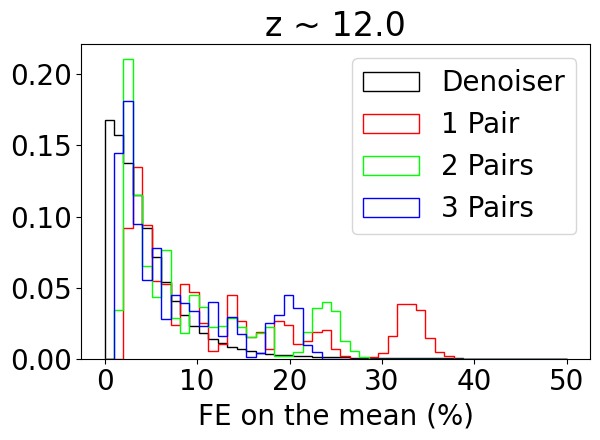

Redshift:  14.921763
CHECKKK:  13.187891799447495


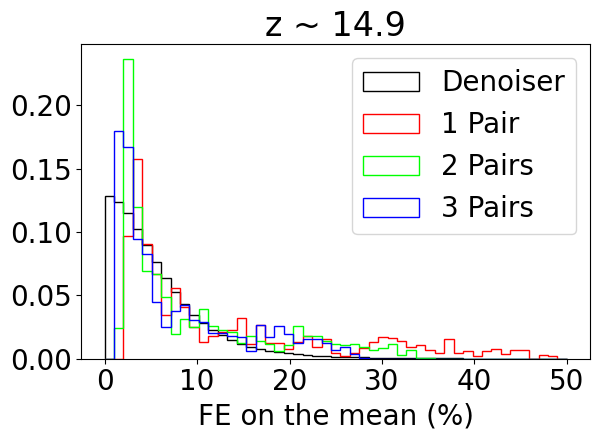

Redshift:  17.93892
CHECKKK:  15.022550934680853


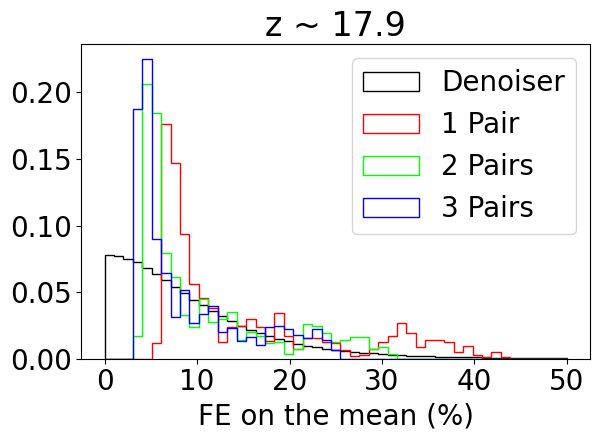

In [175]:
# FnP   
f = np.load(path + 'FnP_db.npz')
seeds = f['PS_2D_seeds']

zs = f['redshifts']
kperp = f['kperp']
kpar = f['kpar']
param_idx_fnp = f['param_idx']

#std_poisson = std_poisson.reshape(shape1[:-1])

s = (seeds.shape[0]*seeds.shape[1], seeds.shape[2], seeds.shape[3], seeds.shape[4])
s1 = seeds.shape
#fnp_seeds = (np.log10(seeds.reshape(s)) - noisy_mean) / noisy_std
fnp_seeds = seeds.reshape(s1)
print(fnp_seeds.max(), fnp_seeds.min())
floor = 1e-2

z_idxs = [0,1,2,3,7,10,13,14]
thetas = np.arange(50) + 200
for z_idx in z_idxs:
    print('Redshift: ', zs[z_idx])
    m8 = zs_test == zs[z_idx]
    avg_over_pairs = np.zeros((len(thetas), len(kperp), len(kpar)))
    avg_over_pairs2 = np.zeros((len(thetas), len(kperp), len(kpar)))
    avg_over_pairs3 = np.zeros((len(thetas), len(kperp), len(kpar)))
    avg_over_all_pairs = np.zeros((len(thetas), len(kperp), len(kpar)))
    for theta in thetas:
        # Compare w FnP
        mtest = param_idx_test == theta
        mfnp = param_idx_fnp == theta

        test_fe = ffee_mean[mtest]

        fnp_fe = []
        fnp_fe2 = []
        fnp_fe3 = []
        fnp_fe4 = []
        fnp_all = []

        fnp_seeds_theta = fnp_seeds[mfnp]

        mc_mean = means[mtest][zs_test[mtest] == zs[z_idx]][0]#Y_test[...,0][mtest][0]
        mc_mean[mc_mean < floor] = floor
        npairs = fnp_seeds_theta.shape[0]

        for i in range(npairs):
            m1 = np.mean(fnp_seeds_theta[i,...], axis = 0)[z_idx]
            this_fe = abs((m1 - mc_mean) / mc_mean)
            fnp_fe.append(this_fe)
            
            pick_seeds = np.arange(fnp_seeds_theta.shape[0])
            np.random.shuffle(pick_seeds)
            
            two_seeds = pick_seeds[:2]
            s3 = (fnp_seeds_theta[two_seeds,...].shape[0]*2, len(zs), 32, 32)
            m1 = np.mean(fnp_seeds_theta[two_seeds,...].reshape(s3), axis = 0)[z_idx]
            fnp_fe2.append(abs((m1 - mc_mean) / mc_mean))

            three_seeds = pick_seeds[:3]
            s3 = (fnp_seeds_theta[three_seeds,...].shape[0]*2, len(zs), 32, 32)
            m1 = np.mean(fnp_seeds_theta[three_seeds,...].reshape(s3), axis = 0)[z_idx]
            
            fnp_fe3.append(abs((m1 - mc_mean) / mc_mean))

            #four_seeds = pick_seeds[:4]
            #s3 = (fnp_seeds_theta[four_seeds,...].shape[0]*2, len(zs), 32, 32)
            #m1 = 10**(((torch.Tensor(np.mean(fnp_seeds_theta[four_seeds,...].reshape(s3), axis = 0) ) * mean_std) + mean_mean)).cpu().numpy()

            #fnp_fe4.append(abs((m1 - mc_mean) / mc_mean))
        s3 = (fnp_seeds_theta.shape[0]*2, len(zs), 32, 32)
        m1 = np.mean(fnp_seeds_theta.reshape(s3), axis = 0)[z_idx]

        fnp_feall = abs((m1 - mc_mean) / mc_mean)
        
        fnp_fe = np.array(fnp_fe)
        fnp_fe2 = np.array(fnp_fe2)
        fnp_fe3 = np.array(fnp_fe3)
        fnp_fe4 = np.array(fnp_fe4)
        fnp_feall = np.array(fnp_feall)
        #print('SHAPE', fnp_fe.shape)
        avg_over_pairs[theta-200] = np.mean(fnp_fe, axis = 0)
        avg_over_pairs2[theta-200] = np.mean(fnp_fe2, axis = 0)
        avg_over_pairs3[theta-200] = np.mean(fnp_fe3, axis = 0)
        avg_over_all_pairs[theta-200] = np.mean(fnp_feall, axis = 0)
    avg_over_thetas = np.mean(avg_over_pairs, axis = 0)
    avg_over_thetas2 = np.mean(avg_over_pairs2, axis = 0)
    avg_over_thetas3 = np.mean(avg_over_pairs3, axis = 0)
    avg_over_thetas_all = np.mean(avg_over_all_pairs, axis = 0)
    x = np.linspace(0,50,50)
    plt.hist(ffee_mean[m8].ravel()*100., bins = x, color = 'k', label = 'Denoiser', density=True, histtype='step')
    plt.hist(avg_over_thetas.ravel()*100., bins = x, color = 'r', label = '1 Pair', density = True, histtype='step')
    plt.hist(avg_over_thetas2.ravel()*100., bins = x, color = 'lime', label = '2 Pairs', density = True, histtype='step')
    plt.hist(avg_over_thetas3.ravel()*100., bins = x, color = 'b', label = '3 Pairs', density = True, histtype='step')
    #plt.hist(avg_over_thetas_all.ravel()*100., bins = x, color = 'magenta', label = 'All Pairs (5-11)', density = True, histtype='step')
    plt.legend()
    plt.title('z ~ ' + str(round(zs[z_idx],1)))
    plt.xlabel('FE on the mean (%)')
    plt.tight_layout()
    print('CHECKKK: ', np.mean(avg_over_thetas.ravel()*100.))
    #plt.savefig(model_path+'Plots/'+model_name+'FnP_z_' + str(int(round(zs[z_idx],1)*10)))
    plt.show()

In [49]:
m1.min(), m1.max()

(0.010036293552247753, 11386338.198933082)

In [53]:
m1.min(), m1.max()

(0.011276822642489122, 10483204.327613706)

In [289]:
fnp_fe.shape

(1, 16, 32, 32)

In [290]:
np.median(fnp_fe[0,3])

0.9180270032168769

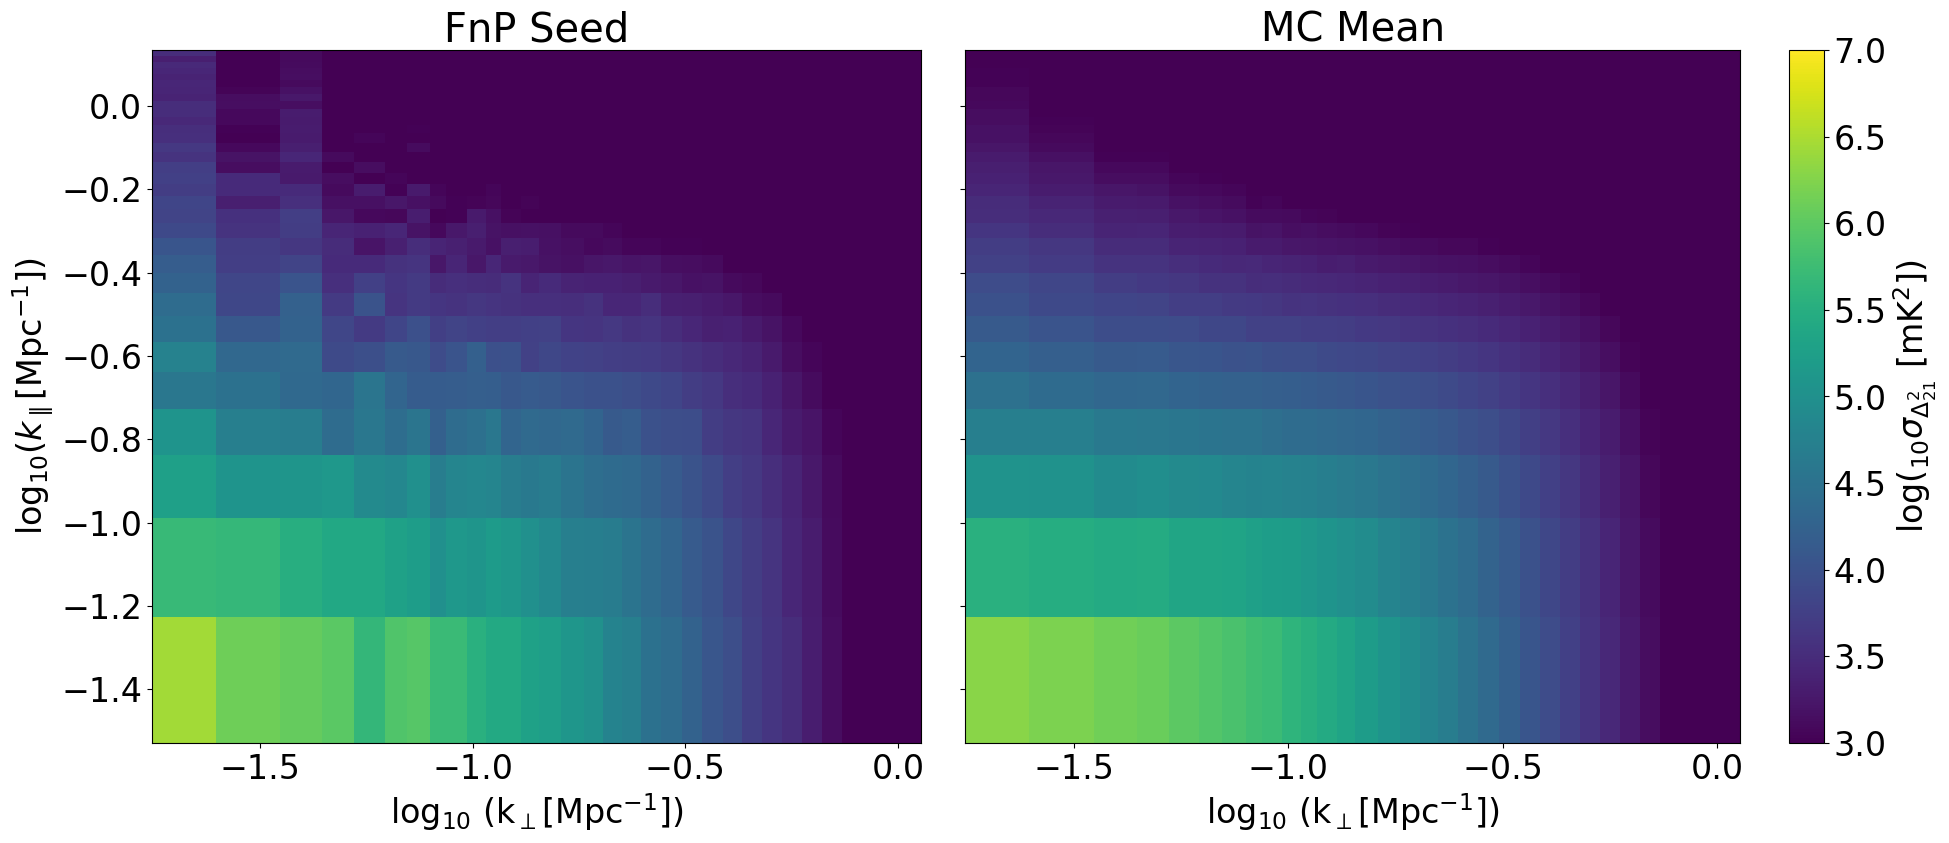

In [267]:
imshow_error_2D(np.log10(10**(((torch.Tensor(np.mean(fnp_seeds[0,...], axis = 0) ) * mean_std) + mean_mean)).cpu().numpy()[z_idx]), truthmean = np.log10(mc_mean), 
                xs_plot = np.log10(kperp), ys_plot = np.log10(kpar), title2 = 'FnP Seed', title3 = 'MC Mean',
             vmin = 3, vmax = 7, label = r'log($_{10}\sigma_{\Delta^2_{21}}$ [mK$^2$])', log = False)